In [1]:
# Standard library imports
import os
import importlib
from collections import Counter

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Configure matplotlib with scienceplots style
import scienceplots
plt.style.use(['science', 'grid'])
plt.rcParams['figure.dpi'] = 500
plt.rcParams.update({
    'font.size': 22,
    'axes.titlesize': 22,
    'axes.labelsize': 22,
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
})

# Custom module imports
import dataset_pipeline  
importlib.reload(dataset_pipeline)
from dataset_pipeline import (
    DICOMProcessor, Plotter, 
    GBMDataset3D_Survival, DoseLoader, DoseLoaderCache, 
    GBMDataset3D_PFS
)

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

/Users/aleksanderbechlund/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def patient_response_dict(clinical_data, patient_ids, mapping=None):
    """
    Creates a dictionary with patient ID as the key and a numeric label as the value.
    
    Parameters:
    - clinical_data: Pandas DataFrame containing patient data
    - patient_ids: List of patient IDs
    - mapping: Dictionary mapping string labels to numeric values
    
    Returns:
    - dict: Dictionary with patient ID as key and numeric label as value
    """
    patient_response_dict = {}
    
    for patient_id in patient_ids:
        # Find the correct row for the patient
        patient_row = clinical_data.loc[clinical_data['AnonymPatientID'] == f"Burdenko-GBM-{patient_id:03d}"]
        
        if not patient_row.empty:
            # Retrieve the patient's 'Response_1st_fup' value
            response_value = patient_row['Response_1st_fup'].values[0]
            # Map response_value to a numeric label
            if mapping and response_value in mapping:
                response_label = mapping[response_value]
            elif isinstance(response_value, str):
                # If response_value is a numeric string, convert to int
                try:
                    response_label = int(response_value)
                except ValueError:
                    # If conversion fails, set to a default value or handle as needed
                    response_label = -1
            else:
                # If response_value is already numeric
                response_label = response_value
            # Add to the dictionary
            patient_response_dict[patient_id] = response_label
        else:
            # If patient ID is not found in clinical_data, you can for example assign a None value or a default label
            patient_response_dict[patient_id] = -1  # Use -1 for missing label
    
    return patient_response_dict

def custom_collate_fn(batch):
    collated_batch = {}
    # Collate tensor fields
    tensor_fields = ['image', 'label', 'patient_id', 'age', 'sex', 'idh_status', 'mgmt_status',
                     'survival_time', 'number_of_fractions_planned', 'delivery_maximum_dose', 'prescription_dose']
    for field in tensor_fields:
        collated_batch[field] = torch.stack([item[field] for item in batch])
    # Keep 'slice_contours' and 'structure_masks' as lists
    collated_batch['slice_contours'] = [item['slice_contours'] for item in batch]
    collated_batch['structure_masks'] = [item['structure_masks'] for item in batch]

    return collated_batch

In [3]:
# Read the clinical data
clinical_data = pd.read_csv("Burdenko-GBM-clinical-data.csv")
# Define patient IDs
patient_ids = np.arange(0, 181)

# Filter rows based on the patient IDs
filtered_data = clinical_data.loc[clinical_data['AnonymPatientID'].isin([f"Burdenko-GBM-{pid:03d}" for pid in patient_ids])]

# Extract the 'Response_1st_fup' column and find unique labels
unique_labels = filtered_data['Response_1st_fup'].unique()
print("Unique labels in 'Response_1st_fup':", unique_labels)

# Count the frequency of each label
label_counts = filtered_data['Response_1st_fup'].value_counts()
print("\nCount of each label:")
print(label_counts)


Unique labels in 'Response_1st_fup': ['response' 'progression' 'stable' 'pseudo progression' nan
 'response, distant progression']

Count of each label:
Response_1st_fup
response                         86
stable                           40
pseudo progression               31
progression                      20
response, distant progression     1
Name: count, dtype: int64


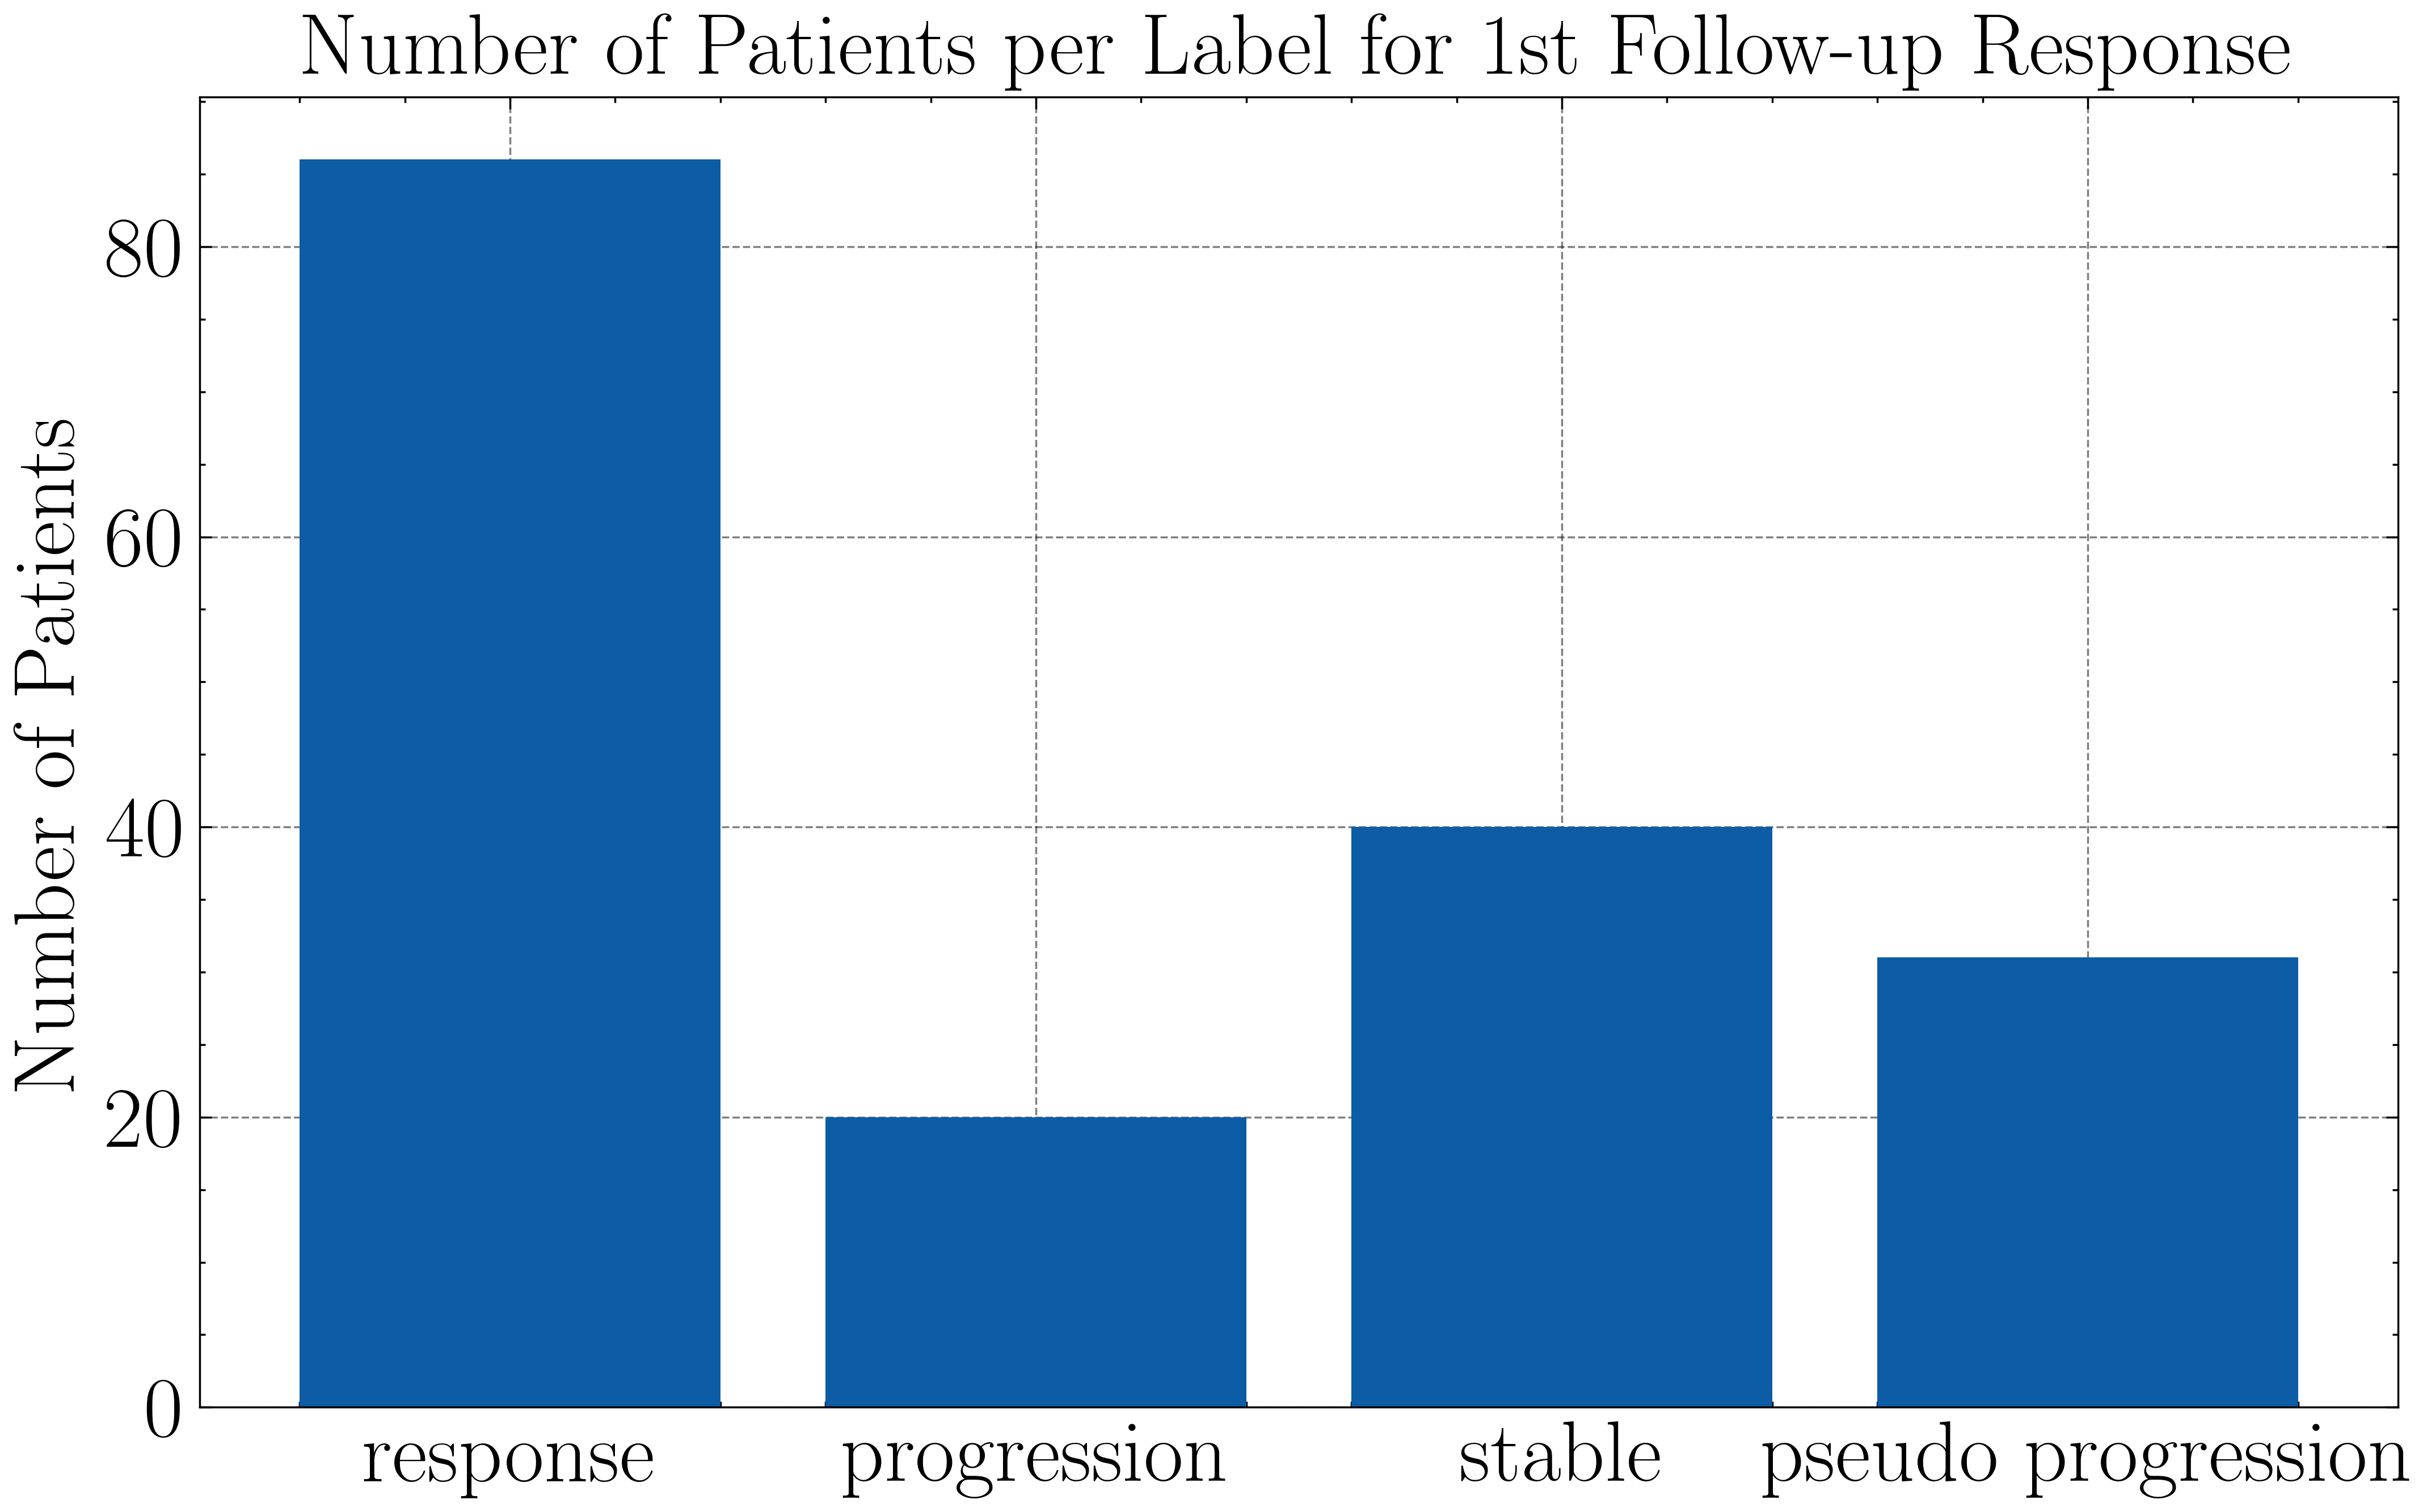

In [4]:
# Define patient IDs
patient_ids = np.arange(0, 181)

# Define mapping for labels
label_mapping = {
    'response': 0,
    'progression': 1,
    'stable': 2,
    'pseudo progression': 3
}

clinical_data = pd.read_csv("Burdenko-GBM-clinical-data.csv")
labels_dict = patient_response_dict(clinical_data, patient_ids, mapping=label_mapping)

# Extract the labels
labels = list(labels_dict.values())

# Use Counter to count the occurrences of each label
label_counts = Counter(labels)

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(label_mapping.keys(), [label_counts[i] for i in range(len(label_mapping))])
plt.ylabel('Number of Patients')
plt.title('Number of Patients per Label for 1st Follow-up Response')
plt.show()

**Clinical Data**

In [5]:
data = pd.read_csv("Burdenko-GBM-clinical-data.csv")
data.head()

,AnonymPatientID,AnonymStudyDate,Sex,IDH1/2,MGMT,Response_1st_fup,Response_2nd_fup,Response_3rd_fup,Response_4th_fup,Response_5th_fup,...,Anonym3rd_fup,Anonym4th_fup,Anonym5th_fup,Anonym6th_fup,Anonym7th_fup,Anonym8th_fup,Anonym9th_fup,Anonym10th_fup,AnonymDeath,AgeAtStudyDate
0,Burdenko-GBM-001,5/6/04,F,negative,negative,response,stable,stable,stable,stable,...,10/4/04,12/23/04,3/30/05,,,,,,,51.0
1,Burdenko-GBM-002,9/9/04,M,positive,positive,response,response,progression,NaN,NaN,...,6/17/05,,,,,,,,8/11/05,72.0
2,Burdenko-GBM-003,9/8/04,M,NaN,NaN,progression,NaN,NaN,NaN,NaN,...,,,,,,,,,12/5/05,64.0
3,Burdenko-GBM-004,9/5/04,F,negative,positive,stable,progression,progression,NaN,NaN,...,3/23/05,,,,,,,,12/2/06,54.0
4,Burdenko-GBM-005,9/11/04,F,negative,negative,stable,NaN,NaN,NaN,NaN,...,,,,,,,,,,68.0


Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Skipping cropping as it is disabled.


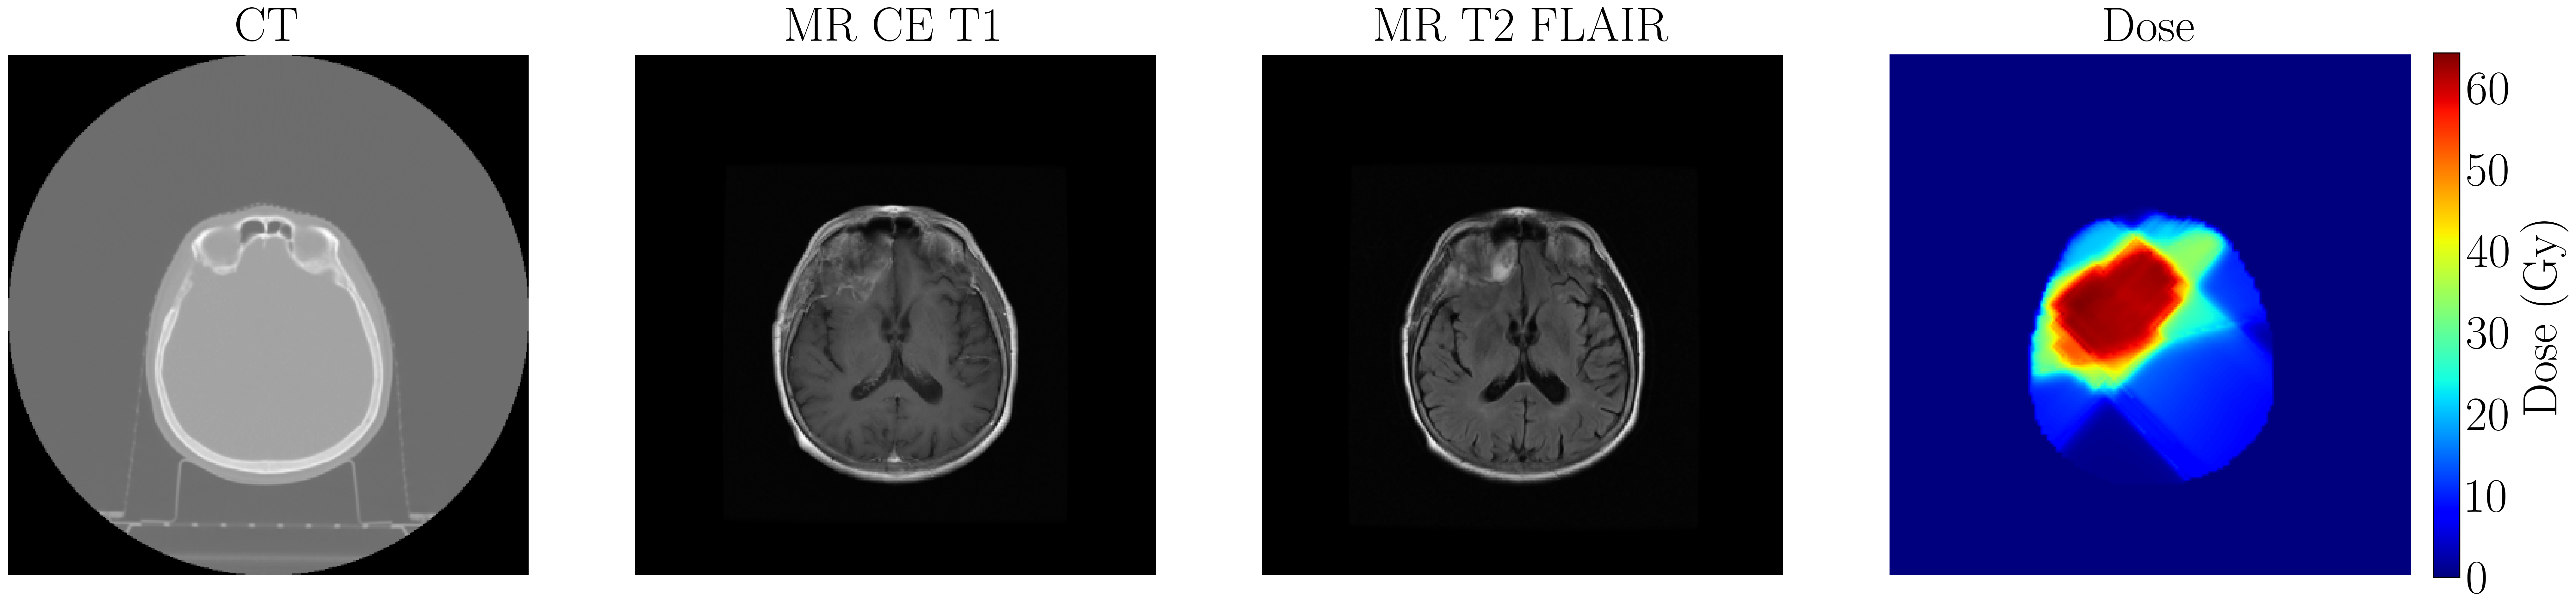

In [6]:

patient_id = 57
base_path = "Burdenko-GBM-Progression"
patient_id = f"Burdenko-GBM-{patient_id:03d}"

processor = DICOMProcessor(patient_id, base_path, verbose=True, bias_correction_enabled=False, apply_cropping=False)
processor.load_all_data()

plotter = Plotter(processor, verbose=False)
slice_idx = 118

fig, axes = plt.subplots(1, 4, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1.095]})

# Plot CT-slice
plotter.plot_ct_slice(slice_idx, ax=axes[0])
axes[0].set_title('CT')

# Plot MR T1-slice
plotter.plot_mr_t1_slice(slice_idx, ax=axes[1])
axes[1].set_title('MR CE T1')

# Plot MR T2-slice
plotter.plot_mr_t2_slice(slice_idx, ax=axes[2])
axes[2].set_title('MR T2 FLAIR')

# Plot Dose-slice 
plotter.plot_dose_slice(slice_idx, ax=axes[3])
axes[3].set_title('Dose')

plt.savefig("Bilder/visualisation_before_cropping.pdf")
plt.show()

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[66, 73, 19], size=[217, 217, 175]


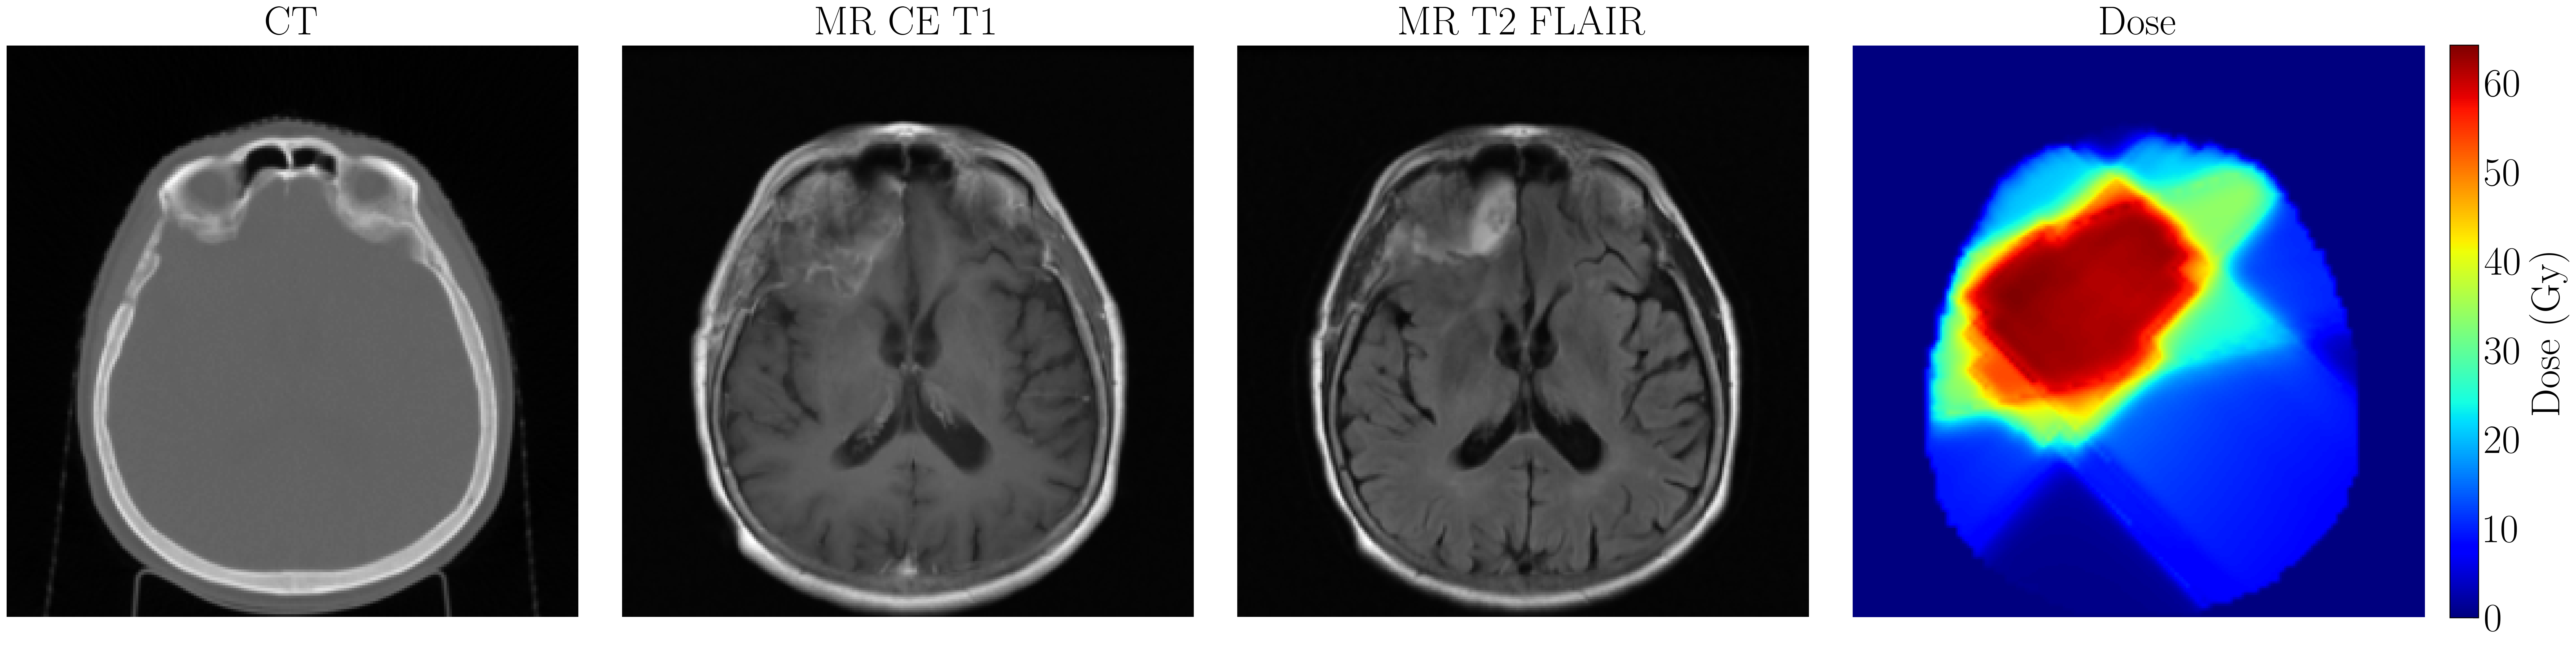

In [7]:
patient_id = 57

base_path = "Burdenko-GBM-Progression"
patient_id = f"Burdenko-GBM-{patient_id:03d}"
# Initialiser DICOMProcessor og last inn data
processor = DICOMProcessor(patient_id, base_path, verbose=True, bias_correction_enabled=False, apply_cropping=True)
processor.load_all_data()

plotter = Plotter(processor, verbose=False, target_resolution=(256,256))

slice_idx = 100

fig, axes = plt.subplots(1, 4, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1.095]})
# Plot CT-slice
plotter.plot_ct_slice(slice_idx, ax=axes[0])
axes[0].set_title('CT')

# Plot MR T1-slice
plotter.plot_mr_t1_slice(slice_idx, ax=axes[1])
axes[1].set_title('MR CE T1')

# Plot MR T2-slice
plotter.plot_mr_t2_slice(slice_idx, ax=axes[2])
axes[2].set_title('MR T2 FLAIR')

# Plot Dose-slice 
plotter.plot_dose_slice(slice_idx, ax=axes[3])
axes[3].set_title('Dose')

plt.tight_layout()
plt.savefig("Bilder/visualisation_after_cropping.pdf")
plt.show()

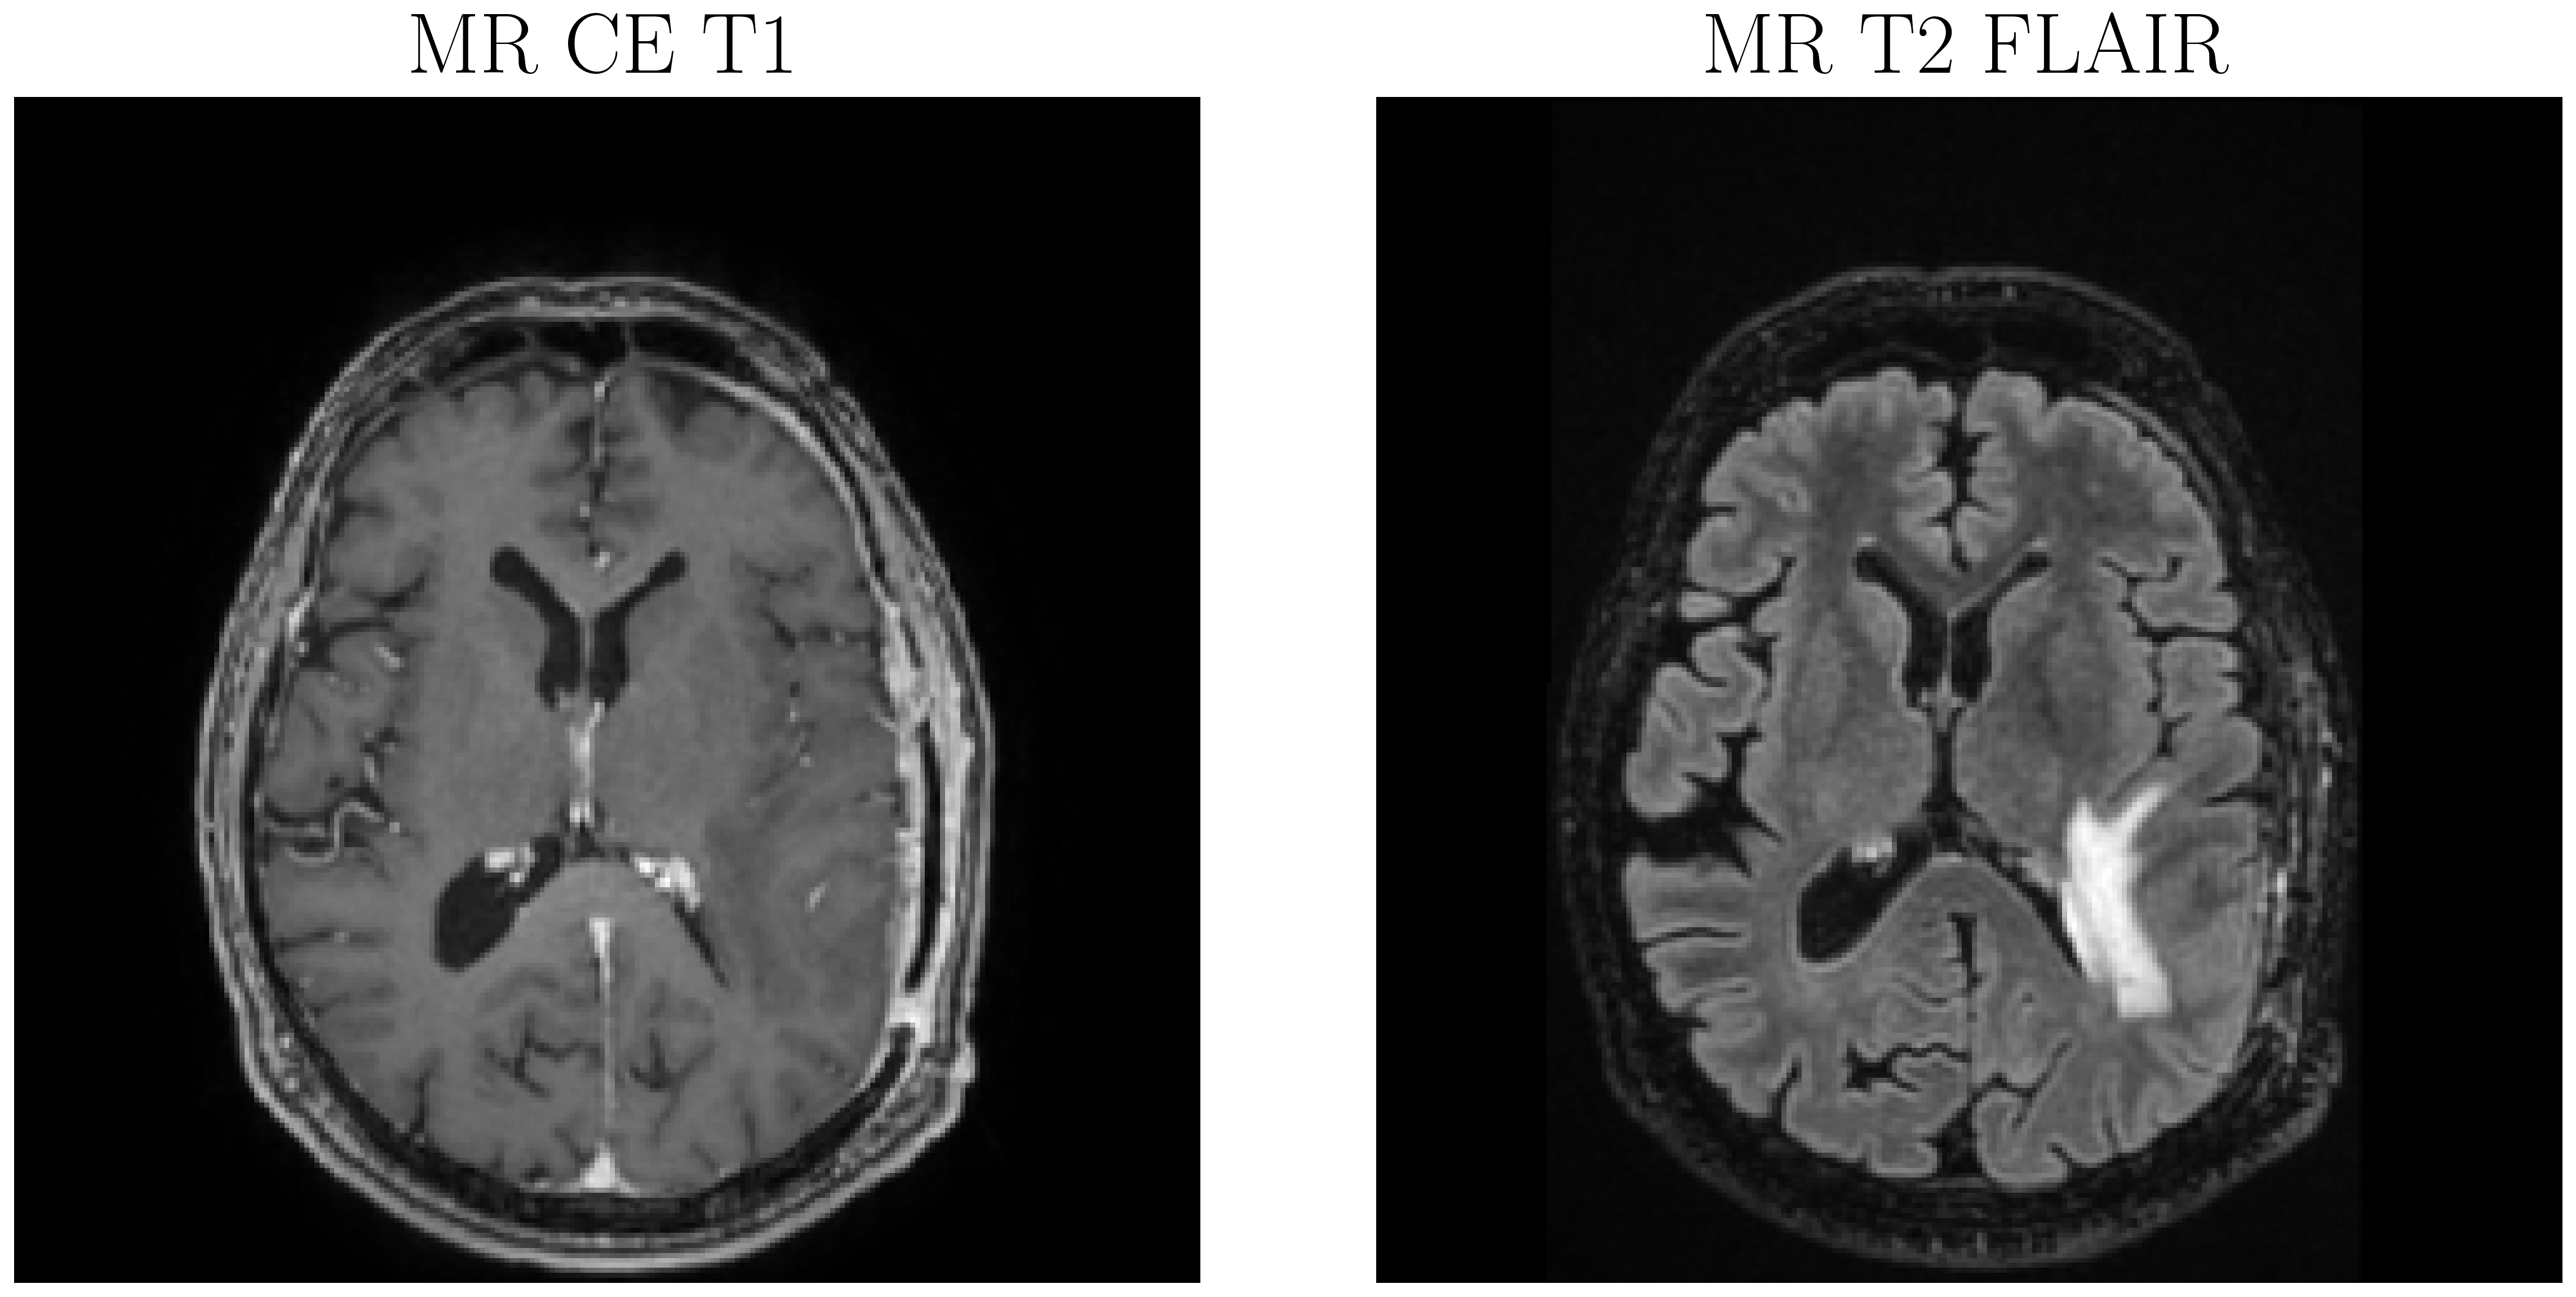

In [8]:
patient_id = 15
base_path = "Burdenko-GBM-Progression"
patient_id = f"Burdenko-GBM-{patient_id:03d}"
# Initialiser DICOMProcessor og last inn data
processor = DICOMProcessor(patient_id, base_path, verbose=False, bias_correction_enabled=True)
processor.load_all_data()
# Initialiser Plotter
plotter = Plotter(processor, verbose=False)

# Velg slice-indeks
slice_idx = 165

# Opprett subplots for MR T1 og MR T2
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot MR T1-slice
plotter.plot_mr_t1_slice(slice_idx, ax=axes[0])
axes[0].set_title('MR CE T1')

# Plot MR T2-slice
plotter.plot_mr_t2_slice(slice_idx, ax=axes[1])
axes[1].set_title('MR T2 FLAIR')

plt.tight_layout()
plt.savefig("Bilder/exampleGBM_T1_T2.pdf")
plt.show()

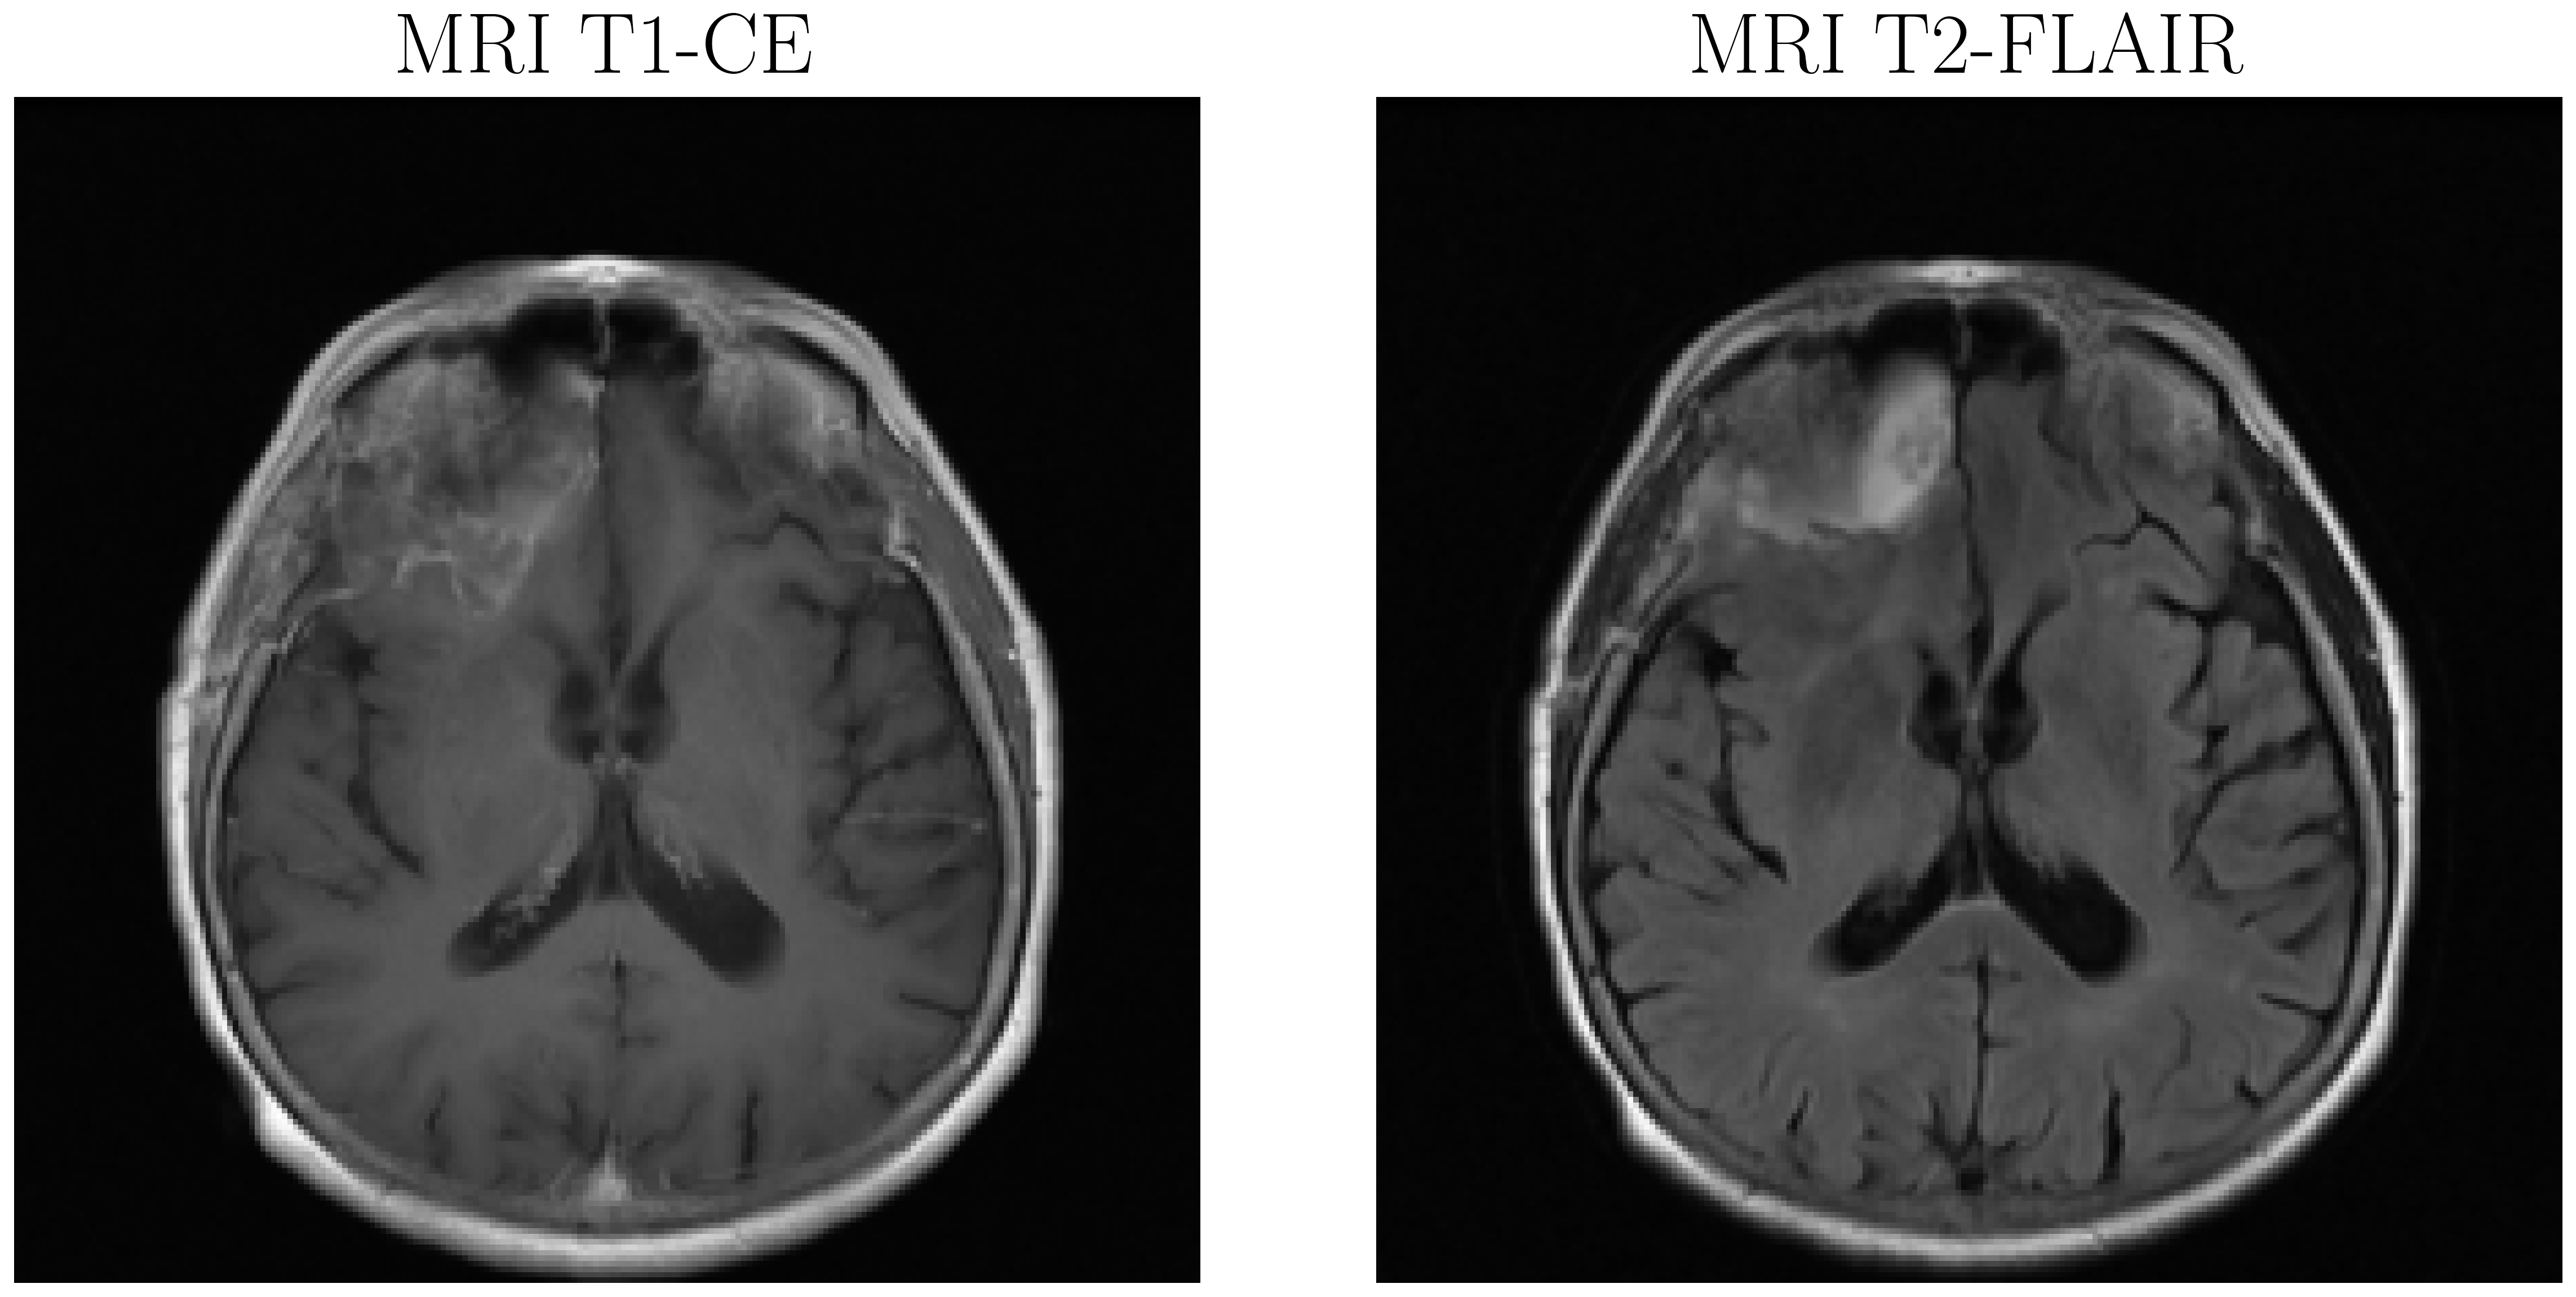

In [9]:
# Base path og pasient-ID
patient_id = 57
base_path = "Burdenko-GBM-Progression"
patient_id = f"Burdenko-GBM-{patient_id:03d}"
# Initialiser DICOMProcessor og last inn data
processor = DICOMProcessor(patient_id, base_path, verbose=False, bias_correction_enabled=False)
processor.load_all_data()

# Initialiser Plotter
plotter = Plotter(processor, verbose=False)

# Velg slice-indeks
slice_idx = 100

# Opprett subplots for MR T1 og MR T2
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot MR T1-slice
plotter.plot_mr_t1_slice(slice_idx, ax=axes[0])
axes[0].set_title('MRI T1-CE')

# Plot MR T2-slice
plotter.plot_mr_t2_slice(slice_idx, ax=axes[1])
axes[1].set_title('MRI T2-FLAIR')

# Juster layout og vis plottet
plt.tight_layout()
plt.savefig("Bilder/visualisation_before_bias.pdf")
plt.show()

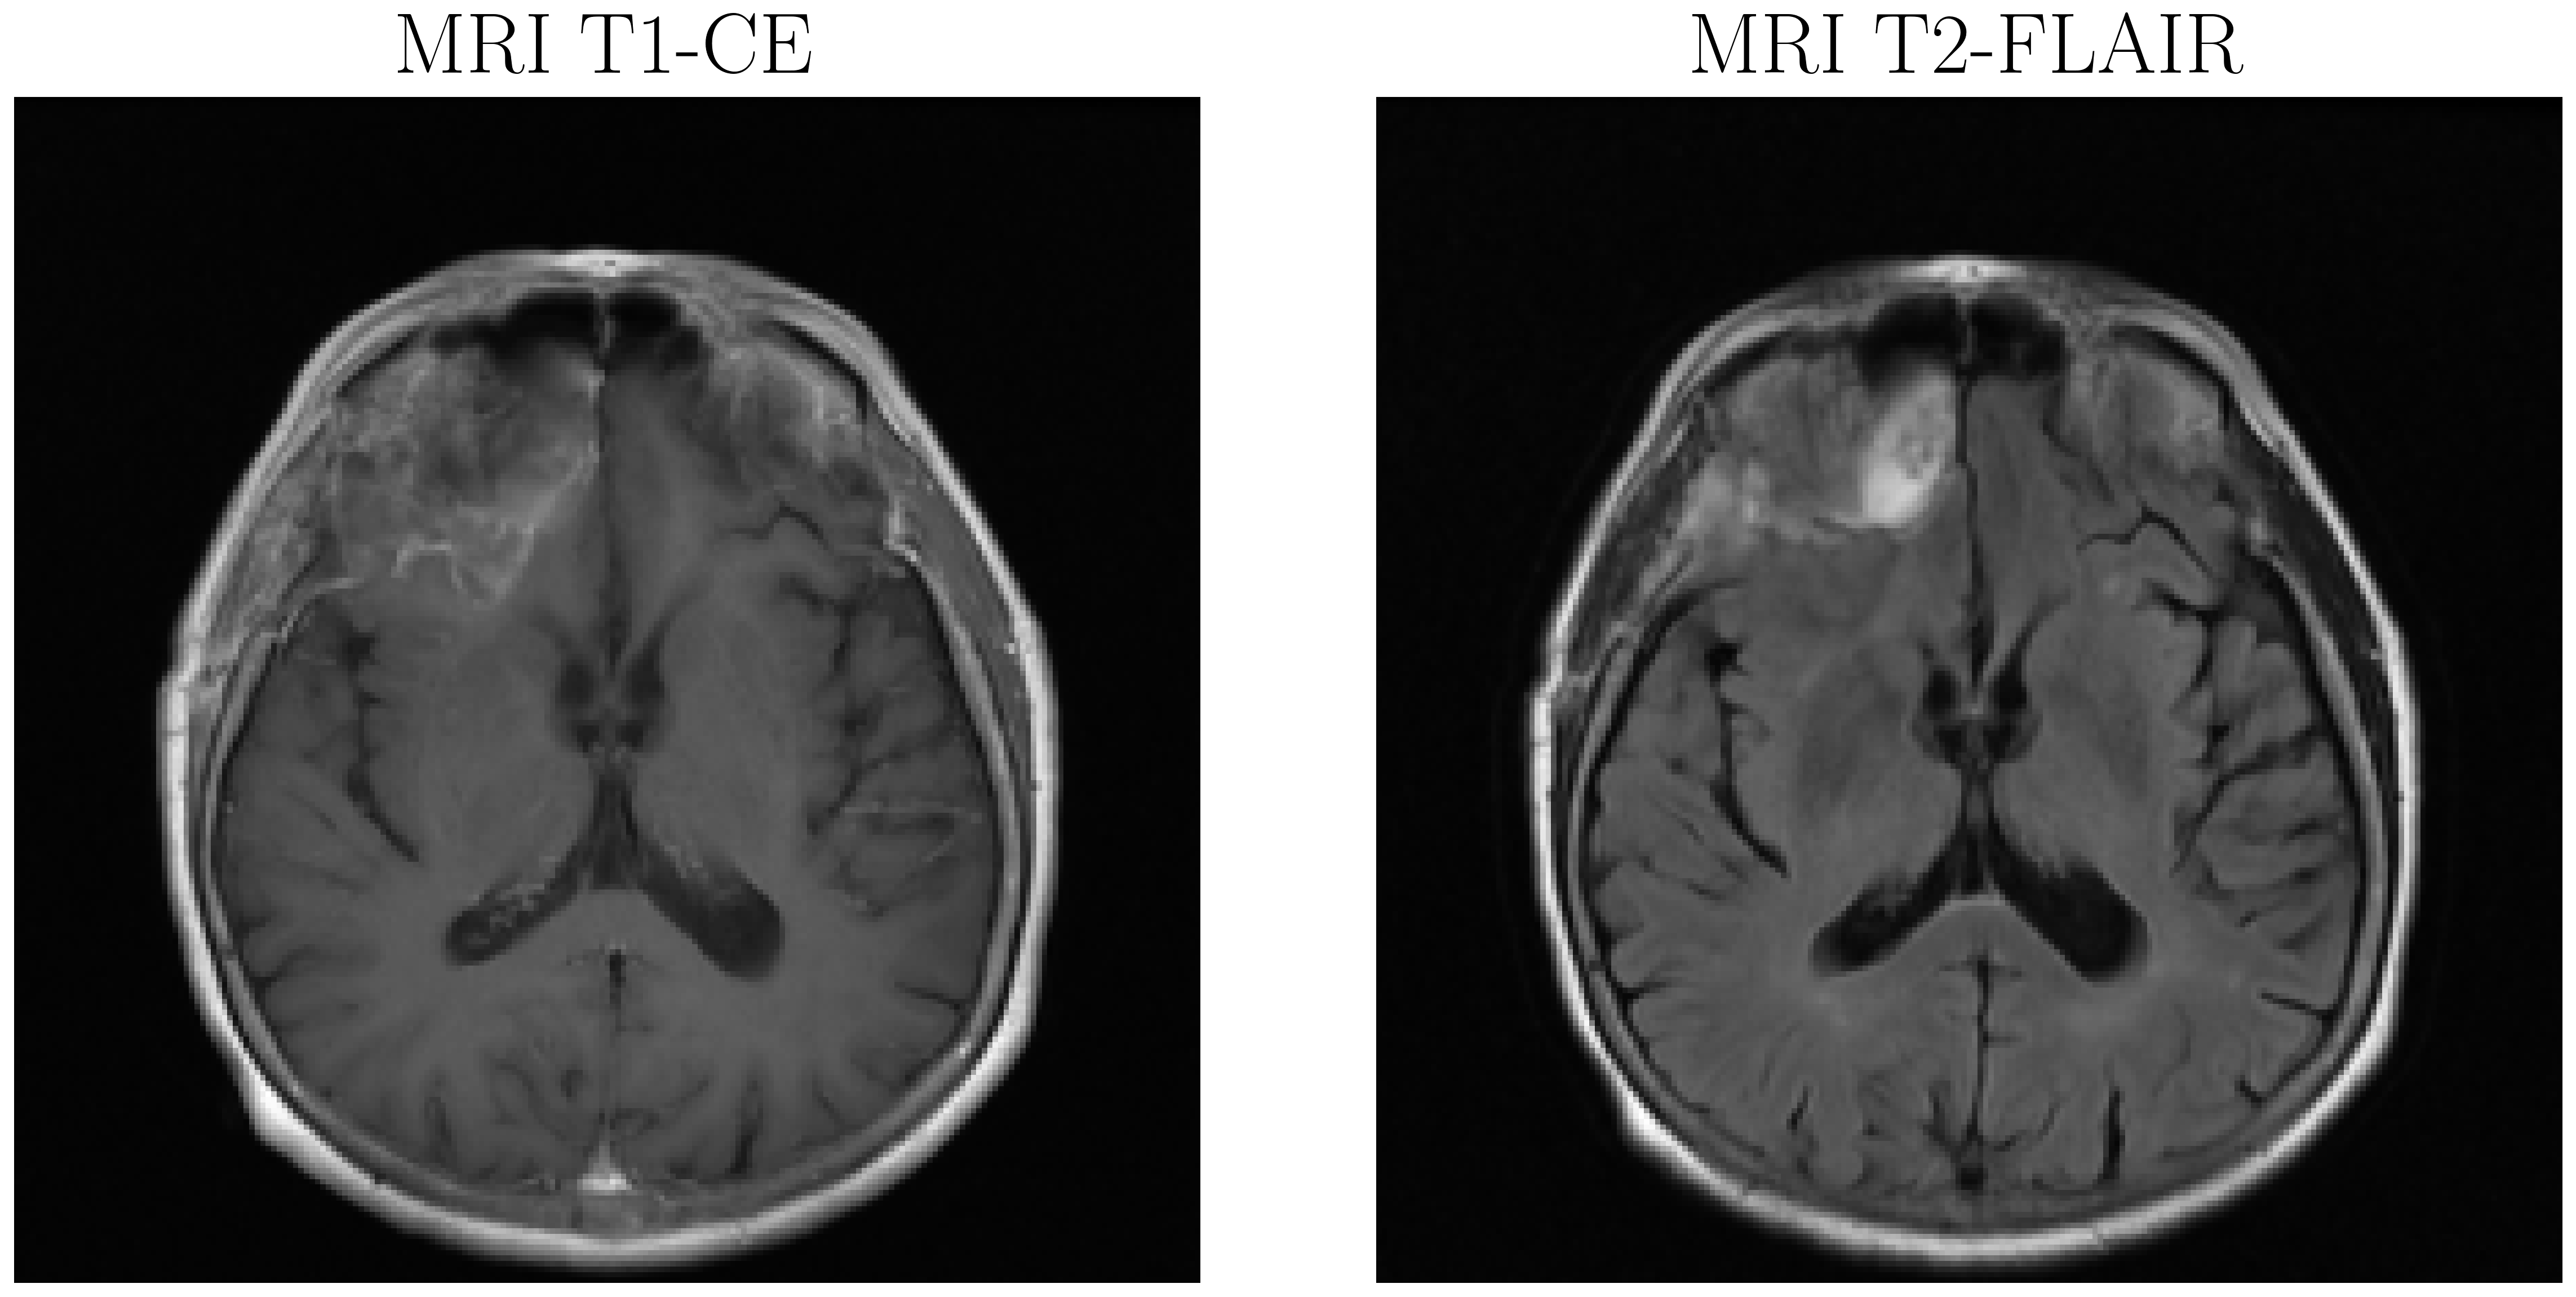

In [10]:
# Base path og pasient-ID
patient_id = 57
base_path = "Burdenko-GBM-Progression"
patient_id = f"Burdenko-GBM-{patient_id:03d}"
# Initialiser DICOMProcessor og last inn data
processor = DICOMProcessor(patient_id, base_path, verbose=False, bias_correction_enabled=True)
processor.load_all_data()

# Initialiser Plotter
plotter = Plotter(processor, verbose=False)

# Velg slice-indeks
slice_idx = 100

# Opprett subplots for MR T1 og MR T2
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot MR T1-slice
plotter.plot_mr_t1_slice(slice_idx, ax=axes[0])
axes[0].set_title('MRI T1-CE')

# Plot MR T2-slice
plotter.plot_mr_t2_slice(slice_idx, ax=axes[1])
axes[1].set_title('MRI T2-FLAIR')

# Juster layout og vis plottet
plt.tight_layout()
plt.savefig("Bilder/visualisation_after_bias.pdf")
plt.show()

In [11]:
print("Number of slices in MRI:", processor.mr_array.shape)

Number of slices in MRI: (23, 512, 512)


In [ ]:
def save_dataset_to_disk(dataset, save_path, verbose=True, start_idx=1):
    """
    Save each sample in the dataset to disk as individual .pt files.
    Starts from `start_idx` if specified.

    Args:
        dataset (torch.utils.data.Dataset): The dataset to be saved.
        save_path (str): Directory path where the samples will be saved.
        verbose (bool): If True, displays progress.
        start_idx (int): Index to start saving from.
    """
    os.makedirs(save_path, exist_ok=True)
    
    if verbose:
        print(f"Saving {len(dataset)} samples to {save_path}...")
    
    for idx in tqdm(range(len(dataset)), disable=not verbose):
        sample_path = os.path.join(save_path, f"sample_{idx + start_idx}.pt")
        if os.path.exists(sample_path):
            if verbose:
                print(f"Sample {idx + start_idx} already exists. Skipping.")
            continue  # Skip existing files
        sample = dataset[idx]
        torch.save(sample, sample_path)
    
    if verbose:
        print("Saving completed.")


def combine_pt_files(source_dir, combined_file_path, verbose=True):
    """
    Combines all .pt files in the source directory into a single dataset and saves it.

    Args:
        source_dir (str): Directory containing individual .pt files.
        combined_file_path (str): Path where the combined dataset will be saved.
        verbose (bool): If True, prints progress.
    """
    if verbose:
        print(f"Combining .pt files from {source_dir} into {combined_file_path}...")
    
    combined_data = []
    
    # List all .pt files in the source directory
    pt_files = [f for f in os.listdir(source_dir) if f.endswith('.pt')]
    
    if verbose:
        print(f"Found {len(pt_files)} '.pt' files.")
    
    for pt_file in tqdm(pt_files, disable=not verbose):
        file_path = os.path.join(source_dir, pt_file)
        sample = torch.load(file_path)
        combined_data.append(sample)
    torch.save(combined_data, combined_file_path)
    
    if verbose:
        print(f"Combined dataset saved to {combined_file_path}.")

**SURVIVAL**

In [13]:
filtered_data = pd.read_csv('filtered_data_with_dose_features.csv')

In [14]:
# Les inn CSV-filen
filtered_data_csv = 'filtered_data_survival.csv'
filtered_data = pd.read_csv(filtered_data_csv)
filtered_data['MGMT'].replace('?', np.nan, inplace=True)
# Skriv ut kolonnenavnene
print("Kolonnenavn i CSV-filen:")
print(filtered_data.columns.tolist())

Kolonnenavn i CSV-filen:
['AnonymPatientID', 'AnonymStudyDate', 'Sex', 'IDH1/2', 'MGMT', 'Response_1st_fup', 'Response_2nd_fup', 'Response_3rd_fup', 'Response_4th_fup', 'Response_5th_fup', 'Response_6th_fup', 'Response_7th_fup', 'Response_8th_fup', 'Response_9th_fup', 'Response_10th_fup', 'AnonymDate of surgery', 'AnonymStart of RT', 'AnonymEnd of RT', 'AnonymDate of topometric MRI', 'Anonym1st_fup', 'Anonym2nd_fup', 'Anonym3rd_fup', 'Anonym4th_fup', 'Anonym5th_fup', 'Anonym6th_fup', 'Anonym7th_fup', 'Anonym8th_fup', 'Anonym9th_fup', 'Anonym10th_fup', 'AnonymDeath', 'AgeAtStudyDate', 'FirstValidFollowUp', 'LastValidFollowUp', 'FirstFollowUpNumber', 'DaysToFirstValidFollowUp', 'DaysFromRTToLastFollowUp', 'Days_between_surgery_and_RT', 'num_followups', 'progression_count', 'combined_survival', 'event_observed', 'DaysFromEndRTToFirstFollowUp', 'DaysFromStudyDateToStartRT', 'PFS_months', 'PFS_event', 'Unnamed: 0', 'Patient_ID', '1_GTV=CTV_pituitary_adenoma_(T1+contr)', '2_CTV_gs+pa(+1.5cm)

/var/folders/xp/h3dtp5cs1lzd65bpc1c7z3dr0000gn/T/ipykernel_16608/1115603128.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_data['MGMT'].replace('?', np.nan, inplace=True)


## Creation of the Survival Dataset

In [15]:
base_path = "Burdenko-GBM-Progression"
gbm_dataset = GBMDataset3D_Survival(
    filtered_data_csv=filtered_data_csv,
    base_path=base_path,
    transform=None,
    verbose=False,
    cache_size=10,
    select_top_slices=True,
    num_slices=100,
    target_spacing=(1, 1, 1) # voxel spacing in mm
)

train_size = int(0.8 * len(gbm_dataset))
val_size = len(gbm_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(gbm_dataset, [train_size, val_size])
train_save_path = "PyTorch Datasets Survival/training"
val_save_path = "PyTorch Datasets Survival/validation"
combined_train_path = "PyTorch Datasets Survival/train_dataset_survival_preprocessed.pt"
combined_val_path = "PyTorch Datasets Survival/val_dataset_survival_preprocessed.pt"

#Save train dataset samples to disk
save_dataset_to_disk(train_dataset, train_save_path, verbose=True)
save_dataset_to_disk(val_dataset, val_save_path, verbose=True)
combine_pt_files(train_save_path, combined_train_path)
combine_pt_files(val_save_path, combined_val_path)

Lagrer 72 prøver til PyTorch Datasets Survival/training...


100%|██████████| 72/72 [4:08:27<00:00, 207.04s/it]  


Lagring fullført.
Lagrer 18 prøver til PyTorch Datasets Survival/validation...


100%|██████████| 18/18 [56:10<00:00, 187.25s/it] 


Lagring fullført.
Combining .pt files from PyTorch Datasets Survival/training into PyTorch Datasets Survival/train_dataset_survival_preprocessed.pt...
Found 72 '.pt'-files.


100%|██████████| 72/72 [00:09<00:00,  7.82it/s]


Combined dataset saved to PyTorch Datasets Survival/train_dataset_survival_preprocessed.pt.
Combining .pt files from PyTorch Datasets Survival/validation into PyTorch Datasets Survival/val_dataset_survival_preprocessed.pt...
Found 18 '.pt'-files.


100%|██████████| 18/18 [00:01<00:00, 11.31it/s]


Combined dataset saved to PyTorch Datasets Survival/val_dataset_survival_preprocessed.pt.


## Progression-Free Survival dataset

In [16]:
pfs_file = pd.read_csv('PFS_data.csv')
clinical_data = pd.read_csv('Burdenko-GBM-clinical-data.csv')

# Oppdater 'AnonymPatientID'-kolonnen i clinical_data slik at alle ID-er har tre sifre
clinical_data['AnonymPatientID'] = clinical_data['AnonymPatientID'].apply(
    lambda x: f"Burdenko-GBM-{int(x.split('-')[-1]):03d}"
)

# Finn felles kolonner (unntatt 'AnonymPatientID' som brukes til merge)
common_columns = [col for col in pfs_file.columns if col in clinical_data.columns and col != 'AnonymPatientID']

# Fjern de felles kolonnene fra pfs_file slik at vi ikke får duplikater
pfs_file_unique = pfs_file.drop(columns=common_columns)

# Merge dataene basert på 'AnonymPatientID'
merged_data = pd.merge(clinical_data, pfs_file_unique, on='AnonymPatientID', how='inner')

print(f"Antall pasienter etter merge (med dødsdato eller progresjon): {len(merged_data)}")
merged_data


Antall pasienter etter merge (med dødsdato eller progresjon): 170


,AnonymPatientID,AnonymStudyDate,Sex,IDH1/2,MGMT,Response_1st_fup,Response_2nd_fup,Response_3rd_fup,Response_4th_fup,Response_5th_fup,...,Anonym6th_fup,Anonym7th_fup,Anonym8th_fup,Anonym9th_fup,Anonym10th_fup,AnonymDeath,AgeAtStudyDate,PFS_months,PFS_event,Days_between_surgery_and_RT
0,Burdenko-GBM-001,5/6/04,F,negative,negative,response,stable,stable,stable,stable,...,,,,,,,51.0,10.479632,0.0,35
1,Burdenko-GBM-002,9/9/04,M,positive,positive,response,response,progression,NaN,NaN,...,,,,,,8/11/05,72.0,5.124836,1.0,151
2,Burdenko-GBM-003,9/8/04,M,NaN,NaN,progression,NaN,NaN,NaN,NaN,...,,,,,,12/5/05,64.0,2.299606,1.0,119
3,Burdenko-GBM-004,9/5/04,F,negative,positive,stable,progression,progression,NaN,NaN,...,,,,,,12/2/06,54.0,4.960578,1.0,34
4,Burdenko-GBM-005,9/11/04,F,negative,negative,stable,NaN,NaN,NaN,NaN,...,,,,,,,68.0,2.036794,0.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,Burdenko-GBM-176,1/28/05,F,negative,NaN,response,NaN,NaN,NaN,NaN,...,,,,,,,56.0,1.872536,0.0,16
166,Burdenko-GBM-177,1/28/05,F,negative,NaN,response,response,NaN,NaN,NaN,...,,,,,,,44.0,3.350854,0.0,12
167,Burdenko-GBM-178,7/10/05,M,negative,positive,progression,NaN,NaN,NaN,NaN,...,,,,,,,38.0,2.102497,1.0,43
168,Burdenko-GBM-179,7/30/04,F,negative,negative,response,stable,stable,progression,NaN,...,,,,,,,37.0,9.822602,1.0,36


In [17]:
def create_dose_parameters_csv(base_path, output_file):
    results = []
    patient_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    
    for patient_id in patient_folders:
        try:
            loader = DoseLoader(patient_id, base_path, dose_threshold_percentage=95.0, verbose=False)
            if loader.registered_dose is None:
                continue
                
            dose_array = loader.get_dose_array()
            max_dose = float(dose_array.max())
            mean_dose = float(dose_array.mean())
            
            v95 = loader.calculate_volume(loader.registered_dose, 95.0)
            v90 = loader.calculate_volume(loader.registered_dose, 90.0)
            v50 = loader.calculate_volume(loader.registered_dose, 50.0)
            v1  = loader.calculate_volume(loader.registered_dose, 1.0)
            
            # Optionally, get structure-specific metrics (e.g., for the brainstem)
            brainstem_vol = loader.get_structure_volume("brain stem")
            brainstem_dose = loader.get_structure_dose_metrics("brainstem")
            
            patient_data = {
                'patient_id': patient_id,
                'prescription_dose': loader.prescription_dose,
                'num_fractions': loader.number_of_fractions_planned,
                'max_dose': max_dose,
                'mean_dose': mean_dose,
                'V95': v95,
                'V90': v90,
                'V50': v50,
                'V1': v1,
                'brainstem_volume_cm3': brainstem_vol,
                'brainstem_mean_dose': brainstem_dose["mean_dose"] if brainstem_dose else None,
                'brainstem_max_dose': brainstem_dose["max_dose"] if brainstem_dose else None
            }
            results.append(patient_data)
            
        except Exception as e:
            print(f"Error processing patient {patient_id}: {e}")
            continue

    df = pd.DataFrame(results)
    df.to_csv(output_file, index=False)

base_path = "Burdenko-GBM-Progression"
output_file = "dose_parameters.csv"
#create_dose_parameters_csv(base_path, output_file)

In [18]:
dose_data = pd.read_csv('dose_parameters.csv')
dose_data

,patient_id,prescription_dose,num_fractions,max_dose,mean_dose,V95,V90,V50,V1,brainstem_volume_cm3,brainstem_mean_dose,brainstem_max_dose
0,Burdenko-GBM-001,63.00,30,74.504501,1.216526,0.388268,14.162727,349.456969,3387.004219,58.906757,5.984726,40.907593
1,Burdenko-GBM-002,45.00,15,46.857006,1.658306,188.709269,253.110949,449.100596,4274.242278,34.990106,8.816372,40.612152
2,Burdenko-GBM-003,60.00,30,65.167854,2.666567,168.607798,324.695592,571.541696,5015.480905,20.259015,23.251030,60.335571
3,Burdenko-GBM-004,60.00,30,62.361675,1.639953,140.807458,179.884241,326.334092,3787.597290,34.645244,21.907372,61.885330
4,Burdenko-GBM-005,60.00,30,62.996681,3.546950,251.829389,437.657818,794.038992,5048.818323,53.470767,25.346563,62.692081
...,...,...,...,...,...,...,...,...,...,...,...,...
175,Burdenko-GBM-176,60.00,30,62.667702,4.080672,211.779261,304.615708,560.595455,3851.428629,41.996533,28.971478,61.679558
176,Burdenko-GBM-177,61.35,7,14.842494,0.599236,131.483165,157.013553,284.595441,3313.145143,30.482362,1.403246,5.284849
177,Burdenko-GBM-178,60.00,30,62.265388,1.767655,189.541312,233.401170,412.750132,4587.769981,66.567859,19.722340,61.449135
178,Burdenko-GBM-179,60.00,30,67.769203,2.051861,1.187389,121.286251,283.507906,4285.944904,40.108055,9.631825,23.859385


### PFS dataset creation

In [19]:
PFS_dataset = GBMDataset3D_PFS(
    filtered_data_csv=merged_data,
    base_path='Burdenko-GBM-Progression',
    transform=None,
    verbose=True,
    cache_size=10,
    select_top_slices=True,
    num_slices=100,
    target_spacing=(1, 1, 1)
)

train_size = int(0.8 * len(PFS_dataset))
val_size = len(PFS_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(PFS_dataset, [train_size, val_size])
train_save_path = "PyTorch Datasets PFS/training"
val_save_path = "PyTorch Datasets PFS/validation"
combined_train_path = "PyTorch Datasets PFS/train_dataset_PFS_preprocessed.pt"
combined_val_path = "PyTorch Datasets PFS/val_dataset_PFS_preprocessed.pt"

save_dataset_to_disk(train_dataset, train_save_path, verbose=True)
save_dataset_to_disk(val_dataset, val_save_path, verbose=True)
combine_pt_files(train_save_path, combined_train_path)
combine_pt_files(val_save_path, combined_val_path)

Imputation of numerical features...
One-hot encoding categorical features...
Normalizing numerical features...
Lagrer 136 prøver til PyTorch Datasets PFS/training...


  0%|          | 0/136 [00:00<?, ?it/s]

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[41, 38, 85], size=[229, 229, 183]
Chose slices from 57 to 156 with total dose 769077903360.00


2025-04-27 17:21:52,470 - INFO - Processing patient Burdenko-GBM-107
2025-04-27 17:21:54,431 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-107/08-24-2004-NA-Radiotherapy planning 00-25198/3.000000-RTPLAN-95341/1-1.dcm
2025-04-27 17:21:54,518 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-107/08-24-2004-NA-Radiotherapy planning 00-25198/3.000000-RTPLAN-95341/1-1.dcm
2025-04-27 17:21:54,519 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-107/08-24-2004-NA-Radiotherapy planning 00-25198/3.000000-RTPLAN-95341/1-1.dcm
2025-04-27 17:21:54,520 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 17:21:56,601 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-107/08-24-2004-NA-Radiotherapy planning 00-25198/2.000000-CT00CT-24798 (Series ID: 1.3.6.1.4.1.14519.5.2.1.148088611288107718778668142380175024798)
2025-04-27 17:21:56,760 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[27, 26, 81], size=[211, 211, 148]
Chose slices from 24 to 123 with total dose 28092500928.00


2025-04-27 17:23:41,812 - INFO - Processing patient Burdenko-GBM-062
2025-04-27 17:23:42,595 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-062/01-31-2002-NA-Radiotherapy planning 00-27014/1.000000-RTPLAN-95894/1-1.dcm
2025-04-27 17:23:42,602 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-062/01-31-2002-NA-Radiotherapy planning 00-27014/1.000000-RTPLAN-95894/1-1.dcm
2025-04-27 17:23:42,603 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 17:23:43,543 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-062/01-31-2002-NA-Radiotherapy planning 00-27014/2.000000-CT00CT-01637 (Series ID: 1.3.6.1.4.1.14519.5.2.1.110990008563469939209015912401098601637)
2025-04-27 17:23:43,576 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-062/01-31-2002-NA-Radiotherapy planning 00-27014/1.000000-RTDOSE-05355/1-1.dcm
2025-04-27 17:23:43,606 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[40, 23, 20], size=[237, 237, 243]
Chose slices from 106 to 205 with total dose 1025800409856.00


2025-04-27 17:30:45,032 - INFO - Processing patient Burdenko-GBM-015
2025-04-27 17:30:50,782 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-015/10-04-2004-NA-Radiotherapy planning 00-49231/3.000000-RTPLAN-55657/1-1.dcm
2025-04-27 17:30:50,839 - INFO - Extracted prescription_dose 61.5 Gy from Burdenko-GBM-Progression/Burdenko-GBM-015/10-04-2004-NA-Radiotherapy planning 00-49231/3.000000-RTPLAN-55657/1-1.dcm
2025-04-27 17:30:50,840 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-015/10-04-2004-NA-Radiotherapy planning 00-49231/3.000000-RTPLAN-55657/1-1.dcm
2025-04-27 17:30:50,842 - INFO - Set prescription_dose to 61.5 Gy
2025-04-27 17:30:53,170 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-015/10-04-2004-NA-Radiotherapy planning 00-49231/2.000000-CT00CT-15891 (Series ID: 1.3.6.1.4.1.14519.5.2.1.245477495375348372440263459375997615891)
2025-04-27 17:30:53,353 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[46, 55, 32], size=[218, 218, 225]
Chose slices from 81 to 180 with total dose 793972484864.00


2025-04-27 17:39:43,817 - INFO - Processing patient Burdenko-GBM-106
2025-04-27 17:39:47,207 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-106/08-19-2004-NA-Radiotherapy planning 00-20761/3.000000-RTPLAN-70194/1-1.dcm
2025-04-27 17:39:47,287 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-106/08-19-2004-NA-Radiotherapy planning 00-20761/3.000000-RTPLAN-70194/1-1.dcm
2025-04-27 17:39:47,288 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-106/08-19-2004-NA-Radiotherapy planning 00-20761/3.000000-RTPLAN-70194/1-1.dcm
2025-04-27 17:39:47,289 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 17:39:49,422 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-106/08-19-2004-NA-Radiotherapy planning 00-20761/2.000000-CT00CT-58345 (Series ID: 1.3.6.1.4.1.14519.5.2.1.39911061246765842009335253914540958345)
2025-04-27 17:39:49,591 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[51, 72, 10], size=[213, 213, 183]
Chose slices from 62 to 161 with total dose 17588260032.00


2025-04-27 17:41:14,902 - INFO - Processing patient Burdenko-GBM-130
2025-04-27 17:41:15,531 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-130/10-15-2001-NA-Radiotherapy planning 00-39977/1.000000-RTPLAN-78253/1-1.dcm
2025-04-27 17:41:15,537 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-130/10-15-2001-NA-Radiotherapy planning 00-39977/1.000000-RTPLAN-78253/1-1.dcm
2025-04-27 17:41:15,538 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 17:41:16,386 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-130/10-15-2001-NA-Radiotherapy planning 00-39977/2.000000-CT00CT-07250 (Series ID: 1.3.6.1.4.1.14519.5.2.1.206437637188611176134336118390060807250)
2025-04-27 17:41:16,413 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-130/10-15-2001-NA-Radiotherapy planning 00-39977/1.000000-RTDOSE-96174/1-1.dcm
2025-04-27 17:41:16,441 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[59, 86, 39], size=[223, 223, 177]
Chose slices from 44 to 143 with total dose 14355979160.00


2025-04-27 17:43:18,802 - INFO - Processing patient Burdenko-GBM-121
2025-04-27 17:43:19,593 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-121/10-04-2003-NA-Radiotherapy planning 00-23022/1.000000-RTPLAN-88663/1-1.dcm
2025-04-27 17:43:19,597 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-121/10-04-2003-NA-Radiotherapy planning 00-23022/1.000000-RTPLAN-88663/1-1.dcm
2025-04-27 17:43:19,598 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 17:43:20,523 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-121/10-04-2003-NA-Radiotherapy planning 00-23022/2.000000-CT00CT-02346 (Series ID: 1.3.6.1.4.1.14519.5.2.1.279659237806512441670268232939894202346)
2025-04-27 17:43:20,555 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-121/10-04-2003-NA-Radiotherapy planning 00-23022/1.000000-RTDOSE-54974/1-1.dcm
2025-04-27 17:43:20,589 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[34, 20, 69], size=[232, 232, 182]
Chose slices from 41 to 140 with total dose 900185944832.00


2025-04-27 17:45:50,634 - INFO - Processing patient Burdenko-GBM-136
2025-04-27 17:45:52,575 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-136/05-20-2004-NA-Radiotherapy planning 00-23023/3.000000-RTPLAN-44839/1-1.dcm
2025-04-27 17:45:52,620 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-136/05-20-2004-NA-Radiotherapy planning 00-23023/3.000000-RTPLAN-44839/1-1.dcm
2025-04-27 17:45:52,621 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-136/05-20-2004-NA-Radiotherapy planning 00-23023/3.000000-RTPLAN-44839/1-1.dcm
2025-04-27 17:45:52,622 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 17:45:53,638 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-136/05-20-2004-NA-Radiotherapy planning 00-23023/2.000000-CT00CT-95099 (Series ID: 1.3.6.1.4.1.14519.5.2.1.337550549630669770500385082872377295099)
2025-04-27 17:45:53,672 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[59, 67, 0], size=[234, 234, 206]
Chose slices from 69 to 168 with total dose 21427011928.00


2025-04-27 17:51:35,832 - INFO - Processing patient Burdenko-GBM-122
2025-04-27 17:51:41,531 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-122/10-06-2003-NA-Radiotherapy planning 00-70599/1.000000-RTPLAN-02492/1-1.dcm
2025-04-27 17:51:41,536 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-122/10-06-2003-NA-Radiotherapy planning 00-70599/1.000000-RTPLAN-02492/1-1.dcm
2025-04-27 17:51:41,537 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 17:51:42,418 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-122/10-06-2003-NA-Radiotherapy planning 00-70599/2.000000-CT00CT-50475 (Series ID: 1.3.6.1.4.1.14519.5.2.1.272365445061892881918490121540115450475)
2025-04-27 17:51:42,444 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-122/10-06-2003-NA-Radiotherapy planning 00-70599/1.000000-RTDOSE-09048/1-1.dcm
2025-04-27 17:51:42,473 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[29, 27, 0], size=[228, 228, 211]
Chose slices from 100 to 199 with total dose 22743974672.00


2025-04-27 17:55:57,593 - INFO - Processing patient Burdenko-GBM-038
2025-04-27 17:55:59,747 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-038/11-03-2003-NA-Radiotherapy planning 00-07835/1.000000-RTPLAN-07818/1-1.dcm
2025-04-27 17:55:59,753 - INFO - Extracted NumberOfFractionsPlanned 28 from Burdenko-GBM-Progression/Burdenko-GBM-038/11-03-2003-NA-Radiotherapy planning 00-07835/1.000000-RTPLAN-07818/1-1.dcm
2025-04-27 17:55:59,754 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 17:56:00,835 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-038/11-03-2003-NA-Radiotherapy planning 00-07835/2.000000-CT00CT-83220 (Series ID: 1.3.6.1.4.1.14519.5.2.1.89126251380598391277938259673127783220)
2025-04-27 17:56:00,870 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-038/11-03-2003-NA-Radiotherapy planning 00-07835/1.000000-RTDOSE-16019/1-1.dcm
2025-04-27 17:56:00,904 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[30, 25, 67], size=[222, 222, 182]
Chose slices from 69 to 168 with total dose 19490047804.00


2025-04-27 17:57:50,117 - INFO - Processing patient Burdenko-GBM-080
2025-04-27 17:57:50,984 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-080/06-02-2002-NA-Radiotherapy planning 00-06849/1.000000-RTPLAN-58977/1-1.dcm
2025-04-27 17:57:50,990 - INFO - Extracted NumberOfFractionsPlanned 15 from Burdenko-GBM-Progression/Burdenko-GBM-080/06-02-2002-NA-Radiotherapy planning 00-06849/1.000000-RTPLAN-58977/1-1.dcm
2025-04-27 17:57:50,991 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 17:57:52,026 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-080/06-02-2002-NA-Radiotherapy planning 00-06849/2.000000-CT00CT-50995 (Series ID: 1.3.6.1.4.1.14519.5.2.1.160160650050428880425625277393122150995)
2025-04-27 17:57:52,060 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-080/06-02-2002-NA-Radiotherapy planning 00-06849/1.000000-RTDOSE-57627/1-1.dcm
2025-04-27 17:57:52,091 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[67, 74, 24], size=[216, 216, 173]
Chose slices from 53 to 152 with total dose 20026799568.00


2025-04-27 17:59:36,351 - INFO - Processing patient Burdenko-GBM-057
2025-04-27 17:59:37,018 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-057/12-19-2002-NA-Radiotherapy planning 00-24129/1.000000-RTPLAN-43027/1-1.dcm
2025-04-27 17:59:37,023 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-057/12-19-2002-NA-Radiotherapy planning 00-24129/1.000000-RTPLAN-43027/1-1.dcm
2025-04-27 17:59:37,024 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 17:59:37,830 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-057/12-19-2002-NA-Radiotherapy planning 00-24129/2.000000-CT00CT-89088 (Series ID: 1.3.6.1.4.1.14519.5.2.1.85448818550007840563724934900371989088)
2025-04-27 17:59:37,857 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-057/12-19-2002-NA-Radiotherapy planning 00-24129/1.000000-RTDOSE-71028/1-1.dcm
2025-04-27 17:59:37,887 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[13, 10, 73], size=[222, 222, 155]
Chose slices from 31 to 130 with total dose 727975735808.00


2025-04-27 18:03:58,555 - INFO - Processing patient Burdenko-GBM-173
2025-04-27 18:04:00,040 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-173/01-11-2005-NA-Radiotherapy planning 00-87088/3.000000-RTPLAN-30113/1-1.dcm
2025-04-27 18:04:00,092 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-173/01-11-2005-NA-Radiotherapy planning 00-87088/3.000000-RTPLAN-30113/1-1.dcm
2025-04-27 18:04:00,092 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-173/01-11-2005-NA-Radiotherapy planning 00-87088/3.000000-RTPLAN-30113/1-1.dcm
2025-04-27 18:04:00,094 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 18:04:02,376 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-173/01-11-2005-NA-Radiotherapy planning 00-87088/2.000000-CT00CT-63239 (Series ID: 1.3.6.1.4.1.14519.5.2.1.68555382806600364397443899353800163239)
2025-04-27 18:04:02,553 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[28, 20, 37], size=[225, 225, 174]
Chose slices from 33 to 132 with total dose 30350038192.00


2025-04-27 18:05:51,705 - INFO - Processing patient Burdenko-GBM-040
2025-04-27 18:05:52,394 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-040/11-30-2000-NA-Radiotherapy planning 00-29335/1.000000-RTPLAN-36992/1-1.dcm
2025-04-27 18:05:52,399 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-040/11-30-2000-NA-Radiotherapy planning 00-29335/1.000000-RTPLAN-36992/1-1.dcm
2025-04-27 18:05:52,399 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 18:05:53,296 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-040/11-30-2000-NA-Radiotherapy planning 00-29335/2.000000-CT00CT-79031 (Series ID: 1.3.6.1.4.1.14519.5.2.1.217369547620815672029054281500099179031)
2025-04-27 18:05:53,326 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-040/11-30-2000-NA-Radiotherapy planning 00-29335/1.000000-RTDOSE-31904/1-1.dcm
2025-04-27 18:05:53,357 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[42, 31, 40], size=[212, 212, 172]
Chose slices from 38 to 137 with total dose 19871720408.00


2025-04-27 18:08:23,200 - INFO - Processing patient Burdenko-GBM-087
2025-04-27 18:08:24,207 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-087/07-06-2001-NA-Radiotherapy planning 00-26147/1.000000-RTPLAN-94113/1-1.dcm
2025-04-27 18:08:24,216 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-087/07-06-2001-NA-Radiotherapy planning 00-26147/1.000000-RTPLAN-94113/1-1.dcm
2025-04-27 18:08:24,217 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 18:08:25,092 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-087/07-06-2001-NA-Radiotherapy planning 00-26147/2.000000-CT00CT-76494 (Series ID: 1.3.6.1.4.1.14519.5.2.1.53508065009693461270534998540418376494)
2025-04-27 18:08:25,121 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-087/07-06-2001-NA-Radiotherapy planning 00-26147/1.000000-RTDOSE-03817/1-1.dcm
2025-04-27 18:08:25,150 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[60, 66, 42], size=[233, 233, 176]
Chose slices from 58 to 157 with total dose 28954322256.00


2025-04-27 18:10:40,507 - INFO - Processing patient Burdenko-GBM-092
2025-04-27 18:10:41,403 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-092/06-19-2003-NA-Radiotherapy planning 00-49947/1.000000-RTPLAN-67061/1-1.dcm
2025-04-27 18:10:41,412 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-092/06-19-2003-NA-Radiotherapy planning 00-49947/1.000000-RTPLAN-67061/1-1.dcm
2025-04-27 18:10:41,414 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 18:10:42,389 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-092/06-19-2003-NA-Radiotherapy planning 00-49947/2.000000-CT00CT-99549 (Series ID: 1.3.6.1.4.1.14519.5.2.1.59969225878075876571871344009446699549)
2025-04-27 18:10:42,423 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-092/06-19-2003-NA-Radiotherapy planning 00-49947/1.000000-RTDOSE-15771/1-1.dcm
2025-04-27 18:10:42,453 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[39, 54, 83], size=[220, 220, 167]
Chose slices from 34 to 133 with total dose 918001110784.00


2025-04-27 18:15:23,888 - INFO - Processing patient Burdenko-GBM-009
2025-04-27 18:15:25,875 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-009/09-23-2004-NA-Radiotherapy planning 00-44046/3.000000-RTPLAN-35504/1-1.dcm
2025-04-27 18:15:25,929 - INFO - Extracted prescription_dose 61.2 Gy from Burdenko-GBM-Progression/Burdenko-GBM-009/09-23-2004-NA-Radiotherapy planning 00-44046/3.000000-RTPLAN-35504/1-1.dcm
2025-04-27 18:15:25,929 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-009/09-23-2004-NA-Radiotherapy planning 00-44046/3.000000-RTPLAN-35504/1-1.dcm
2025-04-27 18:15:25,931 - INFO - Set prescription_dose to 61.2 Gy
2025-04-27 18:15:28,081 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-009/09-23-2004-NA-Radiotherapy planning 00-44046/2.000000-CT00CT-42190 (Series ID: 1.3.6.1.4.1.14519.5.2.1.267680109087183256795945041815853142190)
2025-04-27 18:15:28,244 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[28, 35, 0], size=[231, 231, 220]
Chose slices from 91 to 190 with total dose 991534167040.00


2025-04-27 18:17:37,817 - INFO - Processing patient Burdenko-GBM-166
2025-04-27 18:17:38,433 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-166/12-09-2004-NA-Radiotherapy planning 00-63675/3.000000-RTPLAN-81128/1-1.dcm
2025-04-27 18:17:38,487 - INFO - Extracted prescription_dose 45.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-166/12-09-2004-NA-Radiotherapy planning 00-63675/3.000000-RTPLAN-81128/1-1.dcm
2025-04-27 18:17:38,488 - INFO - Extracted NumberOfFractionsPlanned 15 from Burdenko-GBM-Progression/Burdenko-GBM-166/12-09-2004-NA-Radiotherapy planning 00-63675/3.000000-RTPLAN-81128/1-1.dcm
2025-04-27 18:17:38,489 - INFO - Set prescription_dose to 45.0 Gy
2025-04-27 18:17:40,229 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-166/12-09-2004-NA-Radiotherapy planning 00-63675/2.000000-CT00CT-19231 (Series ID: 1.3.6.1.4.1.14519.5.2.1.332015118824222576972753565045769519231)
2025-04-27 18:17:40,401 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[44, 26, 0], size=[233, 233, 246]
Chose slices from 100 to 199 with total dose 779312973824.00


2025-04-27 18:20:12,055 - INFO - Processing patient Burdenko-GBM-139
2025-04-27 18:20:13,443 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-139/06-03-2004-NA-Radiotherapy planning 00-28659/3.000000-RTPLAN-30868/1-1.dcm
2025-04-27 18:20:13,485 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-139/06-03-2004-NA-Radiotherapy planning 00-28659/3.000000-RTPLAN-30868/1-1.dcm
2025-04-27 18:20:13,486 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-139/06-03-2004-NA-Radiotherapy planning 00-28659/3.000000-RTPLAN-30868/1-1.dcm
2025-04-27 18:20:13,487 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 18:20:14,583 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-139/06-03-2004-NA-Radiotherapy planning 00-28659/2.000000-CT00CT-68050 (Series ID: 1.3.6.1.4.1.14519.5.2.1.267678649716277928330088347032371468050)
2025-04-27 18:20:14,617 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[15, 14, 75], size=[255, 255, 180]
Chose slices from 45 to 144 with total dose 644787233280.00


2025-04-27 18:22:54,576 - INFO - Processing patient Burdenko-GBM-148
2025-04-27 18:22:56,463 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-148/07-10-2004-NA-Radiotherapy planning 00-07191/3.000000-RTPLAN-61120/1-1.dcm
2025-04-27 18:22:56,514 - INFO - Extracted prescription_dose 46.3802177582197 Gy from Burdenko-GBM-Progression/Burdenko-GBM-148/07-10-2004-NA-Radiotherapy planning 00-07191/3.000000-RTPLAN-61120/1-1.dcm
2025-04-27 18:22:56,514 - INFO - Extracted NumberOfFractionsPlanned 15 from Burdenko-GBM-Progression/Burdenko-GBM-148/07-10-2004-NA-Radiotherapy planning 00-07191/3.000000-RTPLAN-61120/1-1.dcm
2025-04-27 18:22:56,515 - INFO - Set prescription_dose to 46.3802177582197 Gy
2025-04-27 18:22:58,571 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-148/07-10-2004-NA-Radiotherapy planning 00-07191/2.000000-CT00CT-24061 (Series ID: 1.3.6.1.4.1.14519.5.2.1.146669433333330390720911389182771824061)
2025-04-27 18:22:58,733 - INFO - Proces

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[36, 28, 55], size=[210, 210, 165]
Chose slices from 46 to 145 with total dose 26871099328.00


2025-04-27 18:24:17,013 - INFO - Processing patient Burdenko-GBM-096
2025-04-27 18:24:17,713 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-096/07-20-2003-NA-Radiotherapy planning 00-38353/1.000000-RTPLAN-68822/1-1.dcm
2025-04-27 18:24:17,719 - INFO - Extracted NumberOfFractionsPlanned 23 from Burdenko-GBM-Progression/Burdenko-GBM-096/07-20-2003-NA-Radiotherapy planning 00-38353/1.000000-RTPLAN-68822/1-1.dcm
2025-04-27 18:24:17,720 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 18:24:18,676 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-096/07-20-2003-NA-Radiotherapy planning 00-38353/2.000000-CT00CT-24634 (Series ID: 1.3.6.1.4.1.14519.5.2.1.305131605859456362042739586958906224634)
2025-04-27 18:24:18,707 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-096/07-20-2003-NA-Radiotherapy planning 00-38353/1.000000-RTDOSE-73842/1-1.dcm
2025-04-27 18:24:18,737 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[48, 52, 80], size=[196, 196, 152]
Chose slices from 38 to 137 with total dose 857522302720.00


2025-04-27 18:26:29,445 - INFO - Processing patient Burdenko-GBM-134
2025-04-27 18:26:31,182 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-134/02-06-2005-NA-Radiotherapy planning 00-21742/3.000000-RTPLAN-80398/1-1.dcm
2025-04-27 18:26:31,238 - INFO - Extracted prescription_dose 45.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-134/02-06-2005-NA-Radiotherapy planning 00-21742/3.000000-RTPLAN-80398/1-1.dcm
2025-04-27 18:26:31,239 - INFO - Extracted NumberOfFractionsPlanned 15 from Burdenko-GBM-Progression/Burdenko-GBM-134/02-06-2005-NA-Radiotherapy planning 00-21742/3.000000-RTPLAN-80398/1-1.dcm
2025-04-27 18:26:31,241 - INFO - Set prescription_dose to 45.0 Gy
2025-04-27 18:26:33,171 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-134/02-06-2005-NA-Radiotherapy planning 00-21742/2.000000-CT00CT-02425 (Series ID: 1.3.6.1.4.1.14519.5.2.1.218310083768851353570252540760629702425)
2025-04-27 18:26:33,315 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[43, 37, 51], size=[209, 209, 173]
Chose slices from 45 to 144 with total dose 628169438208.00


2025-04-27 18:31:59,327 - INFO - Processing patient Burdenko-GBM-141
2025-04-27 18:32:03,629 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-141/06-24-2004-NA-Radiotherapy planning 00-57205/3.000000-RTPLAN-22515/1-1.dcm
2025-04-27 18:32:03,680 - INFO - Extracted prescription_dose 61.3725674602557 Gy from Burdenko-GBM-Progression/Burdenko-GBM-141/06-24-2004-NA-Radiotherapy planning 00-57205/3.000000-RTPLAN-22515/1-1.dcm
2025-04-27 18:32:03,681 - INFO - Extracted NumberOfFractionsPlanned 10 from Burdenko-GBM-Progression/Burdenko-GBM-141/06-24-2004-NA-Radiotherapy planning 00-57205/3.000000-RTPLAN-22515/1-1.dcm
2025-04-27 18:32:03,682 - INFO - Set prescription_dose to 61.3725674602557 Gy
2025-04-27 18:32:05,683 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-141/06-24-2004-NA-Radiotherapy planning 00-57205/2.000000-CT00CT-01886 (Series ID: 1.3.6.1.4.1.14519.5.2.1.124198430859518220773959056954678901886)
2025-04-27 18:32:05,843 - INFO - Proces

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[49, 41, 88], size=[197, 197, 176]
Chose slices from 55 to 154 with total dose 798052278016.00


2025-04-27 18:34:31,639 - INFO - Processing patient Burdenko-GBM-020
2025-04-27 18:34:33,920 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-020/10-17-2004-NA-Radiotherapy planning 00-40949/3.000000-RTPLAN-81425/1-1.dcm
2025-04-27 18:34:33,981 - INFO - Extracted prescription_dose 36.9 Gy from Burdenko-GBM-Progression/Burdenko-GBM-020/10-17-2004-NA-Radiotherapy planning 00-40949/3.000000-RTPLAN-81425/1-1.dcm
2025-04-27 18:34:33,981 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-020/10-17-2004-NA-Radiotherapy planning 00-40949/3.000000-RTPLAN-81425/1-1.dcm
2025-04-27 18:34:33,983 - INFO - Set prescription_dose to 36.9 Gy
2025-04-27 18:34:36,522 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-020/10-17-2004-NA-Radiotherapy planning 00-40949/2.000000-CT00CT-53766 (Series ID: 1.3.6.1.4.1.14519.5.2.1.97601549706983517325368580290825853766)
2025-04-27 18:34:36,750 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[21, 41, 0], size=[221, 221, 257]
Chose slices from 140 to 239 with total dose 760529254912.00


2025-04-27 18:42:48,392 - INFO - Processing patient Burdenko-GBM-149
2025-04-27 18:42:51,489 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-149/07-10-2004-NA-Radiotherapy planning 00-11350/3.000000-RTPLAN-48690/1-1.dcm
2025-04-27 18:42:51,544 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-149/07-10-2004-NA-Radiotherapy planning 00-11350/3.000000-RTPLAN-48690/1-1.dcm
2025-04-27 18:42:51,545 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-149/07-10-2004-NA-Radiotherapy planning 00-11350/3.000000-RTPLAN-48690/1-1.dcm
2025-04-27 18:42:51,546 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 18:42:53,848 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-149/07-10-2004-NA-Radiotherapy planning 00-11350/2.000000-CT00CT-02429 (Series ID: 1.3.6.1.4.1.14519.5.2.1.339903844608000560742592192096577902429)
2025-04-27 18:42:54,034 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[57, 39, 8], size=[221, 221, 251]
Chose slices from 104 to 203 with total dose 722815316480.00


2025-04-27 18:51:45,208 - INFO - Processing patient Burdenko-GBM-178
2025-04-27 18:51:48,462 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-178/07-10-2005-NA-Radiotherapy planning 00-13909/3.000000-RTPLAN-64177/1-1.dcm
2025-04-27 18:51:48,519 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-178/07-10-2005-NA-Radiotherapy planning 00-13909/3.000000-RTPLAN-64177/1-1.dcm
2025-04-27 18:51:48,520 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-178/07-10-2005-NA-Radiotherapy planning 00-13909/3.000000-RTPLAN-64177/1-1.dcm
2025-04-27 18:51:48,522 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 18:51:50,849 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-178/07-10-2005-NA-Radiotherapy planning 00-13909/2.000000-CT00CT-48129 (Series ID: 1.3.6.1.4.1.14519.5.2.1.105298092945252540981863706010491048129)
2025-04-27 18:51:51,027 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[68, 79, 4], size=[220, 220, 189]
Chose slices from 67 to 166 with total dose 30970256240.00


2025-04-27 18:53:19,883 - INFO - Processing patient Burdenko-GBM-060
2025-04-27 18:53:20,530 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-060/01-31-2002-NA-Radiotherapy planning 00-18117/1.000000-RTPLAN-29876/1-1.dcm
2025-04-27 18:53:20,534 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-060/01-31-2002-NA-Radiotherapy planning 00-18117/1.000000-RTPLAN-29876/1-1.dcm
2025-04-27 18:53:20,534 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 18:53:21,329 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-060/01-31-2002-NA-Radiotherapy planning 00-18117/2.000000-CT00CT-80561 (Series ID: 1.3.6.1.4.1.14519.5.2.1.83159438234418163324418636921702980561)
2025-04-27 18:53:21,351 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-060/01-31-2002-NA-Radiotherapy planning 00-18117/1.000000-RTDOSE-10208/1-1.dcm
2025-04-27 18:53:21,377 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[46, 37, 74], size=[223, 223, 177]
Chose slices from 66 to 165 with total dose 899747128576.00


2025-04-27 18:56:14,076 - INFO - Processing patient Burdenko-GBM-017
2025-04-27 18:56:15,837 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-017/10-14-2004-NA-Radiotherapy planning 00-37777/3.000000-RTPLAN-09559/1-1.dcm
2025-04-27 18:56:15,892 - INFO - Extracted prescription_dose 61.5 Gy from Burdenko-GBM-Progression/Burdenko-GBM-017/10-14-2004-NA-Radiotherapy planning 00-37777/3.000000-RTPLAN-09559/1-1.dcm
2025-04-27 18:56:15,893 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-017/10-14-2004-NA-Radiotherapy planning 00-37777/3.000000-RTPLAN-09559/1-1.dcm
2025-04-27 18:56:15,894 - INFO - Set prescription_dose to 61.5 Gy
2025-04-27 18:56:18,080 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-017/10-14-2004-NA-Radiotherapy planning 00-37777/2.000000-CT00CT-39761 (Series ID: 1.3.6.1.4.1.14519.5.2.1.290362199865808574805199862300444439761)
2025-04-27 18:56:18,242 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[63, 60, 49], size=[229, 229, 162]
Chose slices from 45 to 144 with total dose 22836056936.00


2025-04-27 19:02:41,783 - INFO - Processing patient Burdenko-GBM-094
2025-04-27 19:02:43,881 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-094/07-03-2002-NA-Radiotherapy planning 00-14350/1.000000-RTPLAN-39871/1-1.dcm
2025-04-27 19:02:43,886 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-094/07-03-2002-NA-Radiotherapy planning 00-14350/1.000000-RTPLAN-39871/1-1.dcm
2025-04-27 19:02:43,887 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 19:02:44,828 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-094/07-03-2002-NA-Radiotherapy planning 00-14350/2.000000-CT00CT-83218 (Series ID: 1.3.6.1.4.1.14519.5.2.1.86750826230213453365634200609631183218)
2025-04-27 19:02:44,856 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-094/07-03-2002-NA-Radiotherapy planning 00-14350/1.000000-RTDOSE-35301/1-1.dcm
2025-04-27 19:02:44,890 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[16, 5, 30], size=[209, 209, 189]
Chose slices from 61 to 160 with total dose 29648819664.00


2025-04-27 19:04:34,544 - INFO - Processing patient Burdenko-GBM-031
2025-04-27 19:04:35,334 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-031/08-16-2000-NA-Radiotherapy planning 00-01605/1.000000-RTPLAN-90731/1-1.dcm
2025-04-27 19:04:35,340 - INFO - Extracted NumberOfFractionsPlanned 25 from Burdenko-GBM-Progression/Burdenko-GBM-031/08-16-2000-NA-Radiotherapy planning 00-01605/1.000000-RTPLAN-90731/1-1.dcm
2025-04-27 19:04:35,340 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 19:04:36,322 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-031/08-16-2000-NA-Radiotherapy planning 00-01605/2.000000-CT00CT-70194 (Series ID: 1.3.6.1.4.1.14519.5.2.1.90192796271790034369833261304342270194)
2025-04-27 19:04:36,363 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-031/08-16-2000-NA-Radiotherapy planning 00-01605/1.000000-RTDOSE-25917/1-1.dcm
2025-04-27 19:04:36,393 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[30, 24, 62], size=[201, 201, 148]
Chose slices from 24 to 123 with total dose 22567894016.00


2025-04-27 19:08:27,396 - INFO - Processing patient Burdenko-GBM-046
2025-04-27 19:08:29,335 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-046/04-15-2000-NA-Radiotherapy planning 00-79817/1.000000-RTPLAN-30583/1-1.dcm
2025-04-27 19:08:29,342 - INFO - Extracted NumberOfFractionsPlanned 31 from Burdenko-GBM-Progression/Burdenko-GBM-046/04-15-2000-NA-Radiotherapy planning 00-79817/1.000000-RTPLAN-30583/1-1.dcm
2025-04-27 19:08:29,342 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 19:08:30,170 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-046/04-15-2000-NA-Radiotherapy planning 00-79817/2.000000-CT00CT-37418 (Series ID: 1.3.6.1.4.1.14519.5.2.1.33035388652265782010984411021442537418)
2025-04-27 19:08:30,197 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-046/04-15-2000-NA-Radiotherapy planning 00-79817/1.000000-RTDOSE-15289/1-1.dcm
2025-04-27 19:08:30,228 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[60, 75, 27], size=[223, 223, 181]
Chose slices from 35 to 134 with total dose 21906551072.00


2025-04-27 19:10:09,477 - INFO - Processing patient Burdenko-GBM-035
2025-04-27 19:10:10,762 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-035/10-26-2003-NA-Radiotherapy planning 00-62690/1.000000-RTPLAN-50352/1-1.dcm
2025-04-27 19:10:10,767 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-035/10-26-2003-NA-Radiotherapy planning 00-62690/1.000000-RTPLAN-50352/1-1.dcm
2025-04-27 19:10:10,768 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 19:10:11,626 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-035/10-26-2003-NA-Radiotherapy planning 00-62690/2.000000-CT00CT-30496 (Series ID: 1.3.6.1.4.1.14519.5.2.1.277218183742431403190563665257849830496)
2025-04-27 19:10:11,659 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-035/10-26-2003-NA-Radiotherapy planning 00-62690/1.000000-RTDOSE-23817/1-1.dcm
2025-04-27 19:10:11,690 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[48, 53, 45], size=[235, 235, 181]
Chose slices from 68 to 167 with total dose 21224500392.00


2025-04-27 19:12:29,465 - INFO - Processing patient Burdenko-GBM-043
2025-04-27 19:12:30,778 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-043/10-04-2002-NA-Radiotherapy planning 00-08822/1.000000-RTPLAN-70888/1-1.dcm
2025-04-27 19:12:30,783 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-043/10-04-2002-NA-Radiotherapy planning 00-08822/1.000000-RTPLAN-70888/1-1.dcm
2025-04-27 19:12:30,784 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 19:12:31,662 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-043/10-04-2002-NA-Radiotherapy planning 00-08822/2.000000-CT00CT-99952 (Series ID: 1.3.6.1.4.1.14519.5.2.1.88753881270924439826869629150691099952)
2025-04-27 19:12:31,693 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-043/10-04-2002-NA-Radiotherapy planning 00-08822/1.000000-RTDOSE-38059/1-1.dcm
2025-04-27 19:12:31,725 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[46, 41, 19], size=[218, 218, 236]
Chose slices from 116 to 215 with total dose 1034306838528.00


2025-04-27 19:21:16,825 - INFO - Processing patient Burdenko-GBM-172
2025-04-27 19:21:20,385 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-172/01-21-2005-NA-Radiotherapy planning 00-84892/3.000000-RTPLAN-29655/1-1.dcm
2025-04-27 19:21:20,441 - INFO - Extracted prescription_dose 61.2 Gy from Burdenko-GBM-Progression/Burdenko-GBM-172/01-21-2005-NA-Radiotherapy planning 00-84892/3.000000-RTPLAN-29655/1-1.dcm
2025-04-27 19:21:20,442 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-172/01-21-2005-NA-Radiotherapy planning 00-84892/3.000000-RTPLAN-29655/1-1.dcm
2025-04-27 19:21:20,443 - INFO - Set prescription_dose to 61.2 Gy
2025-04-27 19:21:22,878 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-172/01-21-2005-NA-Radiotherapy planning 00-84892/2.000000-CT00CT-12036 (Series ID: 1.3.6.1.4.1.14519.5.2.1.128708665318726122673192520440388012036)
2025-04-27 19:21:23,051 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[40, 40, 83], size=[220, 220, 168]
Chose slices from 25 to 124 with total dose 1024470471424.00


2025-04-27 19:24:23,729 - INFO - Processing patient Burdenko-GBM-158
2025-04-27 19:24:26,036 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-158/11-24-2004-NA-Radiotherapy planning 00-06147/3.000000-RTPLAN-37004/1-1.dcm
2025-04-27 19:24:26,087 - INFO - Extracted prescription_dose 61.5 Gy from Burdenko-GBM-Progression/Burdenko-GBM-158/11-24-2004-NA-Radiotherapy planning 00-06147/3.000000-RTPLAN-37004/1-1.dcm
2025-04-27 19:24:26,088 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-158/11-24-2004-NA-Radiotherapy planning 00-06147/3.000000-RTPLAN-37004/1-1.dcm
2025-04-27 19:24:26,090 - INFO - Set prescription_dose to 61.5 Gy
2025-04-27 19:24:28,231 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-158/11-24-2004-NA-Radiotherapy planning 00-06147/2.000000-CT00CT-46420 (Series ID: 1.3.6.1.4.1.14519.5.2.1.282342737287827094073262615633227546420)
2025-04-27 19:24:28,400 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[36, 31, 67], size=[231, 231, 171]
Chose slices from 38 to 137 with total dose 34824052208.00


2025-04-27 19:26:21,395 - INFO - Processing patient Burdenko-GBM-072
2025-04-27 19:26:21,793 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-072/05-02-2003-NA-Radiotherapy planning 00-35938/1.000000-RTPLAN-60685/1-1.dcm
2025-04-27 19:26:21,798 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-072/05-02-2003-NA-Radiotherapy planning 00-35938/1.000000-RTPLAN-60685/1-1.dcm
2025-04-27 19:26:21,798 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 19:26:22,800 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-072/05-02-2003-NA-Radiotherapy planning 00-35938/2.000000-CT00CT-40665 (Series ID: 1.3.6.1.4.1.14519.5.2.1.24670683986948284852162255231697140665)
2025-04-27 19:26:22,834 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-072/05-02-2003-NA-Radiotherapy planning 00-35938/1.000000-RTDOSE-14018/1-1.dcm
2025-04-27 19:26:22,869 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[43, 41, 70], size=[220, 220, 184]
Chose slices from 44 to 143 with total dose 845901327360.00


2025-04-27 19:28:51,972 - INFO - Processing patient Burdenko-GBM-167
2025-04-27 19:28:53,330 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-167/12-22-2004-NA-Radiotherapy planning 00-88866/3.000000-RTPLAN-71937/1-1.dcm
2025-04-27 19:28:53,385 - INFO - Extracted prescription_dose 61.5 Gy from Burdenko-GBM-Progression/Burdenko-GBM-167/12-22-2004-NA-Radiotherapy planning 00-88866/3.000000-RTPLAN-71937/1-1.dcm
2025-04-27 19:28:53,385 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-167/12-22-2004-NA-Radiotherapy planning 00-88866/3.000000-RTPLAN-71937/1-1.dcm
2025-04-27 19:28:53,387 - INFO - Set prescription_dose to 61.5 Gy
2025-04-27 19:28:55,558 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-167/12-22-2004-NA-Radiotherapy planning 00-88866/2.000000-CT00CT-44791 (Series ID: 1.3.6.1.4.1.14519.5.2.1.241386156469250152240291625889839844791)
2025-04-27 19:28:55,721 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[32, 28, 9], size=[212, 212, 220]
Chose slices from 98 to 197 with total dose 775511914240.00


2025-04-27 19:31:38,694 - INFO - Processing patient Burdenko-GBM-144
2025-04-27 19:31:40,269 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-144/06-27-2004-NA-Radiotherapy planning 00-16341/3.000000-RTPLAN-88871/1-1.dcm
2025-04-27 19:31:40,329 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-144/06-27-2004-NA-Radiotherapy planning 00-16341/3.000000-RTPLAN-88871/1-1.dcm
2025-04-27 19:31:40,330 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-144/06-27-2004-NA-Radiotherapy planning 00-16341/3.000000-RTPLAN-88871/1-1.dcm
2025-04-27 19:31:40,331 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 19:31:42,676 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-144/06-27-2004-NA-Radiotherapy planning 00-16341/2.000000-CT00CT-41252 (Series ID: 1.3.6.1.4.1.14519.5.2.1.102907918057836379665834382385780841252)
2025-04-27 19:31:42,844 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[63, 77, 44], size=[230, 230, 177]
Chose slices from 58 to 157 with total dose 30122992800.00


2025-04-27 19:36:45,592 - INFO - Processing patient Burdenko-GBM-034
2025-04-27 19:36:46,873 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-034/10-25-2003-NA-Radiotherapy planning 00-29304/1.000000-RTPLAN-24868/1-1.dcm
2025-04-27 19:36:46,878 - INFO - Extracted NumberOfFractionsPlanned 15 from Burdenko-GBM-Progression/Burdenko-GBM-034/10-25-2003-NA-Radiotherapy planning 00-29304/1.000000-RTPLAN-24868/1-1.dcm
2025-04-27 19:36:46,879 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 19:36:47,877 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-034/10-25-2003-NA-Radiotherapy planning 00-29304/2.000000-CT00CT-25528 (Series ID: 1.3.6.1.4.1.14519.5.2.1.262170803754576652197130084455638725528)
2025-04-27 19:36:47,904 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-034/10-25-2003-NA-Radiotherapy planning 00-29304/1.000000-RTDOSE-99210/1-1.dcm
2025-04-27 19:36:47,936 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[28, 28, 59], size=[234, 234, 182]
Chose slices from 46 to 145 with total dose 32667957360.00


2025-04-27 19:38:59,700 - INFO - Processing patient Burdenko-GBM-085
2025-04-27 19:39:00,531 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-085/06-21-2003-NA-Radiotherapy planning 00-55136/1.000000-RTPLAN-30064/1-1.dcm
2025-04-27 19:39:00,538 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-085/06-21-2003-NA-Radiotherapy planning 00-55136/1.000000-RTPLAN-30064/1-1.dcm
2025-04-27 19:39:00,538 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 19:39:01,630 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-085/06-21-2003-NA-Radiotherapy planning 00-55136/2.000000-CT00CT-75529 (Series ID: 1.3.6.1.4.1.14519.5.2.1.182155114163449567183403711572543075529)
2025-04-27 19:39:01,666 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-085/06-21-2003-NA-Radiotherapy planning 00-55136/1.000000-RTDOSE-33461/1-1.dcm
2025-04-27 19:39:01,696 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[40, 45, 112], size=[212, 212, 140]
Chose slices from 20 to 119 with total dose 28496629032.00


2025-04-27 19:39:57,004 - INFO - Processing patient Burdenko-GBM-128
2025-04-27 19:39:57,699 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-128/11-07-2000-NA-Radiotherapy planning 00-80747/1.000000-RTPLAN-87544/1-1.dcm
2025-04-27 19:39:57,704 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-128/11-07-2000-NA-Radiotherapy planning 00-80747/1.000000-RTPLAN-87544/1-1.dcm
2025-04-27 19:39:57,704 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 19:39:58,787 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-128/11-07-2000-NA-Radiotherapy planning 00-80747/2.000000-CT00CT-33181 (Series ID: 1.3.6.1.4.1.14519.5.2.1.105555907110444638799137743325313133181)
2025-04-27 19:39:58,827 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-128/11-07-2000-NA-Radiotherapy planning 00-80747/1.000000-RTDOSE-54532/1-1.dcm
2025-04-27 19:39:58,858 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[165, 0, 46], size=[166, 166, 154]
Chose slices from 31 to 130 with total dose 723058706.00


2025-04-27 19:43:56,043 - INFO - Processing patient Burdenko-GBM-082
2025-04-27 19:43:57,448 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-082/06-18-2003-NA-Radiotherapy planning 00-25877/1.000000-RTPLAN-22468/1-1.dcm
2025-04-27 19:43:57,455 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-082/06-18-2003-NA-Radiotherapy planning 00-25877/1.000000-RTPLAN-22468/1-1.dcm
2025-04-27 19:43:57,457 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 19:43:58,319 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-082/06-18-2003-NA-Radiotherapy planning 00-25877/2.000000-CT00CT-50763 (Series ID: 1.3.6.1.4.1.14519.5.2.1.213135197801642753164487822794719050763)
2025-04-27 19:43:58,342 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-082/06-18-2003-NA-Radiotherapy planning 00-25877/1.000000-RTDOSE-90654/1-1.dcm
2025-04-27 19:43:58,370 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[61, 61, 19], size=[238, 238, 192]
Chose slices from 68 to 167 with total dose 25961290968.00


2025-04-27 19:45:55,426 - INFO - Processing patient Burdenko-GBM-089
2025-04-27 19:45:56,212 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-089/06-30-2003-NA-Radiotherapy planning 00-92153/1.000000-RTPLAN-20999/1-1.dcm
2025-04-27 19:45:56,219 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-089/06-30-2003-NA-Radiotherapy planning 00-92153/1.000000-RTPLAN-20999/1-1.dcm
2025-04-27 19:45:56,219 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 19:45:57,125 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-089/06-30-2003-NA-Radiotherapy planning 00-92153/2.000000-CT00CT-13200 (Series ID: 1.3.6.1.4.1.14519.5.2.1.92507413277188739430481493620047313200)
2025-04-27 19:45:57,157 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-089/06-30-2003-NA-Radiotherapy planning 00-92153/1.000000-RTDOSE-48092/1-1.dcm
2025-04-27 19:45:57,189 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[20, 7, 46], size=[208, 208, 179]
Chose slices from 42 to 141 with total dose 830116364288.00


2025-04-27 19:48:33,021 - INFO - Processing patient Burdenko-GBM-176
2025-04-27 19:48:35,064 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-176/01-28-2005-NA-Radiotherapy planning 00-96672/3.000000-RTPLAN-64098/1-1.dcm
2025-04-27 19:48:35,137 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-176/01-28-2005-NA-Radiotherapy planning 00-96672/3.000000-RTPLAN-64098/1-1.dcm
2025-04-27 19:48:35,138 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-176/01-28-2005-NA-Radiotherapy planning 00-96672/3.000000-RTPLAN-64098/1-1.dcm
2025-04-27 19:48:35,140 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 19:48:37,296 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-176/01-28-2005-NA-Radiotherapy planning 00-96672/2.000000-CT00CT-40687 (Series ID: 1.3.6.1.4.1.14519.5.2.1.55968216022523029600815924642987740687)
2025-04-27 19:48:37,487 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[38, 35, 80], size=[232, 232, 165]
Chose slices from 48 to 147 with total dose 930035363072.00


2025-04-27 19:51:05,195 - INFO - Processing patient Burdenko-GBM-161
2025-04-27 19:51:06,401 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-161/12-05-2004-NA-Radiotherapy planning 00-66341/3.000000-RTPLAN-04839/1-1.dcm
2025-04-27 19:51:06,451 - INFO - Extracted prescription_dose 61.5 Gy from Burdenko-GBM-Progression/Burdenko-GBM-161/12-05-2004-NA-Radiotherapy planning 00-66341/3.000000-RTPLAN-04839/1-1.dcm
2025-04-27 19:51:06,451 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-161/12-05-2004-NA-Radiotherapy planning 00-66341/3.000000-RTPLAN-04839/1-1.dcm
2025-04-27 19:51:06,452 - INFO - Set prescription_dose to 61.5 Gy
2025-04-27 19:51:08,725 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-161/12-05-2004-NA-Radiotherapy planning 00-66341/2.000000-CT00CT-01554 (Series ID: 1.3.6.1.4.1.14519.5.2.1.111907361909055277986165283187485701554)
2025-04-27 19:51:08,900 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[27, 24, 62], size=[223, 223, 162]
Chose slices from 53 to 152 with total dose 26165954208.00


2025-04-27 19:53:01,236 - INFO - Processing patient Burdenko-GBM-095
2025-04-27 19:53:01,985 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-095/08-12-2001-NA-Radiotherapy planning 00-78481/1.000000-RTPLAN-77374/1-1.dcm
2025-04-27 19:53:01,991 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-095/08-12-2001-NA-Radiotherapy planning 00-78481/1.000000-RTPLAN-77374/1-1.dcm
2025-04-27 19:53:01,992 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 19:53:02,936 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-095/08-12-2001-NA-Radiotherapy planning 00-78481/2.000000-CT00CT-87639 (Series ID: 1.3.6.1.4.1.14519.5.2.1.15935161228567521111517250276141687639)
2025-04-27 19:53:02,969 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-095/08-12-2001-NA-Radiotherapy planning 00-78481/1.000000-RTDOSE-34838/1-1.dcm
2025-04-27 19:53:03,006 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[37, 40, 90], size=[196, 196, 142]
Chose slices from 29 to 128 with total dose 721337992448.00


2025-04-27 19:55:18,916 - INFO - Processing patient Burdenko-GBM-147
2025-04-27 19:55:20,957 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-147/06-23-2005-NA-Radiotherapy planning 00-00187/3.000000-RTPLAN-68390/1-1.dcm
2025-04-27 19:55:21,056 - INFO - Extracted prescription_dose 64.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-147/06-23-2005-NA-Radiotherapy planning 00-00187/3.000000-RTPLAN-68390/1-1.dcm
2025-04-27 19:55:21,057 - INFO - Extracted NumberOfFractionsPlanned 32 from Burdenko-GBM-Progression/Burdenko-GBM-147/06-23-2005-NA-Radiotherapy planning 00-00187/3.000000-RTPLAN-68390/1-1.dcm
2025-04-27 19:55:21,059 - INFO - Set prescription_dose to 64.0 Gy
2025-04-27 19:55:23,181 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-147/06-23-2005-NA-Radiotherapy planning 00-00187/2.000000-CT00CT-51780 (Series ID: 1.3.6.1.4.1.14519.5.2.1.79383997402269055372122637303757851780)
2025-04-27 19:55:23,311 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[34, 34, 60], size=[219, 219, 171]
Chose slices from 52 to 151 with total dose 20704946688.00


2025-04-27 19:56:59,158 - INFO - Processing patient Burdenko-GBM-049
2025-04-27 19:56:59,563 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-049/04-17-2003-NA-Radiotherapy planning 00-65628/1.000000-RTPLAN-04806/1-1.dcm
2025-04-27 19:56:59,569 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-049/04-17-2003-NA-Radiotherapy planning 00-65628/1.000000-RTPLAN-04806/1-1.dcm
2025-04-27 19:56:59,570 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 19:57:00,508 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-049/04-17-2003-NA-Radiotherapy planning 00-65628/2.000000-CT00CT-93142 (Series ID: 1.3.6.1.4.1.14519.5.2.1.170097133695857773054173202385609793142)
2025-04-27 19:57:00,536 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-049/04-17-2003-NA-Radiotherapy planning 00-65628/1.000000-RTDOSE-15961/1-1.dcm
2025-04-27 19:57:00,564 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[35, 27, 65], size=[227, 227, 167]
Chose slices from 43 to 142 with total dose 799009266688.00


2025-04-27 19:58:55,755 - INFO - Processing patient Burdenko-GBM-138
2025-04-27 19:58:56,722 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-138/05-18-2004-NA-Radiotherapy planning 00-51371/3.000000-RTPLAN-09328/1-1.dcm
2025-04-27 19:58:56,764 - INFO - Extracted prescription_dose 58.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-138/05-18-2004-NA-Radiotherapy planning 00-51371/3.000000-RTPLAN-09328/1-1.dcm
2025-04-27 19:58:56,764 - INFO - Extracted NumberOfFractionsPlanned 1 from Burdenko-GBM-Progression/Burdenko-GBM-138/05-18-2004-NA-Radiotherapy planning 00-51371/3.000000-RTPLAN-09328/1-1.dcm
2025-04-27 19:58:56,766 - INFO - Set prescription_dose to 58.0 Gy
2025-04-27 19:58:57,748 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-138/05-18-2004-NA-Radiotherapy planning 00-51371/2.000000-CT00CT-06403 (Series ID: 1.3.6.1.4.1.14519.5.2.1.111940996968162775467015463425769306403)
2025-04-27 19:58:57,782 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[41, 48, 90], size=[205, 205, 156]
Chose slices from 44 to 143 with total dose 563329166848.00


2025-04-27 20:01:17,927 - INFO - Processing patient Burdenko-GBM-179
2025-04-27 20:01:19,111 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-179/07-30-2004-NA-Radiotherapy planning 00-08748/3.000000-RTPLAN-71712/1-1.dcm
2025-04-27 20:01:19,174 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-179/07-30-2004-NA-Radiotherapy planning 00-08748/3.000000-RTPLAN-71712/1-1.dcm
2025-04-27 20:01:19,175 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-179/07-30-2004-NA-Radiotherapy planning 00-08748/3.000000-RTPLAN-71712/1-1.dcm
2025-04-27 20:01:19,176 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 20:01:21,183 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-179/07-30-2004-NA-Radiotherapy planning 00-08748/2.000000-CT00CT-34888 (Series ID: 1.3.6.1.4.1.14519.5.2.1.264432158937267141277920246482389234888)
2025-04-27 20:01:21,338 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[25, 9, 47], size=[233, 233, 188]
Chose slices from 67 to 166 with total dose 899072492032.00


2025-04-27 20:03:40,846 - INFO - Processing patient Burdenko-GBM-160
2025-04-27 20:03:42,275 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-160/11-18-2004-NA-Radiotherapy planning 00-34235/3.000000-RTPLAN-90985/1-1.dcm
2025-04-27 20:03:42,328 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-160/11-18-2004-NA-Radiotherapy planning 00-34235/3.000000-RTPLAN-90985/1-1.dcm
2025-04-27 20:03:42,329 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-160/11-18-2004-NA-Radiotherapy planning 00-34235/3.000000-RTPLAN-90985/1-1.dcm
2025-04-27 20:03:42,330 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 20:03:44,356 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-160/11-18-2004-NA-Radiotherapy planning 00-34235/2.000000-CT00CT-15664 (Series ID: 1.3.6.1.4.1.14519.5.2.1.120164098822608822368298934000240515664)
2025-04-27 20:03:44,512 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[57, 65, 0], size=[238, 238, 188]
Chose slices from 35 to 134 with total dose 22190168416.00


2025-04-27 20:05:32,311 - INFO - Processing patient Burdenko-GBM-115
2025-04-27 20:05:33,475 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-115/04-09-2003-NA-Radiotherapy planning 00-76278/1.000000-RTPLAN-19482/1-1.dcm
2025-04-27 20:05:33,479 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-115/04-09-2003-NA-Radiotherapy planning 00-76278/1.000000-RTPLAN-19482/1-1.dcm
2025-04-27 20:05:33,480 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 20:05:34,275 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-115/04-09-2003-NA-Radiotherapy planning 00-76278/2.000000-CT00CT-92423 (Series ID: 1.3.6.1.4.1.14519.5.2.1.83093179599692927676652467389209292423)
2025-04-27 20:05:34,298 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-115/04-09-2003-NA-Radiotherapy planning 00-76278/1.000000-RTDOSE-60415/1-1.dcm
2025-04-27 20:05:34,324 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[30, 42, 0], size=[239, 239, 236]
Chose slices from 116 to 215 with total dose 1175552957440.00


2025-04-27 20:13:07,647 - INFO - Processing patient Burdenko-GBM-019
2025-04-27 20:13:13,480 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-019/10-16-2004-NA-Radiotherapy planning 00-82530/3.000000-RTPLAN-31912/1-1.dcm
2025-04-27 20:13:13,543 - INFO - Extracted prescription_dose 61.5 Gy from Burdenko-GBM-Progression/Burdenko-GBM-019/10-16-2004-NA-Radiotherapy planning 00-82530/3.000000-RTPLAN-31912/1-1.dcm
2025-04-27 20:13:13,544 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-019/10-16-2004-NA-Radiotherapy planning 00-82530/3.000000-RTPLAN-31912/1-1.dcm
2025-04-27 20:13:13,546 - INFO - Set prescription_dose to 61.5 Gy
2025-04-27 20:13:16,411 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-019/10-16-2004-NA-Radiotherapy planning 00-82530/2.000000-CT00CT-73547 (Series ID: 1.3.6.1.4.1.14519.5.2.1.106051595819957272912404673810934873547)
2025-04-27 20:13:16,595 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[15, 35, 39], size=[230, 230, 175]
Chose slices from 41 to 140 with total dose 33336344464.00


2025-04-27 20:15:10,254 - INFO - Processing patient Burdenko-GBM-036
2025-04-27 20:15:10,919 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-036/11-22-2000-NA-Radiotherapy planning 00-55501/1.000000-RTPLAN-46571/1-1.dcm
2025-04-27 20:15:10,924 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-036/11-22-2000-NA-Radiotherapy planning 00-55501/1.000000-RTPLAN-46571/1-1.dcm
2025-04-27 20:15:10,925 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 20:15:11,755 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-036/11-22-2000-NA-Radiotherapy planning 00-55501/2.000000-CT00CT-20811 (Series ID: 1.3.6.1.4.1.14519.5.2.1.102407029769248439051900661828161420811)
2025-04-27 20:15:11,784 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-036/11-22-2000-NA-Radiotherapy planning 00-55501/1.000000-RTDOSE-48496/1-1.dcm
2025-04-27 20:15:11,818 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[17, 35, 20], size=[229, 229, 196]
Chose slices from 64 to 163 with total dose 16906950184.00


2025-04-27 20:16:50,677 - INFO - Processing patient Burdenko-GBM-126
2025-04-27 20:16:51,613 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-126/04-21-2001-NA-Radiotherapy planning 00-80068/1.000000-RTPLAN-35929/1-1.dcm
2025-04-27 20:16:51,618 - INFO - Extracted NumberOfFractionsPlanned 5 from Burdenko-GBM-Progression/Burdenko-GBM-126/04-21-2001-NA-Radiotherapy planning 00-80068/1.000000-RTPLAN-35929/1-1.dcm
2025-04-27 20:16:51,619 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 20:16:52,555 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-126/04-21-2001-NA-Radiotherapy planning 00-80068/2.000000-CT00CT-12661 (Series ID: 1.3.6.1.4.1.14519.5.2.1.332183082848451522791825068074782412661)
2025-04-27 20:16:52,583 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-126/04-21-2001-NA-Radiotherapy planning 00-80068/1.000000-RTDOSE-46193/1-1.dcm
2025-04-27 20:16:52,613 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[37, 21, 85], size=[219, 219, 166]
Chose slices from 37 to 136 with total dose 881814799360.00


2025-04-27 20:26:15,503 - INFO - Processing patient Burdenko-GBM-142
2025-04-27 20:26:19,486 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-142/06-17-2004-NA-Radiotherapy planning 00-13037/3.000000-RTPLAN-38923/1-1.dcm
2025-04-27 20:26:19,534 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-142/06-17-2004-NA-Radiotherapy planning 00-13037/3.000000-RTPLAN-38923/1-1.dcm
2025-04-27 20:26:19,535 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-142/06-17-2004-NA-Radiotherapy planning 00-13037/3.000000-RTPLAN-38923/1-1.dcm
2025-04-27 20:26:19,536 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 20:26:21,630 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-142/06-17-2004-NA-Radiotherapy planning 00-13037/2.000000-CT00CT-93519 (Series ID: 1.3.6.1.4.1.14519.5.2.1.243690188600320785307560982156804993519)
2025-04-27 20:26:21,791 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[47, 52, 28], size=[222, 222, 213]
Chose slices from 66 to 165 with total dose 867445320448.00


2025-04-27 20:35:06,370 - INFO - Processing patient Burdenko-GBM-171
2025-04-27 20:35:07,762 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-171/01-22-2005-NA-Radiotherapy planning 00-95320/3.000000-RTPLAN-08975/1-1.dcm
2025-04-27 20:35:07,818 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-171/01-22-2005-NA-Radiotherapy planning 00-95320/3.000000-RTPLAN-08975/1-1.dcm
2025-04-27 20:35:07,819 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-171/01-22-2005-NA-Radiotherapy planning 00-95320/3.000000-RTPLAN-08975/1-1.dcm
2025-04-27 20:35:07,820 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 20:35:09,808 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-171/01-22-2005-NA-Radiotherapy planning 00-95320/2.000000-CT00CT-36551 (Series ID: 1.3.6.1.4.1.14519.5.2.1.126570883165968242678751664474529836551)
2025-04-27 20:35:09,987 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[32, 31, 81], size=[217, 217, 163]
Chose slices from 52 to 151 with total dose 21948007888.00


2025-04-27 20:36:49,637 - INFO - Processing patient Burdenko-GBM-118
2025-04-27 20:36:50,050 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-118/08-11-2002-NA-Radiotherapy planning 00-39508/1.000000-RTPLAN-57745/1-1.dcm
2025-04-27 20:36:50,054 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-118/08-11-2002-NA-Radiotherapy planning 00-39508/1.000000-RTPLAN-57745/1-1.dcm
2025-04-27 20:36:50,055 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 20:36:51,010 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-118/08-11-2002-NA-Radiotherapy planning 00-39508/2.000000-CT00CT-63420 (Series ID: 1.3.6.1.4.1.14519.5.2.1.282462121916441419850608102341656363420)
2025-04-27 20:36:51,045 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-118/08-11-2002-NA-Radiotherapy planning 00-39508/1.000000-RTDOSE-13520/1-1.dcm
2025-04-27 20:36:51,076 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[29, 20, 44], size=[226, 226, 184]
Chose slices from 54 to 153 with total dose 20552331368.00


2025-04-27 20:38:14,988 - INFO - Processing patient Burdenko-GBM-064
2025-04-27 20:38:15,671 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-064/12-31-2002-NA-Radiotherapy planning 00-33705/1.000000-RTPLAN-53442/1-1.dcm
2025-04-27 20:38:15,676 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-064/12-31-2002-NA-Radiotherapy planning 00-33705/1.000000-RTPLAN-53442/1-1.dcm
2025-04-27 20:38:15,677 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 20:38:16,607 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-064/12-31-2002-NA-Radiotherapy planning 00-33705/2.000000-CT00CT-79247 (Series ID: 1.3.6.1.4.1.14519.5.2.1.256215117387937591126140664557659879247)
2025-04-27 20:38:16,636 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-064/12-31-2002-NA-Radiotherapy planning 00-33705/1.000000-RTDOSE-94170/1-1.dcm
2025-04-27 20:38:16,662 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[65, 81, 24], size=[203, 203, 174]
Chose slices from 42 to 141 with total dose 20455611472.00


2025-04-27 20:39:47,721 - INFO - Processing patient Burdenko-GBM-037
2025-04-27 20:39:48,298 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-037/11-09-2001-NA-Radiotherapy planning 00-24969/1.000000-RTPLAN-45654/1-1.dcm
2025-04-27 20:39:48,302 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-037/11-09-2001-NA-Radiotherapy planning 00-24969/1.000000-RTPLAN-45654/1-1.dcm
2025-04-27 20:39:48,303 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 20:39:49,032 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-037/11-09-2001-NA-Radiotherapy planning 00-24969/2.000000-CT00CT-24526 (Series ID: 1.3.6.1.4.1.14519.5.2.1.54055132356163324761735613976025424526)
2025-04-27 20:39:49,058 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-037/11-09-2001-NA-Radiotherapy planning 00-24969/1.000000-RTDOSE-04869/1-1.dcm
2025-04-27 20:39:49,092 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[42, 53, 54], size=[222, 222, 153]
Chose slices from 35 to 134 with total dose 37331672672.00


2025-04-27 20:41:05,685 - INFO - Processing patient Burdenko-GBM-093
2025-04-27 20:41:06,285 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-093/08-05-2001-NA-Radiotherapy planning 00-71537/1.000000-RTPLAN-61723/1-1.dcm
2025-04-27 20:41:06,289 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-093/08-05-2001-NA-Radiotherapy planning 00-71537/1.000000-RTPLAN-61723/1-1.dcm
2025-04-27 20:41:06,290 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 20:41:07,109 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-093/08-05-2001-NA-Radiotherapy planning 00-71537/2.000000-CT00CT-58510 (Series ID: 1.3.6.1.4.1.14519.5.2.1.15938295130677142430272807212345758510)
2025-04-27 20:41:07,140 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-093/08-05-2001-NA-Radiotherapy planning 00-71537/1.000000-RTDOSE-05921/1-1.dcm
2025-04-27 20:41:07,175 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[38, 33, 25], size=[230, 230, 216]
Chose slices from 73 to 172 with total dose 770109193728.00


2025-04-27 20:43:16,075 - INFO - Processing patient Burdenko-GBM-026
2025-04-27 20:43:17,433 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-026/10-30-2004-NA-Radiotherapy planning 00-13888/3.000000-RTPLAN-48286/1-1.dcm
2025-04-27 20:43:17,505 - INFO - Extracted prescription_dose 61.2 Gy from Burdenko-GBM-Progression/Burdenko-GBM-026/10-30-2004-NA-Radiotherapy planning 00-13888/3.000000-RTPLAN-48286/1-1.dcm
2025-04-27 20:43:17,505 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-026/10-30-2004-NA-Radiotherapy planning 00-13888/3.000000-RTPLAN-48286/1-1.dcm
2025-04-27 20:43:17,507 - INFO - Set prescription_dose to 61.2 Gy
2025-04-27 20:43:19,632 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-026/10-30-2004-NA-Radiotherapy planning 00-13888/2.000000-CT00CT-17109 (Series ID: 1.3.6.1.4.1.14519.5.2.1.290592472108364884593571368189842717109)
2025-04-27 20:43:19,819 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[38, 25, 13], size=[237, 237, 243]
Chose slices from 116 to 215 with total dose 996024116480.00


2025-04-27 20:49:56,219 - INFO - Processing patient Burdenko-GBM-025
2025-04-27 20:50:02,483 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-025/11-03-2004-NA-Radiotherapy planning 00-03262/3.000000-RTPLAN-99129/1-1.dcm
2025-04-27 20:50:02,561 - INFO - Extracted prescription_dose 61.2 Gy from Burdenko-GBM-Progression/Burdenko-GBM-025/11-03-2004-NA-Radiotherapy planning 00-03262/3.000000-RTPLAN-99129/1-1.dcm
2025-04-27 20:50:02,562 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-025/11-03-2004-NA-Radiotherapy planning 00-03262/3.000000-RTPLAN-99129/1-1.dcm
2025-04-27 20:50:02,564 - INFO - Set prescription_dose to 61.2 Gy
2025-04-27 20:50:04,530 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-025/11-03-2004-NA-Radiotherapy planning 00-03262/2.000000-CT00CT-00658 (Series ID: 1.3.6.1.4.1.14519.5.2.1.113362152768244048799434320059972000658)
2025-04-27 20:50:04,679 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[9, 24, 49], size=[223, 223, 180]
Chose slices from 52 to 151 with total dose 34178493424.00


2025-04-27 20:51:55,263 - INFO - Processing patient Burdenko-GBM-098
2025-04-27 20:51:56,002 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-098/08-18-2001-NA-Radiotherapy planning 00-15760/1.000000-RTPLAN-35565/1-1.dcm
2025-04-27 20:51:56,007 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-098/08-18-2001-NA-Radiotherapy planning 00-15760/1.000000-RTPLAN-35565/1-1.dcm
2025-04-27 20:51:56,008 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 20:51:56,907 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-098/08-18-2001-NA-Radiotherapy planning 00-15760/2.000000-CT00CT-69605 (Series ID: 1.3.6.1.4.1.14519.5.2.1.274907193361426350873443981125520569605)
2025-04-27 20:51:56,938 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-098/08-18-2001-NA-Radiotherapy planning 00-15760/1.000000-RTDOSE-23317/1-1.dcm
2025-04-27 20:51:56,971 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[35, 44, 50], size=[230, 230, 176]
Chose slices from 39 to 138 with total dose 29735061504.00


2025-04-27 20:53:29,874 - INFO - Processing patient Burdenko-GBM-111
2025-04-27 20:53:30,577 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-111/09-02-2001-NA-Radiotherapy planning 00-57940/1.000000-RTPLAN-50379/1-1.dcm
2025-04-27 20:53:30,582 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-111/09-02-2001-NA-Radiotherapy planning 00-57940/1.000000-RTPLAN-50379/1-1.dcm
2025-04-27 20:53:30,583 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 20:53:31,479 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-111/09-02-2001-NA-Radiotherapy planning 00-57940/2.000000-CT00CT-26296 (Series ID: 1.3.6.1.4.1.14519.5.2.1.180675894190673165981371908434308626296)
2025-04-27 20:53:31,510 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-111/09-02-2001-NA-Radiotherapy planning 00-57940/1.000000-RTDOSE-99642/1-1.dcm
2025-04-27 20:53:31,543 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[63, 77, 47], size=[221, 221, 176]
Chose slices from 42 to 141 with total dose 27972204000.00


2025-04-27 20:55:39,622 - INFO - Processing patient Burdenko-GBM-073
2025-04-27 20:55:40,456 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-073/05-01-2003-NA-Radiotherapy planning 00-45488/1.000000-RTPLAN-62618/1-1.dcm
2025-04-27 20:55:40,460 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-073/05-01-2003-NA-Radiotherapy planning 00-45488/1.000000-RTPLAN-62618/1-1.dcm
2025-04-27 20:55:40,461 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 20:55:41,346 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-073/05-01-2003-NA-Radiotherapy planning 00-45488/2.000000-CT00CT-44330 (Series ID: 1.3.6.1.4.1.14519.5.2.1.331942456557266088378024524878113244330)
2025-04-27 20:55:41,378 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-073/05-01-2003-NA-Radiotherapy planning 00-45488/1.000000-RTDOSE-05624/1-1.dcm
2025-04-27 20:55:41,408 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[46, 29, 60], size=[232, 232, 176]
Chose slices from 53 to 152 with total dose 25840710912.00


2025-04-27 20:57:03,794 - INFO - Processing patient Burdenko-GBM-074
2025-04-27 20:57:04,657 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-074/05-07-2003-NA-Radiotherapy planning 00-59037/1.000000-RTPLAN-40720/1-1.dcm
2025-04-27 20:57:04,662 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-074/05-07-2003-NA-Radiotherapy planning 00-59037/1.000000-RTPLAN-40720/1-1.dcm
2025-04-27 20:57:04,662 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 20:57:05,599 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-074/05-07-2003-NA-Radiotherapy planning 00-59037/2.000000-CT00CT-24179 (Series ID: 1.3.6.1.4.1.14519.5.2.1.232063342040925800062286859882079224179)
2025-04-27 20:57:05,631 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-074/05-07-2003-NA-Radiotherapy planning 00-59037/1.000000-RTDOSE-76954/1-1.dcm
2025-04-27 20:57:05,664 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[57, 73, 20], size=[217, 217, 177]
Chose slices from 69 to 168 with total dose 25740347888.00


2025-04-27 20:59:03,517 - INFO - Processing patient Burdenko-GBM-056
2025-04-27 20:59:04,375 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-056/12-18-2002-NA-Radiotherapy planning 00-67421/1.000000-RTPLAN-28657/1-1.dcm
2025-04-27 20:59:04,380 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-056/12-18-2002-NA-Radiotherapy planning 00-67421/1.000000-RTPLAN-28657/1-1.dcm
2025-04-27 20:59:04,380 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 20:59:05,192 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-056/12-18-2002-NA-Radiotherapy planning 00-67421/2.000000-CT00CT-12957 (Series ID: 1.3.6.1.4.1.14519.5.2.1.88801203521951373221793209714352112957)
2025-04-27 20:59:05,220 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-056/12-18-2002-NA-Radiotherapy planning 00-67421/1.000000-RTDOSE-81828/1-1.dcm
2025-04-27 20:59:05,249 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[64, 75, 33], size=[216, 216, 180]
Chose slices from 50 to 149 with total dose 24726906864.00


2025-04-27 21:00:17,709 - INFO - Processing patient Burdenko-GBM-124
2025-04-27 21:00:18,081 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-124/08-30-2002-NA-Radiotherapy planning 00-14500/1.000000-RTPLAN-33689/1-1.dcm
2025-04-27 21:00:18,085 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-124/08-30-2002-NA-Radiotherapy planning 00-14500/1.000000-RTPLAN-33689/1-1.dcm
2025-04-27 21:00:18,086 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 21:00:18,919 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-124/08-30-2002-NA-Radiotherapy planning 00-14500/2.000000-CT00CT-05289 (Series ID: 1.3.6.1.4.1.14519.5.2.1.84575940580605937133610582167928005289)
2025-04-27 21:00:18,949 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-124/08-30-2002-NA-Radiotherapy planning 00-14500/1.000000-RTDOSE-55167/1-1.dcm
2025-04-27 21:00:18,980 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[59, 62, 79], size=[205, 205, 170]
Chose slices from 30 to 129 with total dose 1037985249792.00


2025-04-27 21:02:45,222 - INFO - Processing patient Burdenko-GBM-137
2025-04-27 21:02:47,133 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-137/05-20-2004-NA-Radiotherapy planning 00-31084/3.000000-RTPLAN-95563/1-1.dcm
2025-04-27 21:02:47,182 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-137/05-20-2004-NA-Radiotherapy planning 00-31084/3.000000-RTPLAN-95563/1-1.dcm
2025-04-27 21:02:47,183 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-137/05-20-2004-NA-Radiotherapy planning 00-31084/3.000000-RTPLAN-95563/1-1.dcm
2025-04-27 21:02:47,184 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 21:02:48,228 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-137/05-20-2004-NA-Radiotherapy planning 00-31084/2.000000-CT00CT-65851 (Series ID: 1.3.6.1.4.1.14519.5.2.1.74351454881622228207836902293876565851)
2025-04-27 21:02:48,267 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[46, 43, 73], size=[212, 212, 172]
Chose slices from 50 to 149 with total dose 502566238720.00


2025-04-27 21:04:54,496 - INFO - Processing patient Burdenko-GBM-140
2025-04-27 21:04:57,567 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-140/06-23-2004-NA-Radiotherapy planning 00-12736/3.000000-RTPLAN-22566/1-1.dcm
2025-04-27 21:04:57,608 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-140/06-23-2004-NA-Radiotherapy planning 00-12736/3.000000-RTPLAN-22566/1-1.dcm
2025-04-27 21:04:57,608 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-140/06-23-2004-NA-Radiotherapy planning 00-12736/3.000000-RTPLAN-22566/1-1.dcm
2025-04-27 21:04:57,609 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 21:04:59,587 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-140/06-23-2004-NA-Radiotherapy planning 00-12736/2.000000-CT00CT-44640 (Series ID: 1.3.6.1.4.1.14519.5.2.1.295909973250208525901296473735102944640)
2025-04-27 21:04:59,754 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[43, 33, 0], size=[223, 223, 248]
Chose slices from 102 to 201 with total dose 521943294720.00


2025-04-27 21:07:29,581 - INFO - Processing patient Burdenko-GBM-145
2025-04-27 21:07:32,116 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-145/06-30-2004-NA-Radiotherapy planning 00-63149/3.000000-RTPLAN-31080/1-1.dcm
2025-04-27 21:07:32,160 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-145/06-30-2004-NA-Radiotherapy planning 00-63149/3.000000-RTPLAN-31080/1-1.dcm
2025-04-27 21:07:32,161 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-145/06-30-2004-NA-Radiotherapy planning 00-63149/3.000000-RTPLAN-31080/1-1.dcm
2025-04-27 21:07:32,162 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 21:07:34,225 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-145/06-30-2004-NA-Radiotherapy planning 00-63149/2.000000-CT00CT-01901 (Series ID: 1.3.6.1.4.1.14519.5.2.1.304027794841977384765349567120598201901)
2025-04-27 21:07:34,398 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[78, 87, 32], size=[197, 197, 177]
Chose slices from 57 to 156 with total dose 31021240704.00


2025-04-27 21:09:39,839 - INFO - Processing patient Burdenko-GBM-053
2025-04-27 21:09:40,825 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-053/12-02-2002-NA-Radiotherapy planning 00-75670/1.000000-RTPLAN-63487/1-1.dcm
2025-04-27 21:09:40,830 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-053/12-02-2002-NA-Radiotherapy planning 00-75670/1.000000-RTPLAN-63487/1-1.dcm
2025-04-27 21:09:40,830 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 21:09:41,685 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-053/12-02-2002-NA-Radiotherapy planning 00-75670/2.000000-CT00CT-81713 (Series ID: 1.3.6.1.4.1.14519.5.2.1.215432051016444937663540978322142581713)
2025-04-27 21:09:41,714 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-053/12-02-2002-NA-Radiotherapy planning 00-75670/1.000000-RTDOSE-61363/1-1.dcm
2025-04-27 21:09:41,744 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[62, 68, 22], size=[226, 226, 187]
Chose slices from 57 to 156 with total dose 21919218168.00


2025-04-27 21:11:02,629 - INFO - Processing patient Burdenko-GBM-079
2025-04-27 21:11:03,388 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-079/05-19-2003-NA-Radiotherapy planning 00-28164/1.000000-RTPLAN-23830/1-1.dcm
2025-04-27 21:11:03,393 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-079/05-19-2003-NA-Radiotherapy planning 00-28164/1.000000-RTPLAN-23830/1-1.dcm
2025-04-27 21:11:03,394 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 21:11:04,342 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-079/05-19-2003-NA-Radiotherapy planning 00-28164/2.000000-CT00CT-69864 (Series ID: 1.3.6.1.4.1.14519.5.2.1.193680214240764808989455016777878769864)
2025-04-27 21:11:04,370 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-079/05-19-2003-NA-Radiotherapy planning 00-28164/1.000000-RTDOSE-30886/1-1.dcm
2025-04-27 21:11:04,398 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[37, 41, 3], size=[230, 230, 238]
Chose slices from 117 to 216 with total dose 810269061632.00


2025-04-27 21:14:36,318 - INFO - Processing patient Burdenko-GBM-154
2025-04-27 21:14:38,506 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-154/07-28-2004-NA-Radiotherapy planning 00-64011/3.000000-RTPLAN-29626/1-1.dcm
2025-04-27 21:14:38,561 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-154/07-28-2004-NA-Radiotherapy planning 00-64011/3.000000-RTPLAN-29626/1-1.dcm
2025-04-27 21:14:38,562 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-154/07-28-2004-NA-Radiotherapy planning 00-64011/3.000000-RTPLAN-29626/1-1.dcm
2025-04-27 21:14:38,563 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 21:14:40,930 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-154/07-28-2004-NA-Radiotherapy planning 00-64011/2.000000-CT00CT-97371 (Series ID: 1.3.6.1.4.1.14519.5.2.1.291221144383713799200663798762887497371)
2025-04-27 21:14:41,104 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[36, 32, 0], size=[240, 240, 240]
Chose slices from 106 to 205 with total dose 1001003348992.00


2025-04-27 21:21:48,992 - INFO - Processing patient Burdenko-GBM-006
2025-04-27 21:21:54,281 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-006/09-13-2004-NA-Radiotherapy planning 00-96243/3.000000-RTPLAN-78081/1-1.dcm
2025-04-27 21:21:54,332 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-006/09-13-2004-NA-Radiotherapy planning 00-96243/3.000000-RTPLAN-78081/1-1.dcm
2025-04-27 21:21:54,333 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-006/09-13-2004-NA-Radiotherapy planning 00-96243/3.000000-RTPLAN-78081/1-1.dcm
2025-04-27 21:21:54,334 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 21:21:56,467 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-006/09-13-2004-NA-Radiotherapy planning 00-96243/2.000000-CT00CT-04137 (Series ID: 1.3.6.1.4.1.14519.5.2.1.15033283849833496267579959988857304137)
2025-04-27 21:21:56,621 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[29, 37, 17], size=[222, 222, 221]
Chose slices from 97 to 196 with total dose 668394574080.00


2025-04-27 21:30:54,805 - INFO - Processing patient Burdenko-GBM-155
2025-04-27 21:30:57,504 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-155/09-15-2004-NA-Radiotherapy planning 00-89078/3.000000-RTPLAN-08781/1-1.dcm
2025-04-27 21:30:57,556 - INFO - Extracted prescription_dose 61.2 Gy from Burdenko-GBM-Progression/Burdenko-GBM-155/09-15-2004-NA-Radiotherapy planning 00-89078/3.000000-RTPLAN-08781/1-1.dcm
2025-04-27 21:30:57,557 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-155/09-15-2004-NA-Radiotherapy planning 00-89078/3.000000-RTPLAN-08781/1-1.dcm
2025-04-27 21:30:57,558 - INFO - Set prescription_dose to 61.2 Gy
2025-04-27 21:30:59,454 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-155/09-15-2004-NA-Radiotherapy planning 00-89078/2.000000-CT00CT-15823 (Series ID: 1.3.6.1.4.1.14519.5.2.1.323834359813093208203355426572711515823)
2025-04-27 21:30:59,650 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[12, 11, 66], size=[242, 242, 175]
Chose slices from 30 to 129 with total dose 774185438976.00


2025-04-27 21:33:41,829 - INFO - Processing patient Burdenko-GBM-162
2025-04-27 21:33:43,861 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-162/12-05-2004-NA-Radiotherapy planning 00-39883/3.000000-RTPLAN-78732/1-1.dcm
2025-04-27 21:33:43,912 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-162/12-05-2004-NA-Radiotherapy planning 00-39883/3.000000-RTPLAN-78732/1-1.dcm
2025-04-27 21:33:43,912 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-162/12-05-2004-NA-Radiotherapy planning 00-39883/3.000000-RTPLAN-78732/1-1.dcm
2025-04-27 21:33:43,914 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 21:33:45,904 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-162/12-05-2004-NA-Radiotherapy planning 00-39883/2.000000-CT00CT-42539 (Series ID: 1.3.6.1.4.1.14519.5.2.1.169780907933134258631668999177806742539)
2025-04-27 21:33:46,060 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[34, 45, 69], size=[216, 216, 178]
Chose slices from 45 to 144 with total dose 619929330176.00


2025-04-27 21:36:28,014 - INFO - Processing patient Burdenko-GBM-143
2025-04-27 21:36:30,541 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-143/06-25-2004-NA-Radiotherapy planning 00-98241/3.000000-RTPLAN-49627/1-1.dcm
2025-04-27 21:36:30,581 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-143/06-25-2004-NA-Radiotherapy planning 00-98241/3.000000-RTPLAN-49627/1-1.dcm
2025-04-27 21:36:30,581 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-143/06-25-2004-NA-Radiotherapy planning 00-98241/3.000000-RTPLAN-49627/1-1.dcm
2025-04-27 21:36:30,582 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 21:36:32,811 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-143/06-25-2004-NA-Radiotherapy planning 00-98241/2.000000-CT00CT-12929 (Series ID: 1.3.6.1.4.1.14519.5.2.1.160947619329483928301402181961684012929)
2025-04-27 21:36:33,023 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[30, 22, 21], size=[210, 210, 222]
Chose slices from 106 to 205 with total dose 864932965632.00


2025-04-27 21:39:00,923 - INFO - Processing patient Burdenko-GBM-152
2025-04-27 21:39:03,322 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-152/07-21-2004-NA-Radiotherapy planning 00-81041/3.000000-RTPLAN-93651/1-1.dcm
2025-04-27 21:39:03,368 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-152/07-21-2004-NA-Radiotherapy planning 00-81041/3.000000-RTPLAN-93651/1-1.dcm
2025-04-27 21:39:03,369 - INFO - Extracted NumberOfFractionsPlanned 26 from Burdenko-GBM-Progression/Burdenko-GBM-152/07-21-2004-NA-Radiotherapy planning 00-81041/3.000000-RTPLAN-93651/1-1.dcm
2025-04-27 21:39:03,370 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 21:39:05,752 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-152/07-21-2004-NA-Radiotherapy planning 00-81041/2.000000-CT00CT-01648 (Series ID: 1.3.6.1.4.1.14519.5.2.1.58729038641790859049730079448455801648)
2025-04-27 21:39:05,918 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[11, 9, 0], size=[211, 211, 228]
Chose slices from 105 to 204 with total dose 628832779008.00


2025-04-27 21:47:25,030 - INFO - Processing patient Burdenko-GBM-133
2025-04-27 21:47:28,016 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-133/02-03-2005-NA-Radiotherapy planning 00-82511/3.000000-RTPLAN-07277/1-1.dcm
2025-04-27 21:47:28,115 - INFO - Extracted prescription_dose 59.74 Gy from Burdenko-GBM-Progression/Burdenko-GBM-133/02-03-2005-NA-Radiotherapy planning 00-82511/3.000000-RTPLAN-07277/1-1.dcm
2025-04-27 21:47:28,115 - INFO - Extracted NumberOfFractionsPlanned 29 from Burdenko-GBM-Progression/Burdenko-GBM-133/02-03-2005-NA-Radiotherapy planning 00-82511/3.000000-RTPLAN-07277/1-1.dcm
2025-04-27 21:47:28,117 - INFO - Set prescription_dose to 59.74 Gy
2025-04-27 21:47:29,948 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-133/02-03-2005-NA-Radiotherapy planning 00-82511/2.000000-CT00CT-73557 (Series ID: 1.3.6.1.4.1.14519.5.2.1.106626140467561837325091818975560673557)
2025-04-27 21:47:30,094 - INFO - Processing RTDOSE file: Burd

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[62, 76, 42], size=[222, 222, 159]
Chose slices from 37 to 136 with total dose 25630408576.00


2025-04-27 21:49:52,945 - INFO - Processing patient Burdenko-GBM-068
2025-04-27 21:49:53,855 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-068/04-20-2003-NA-Radiotherapy planning 00-39242/1.000000-RTPLAN-75247/1-1.dcm
2025-04-27 21:49:53,859 - INFO - Extracted NumberOfFractionsPlanned 15 from Burdenko-GBM-Progression/Burdenko-GBM-068/04-20-2003-NA-Radiotherapy planning 00-39242/1.000000-RTPLAN-75247/1-1.dcm
2025-04-27 21:49:53,859 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 21:49:54,677 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-068/04-20-2003-NA-Radiotherapy planning 00-39242/2.000000-CT00CT-27660 (Series ID: 1.3.6.1.4.1.14519.5.2.1.95920042584354203986266626533515027660)
2025-04-27 21:49:54,704 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-068/04-20-2003-NA-Radiotherapy planning 00-39242/1.000000-RTDOSE-99743/1-1.dcm
2025-04-27 21:49:54,732 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[59, 80, 0], size=[223, 223, 185]
Chose slices from 55 to 154 with total dose 30442639312.00


2025-04-27 21:52:53,607 - INFO - Processing patient Burdenko-GBM-127
2025-04-27 21:52:54,508 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-127/10-13-2003-NA-Radiotherapy planning 00-59397/1.000000-RTPLAN-63547/1-1.dcm
2025-04-27 21:52:54,513 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-127/10-13-2003-NA-Radiotherapy planning 00-59397/1.000000-RTPLAN-63547/1-1.dcm
2025-04-27 21:52:54,514 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 21:52:55,486 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-127/10-13-2003-NA-Radiotherapy planning 00-59397/2.000000-CT00CT-52768 (Series ID: 1.3.6.1.4.1.14519.5.2.1.50812685799379117946333703308042352768)
2025-04-27 21:52:55,522 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-127/10-13-2003-NA-Radiotherapy planning 00-59397/1.000000-RTDOSE-48232/1-1.dcm
2025-04-27 21:52:55,552 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[26, 45, 0], size=[237, 237, 252]
Chose slices from 111 to 210 with total dose 900505973504.00


2025-04-27 22:02:19,049 - INFO - Processing patient Burdenko-GBM-021
2025-04-27 22:02:22,437 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-021/10-23-2004-NA-Radiotherapy planning 00-27753/3.000000-RTPLAN-05683/1-1.dcm
2025-04-27 22:02:22,483 - INFO - Extracted prescription_dose 66.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-021/10-23-2004-NA-Radiotherapy planning 00-27753/3.000000-RTPLAN-05683/1-1.dcm
2025-04-27 22:02:22,484 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-021/10-23-2004-NA-Radiotherapy planning 00-27753/3.000000-RTPLAN-05683/1-1.dcm
2025-04-27 22:02:22,485 - INFO - Set prescription_dose to 66.0 Gy
2025-04-27 22:02:24,619 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-021/10-23-2004-NA-Radiotherapy planning 00-27753/2.000000-CT00CT-32584 (Series ID: 1.3.6.1.4.1.14519.5.2.1.2721231818376335547642423913148132584)
2025-04-27 22:02:24,821 - INFO - Processing RTDOSE file: Burdenko

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[32, 40, 0], size=[232, 232, 238]
Chose slices from 77 to 176 with total dose 800797108480.00


2025-04-27 22:09:24,451 - INFO - Processing patient Burdenko-GBM-159
2025-04-27 22:09:26,351 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-159/12-02-2004-NA-Radiotherapy planning 00-08662/3.000000-RTPLAN-69206/1-1.dcm
2025-04-27 22:09:26,416 - INFO - Extracted prescription_dose 61.5 Gy from Burdenko-GBM-Progression/Burdenko-GBM-159/12-02-2004-NA-Radiotherapy planning 00-08662/3.000000-RTPLAN-69206/1-1.dcm
2025-04-27 22:09:26,417 - INFO - Extracted NumberOfFractionsPlanned 28 from Burdenko-GBM-Progression/Burdenko-GBM-159/12-02-2004-NA-Radiotherapy planning 00-08662/3.000000-RTPLAN-69206/1-1.dcm
2025-04-27 22:09:26,418 - INFO - Set prescription_dose to 61.5 Gy
2025-04-27 22:09:28,274 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-159/12-02-2004-NA-Radiotherapy planning 00-08662/2.000000-CT00CT-76504 (Series ID: 1.3.6.1.4.1.14519.5.2.1.45352103140012233325184796470176276504)
2025-04-27 22:09:28,448 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[40, 68, 40], size=[227, 227, 211]
Chose slices from 75 to 174 with total dose 1058648613376.00


2025-04-27 22:12:09,466 - INFO - Processing patient Burdenko-GBM-132
2025-04-27 22:12:11,517 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-132/01-27-2005-NA-Radiotherapy planning 00-24994/3.000000-RTPLAN-55247/1-1.dcm
2025-04-27 22:12:11,571 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-132/01-27-2005-NA-Radiotherapy planning 00-24994/3.000000-RTPLAN-55247/1-1.dcm
2025-04-27 22:12:11,572 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-132/01-27-2005-NA-Radiotherapy planning 00-24994/3.000000-RTPLAN-55247/1-1.dcm
2025-04-27 22:12:11,574 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 22:12:13,652 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-132/01-27-2005-NA-Radiotherapy planning 00-24994/2.000000-CT00CT-62483 (Series ID: 1.3.6.1.4.1.14519.5.2.1.5995936942464140421937357846316962483)
2025-04-27 22:12:13,807 - INFO - Processing RTDOSE file: Burdenko

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[28, 40, 69], size=[217, 217, 176]
Chose slices from 35 to 134 with total dose 32698146568.00


2025-04-27 22:17:07,434 - INFO - Processing patient Burdenko-GBM-078
2025-04-27 22:17:08,628 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-078/03-31-2000-NA-Radiotherapy planning 00-55704/1.000000-RTPLAN-92664/1-1.dcm
2025-04-27 22:17:08,633 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-078/03-31-2000-NA-Radiotherapy planning 00-55704/1.000000-RTPLAN-92664/1-1.dcm
2025-04-27 22:17:08,633 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 22:17:09,605 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-078/03-31-2000-NA-Radiotherapy planning 00-55704/2.000000-CT00CT-91126 (Series ID: 1.3.6.1.4.1.14519.5.2.1.167607986847066646925292673255816791126)
2025-04-27 22:17:09,637 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-078/03-31-2000-NA-Radiotherapy planning 00-55704/1.000000-RTDOSE-47052/1-1.dcm
2025-04-27 22:17:09,672 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[65, 63, 27], size=[227, 227, 181]
Chose slices from 49 to 148 with total dose 18143151488.00


2025-04-27 22:19:23,535 - INFO - Processing patient Burdenko-GBM-075
2025-04-27 22:19:24,559 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-075/05-07-2003-NA-Radiotherapy planning 00-79493/1.000000-RTPLAN-18700/1-1.dcm
2025-04-27 22:19:24,563 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-075/05-07-2003-NA-Radiotherapy planning 00-79493/1.000000-RTPLAN-18700/1-1.dcm
2025-04-27 22:19:24,564 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 22:19:25,373 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-075/05-07-2003-NA-Radiotherapy planning 00-79493/2.000000-CT00CT-65892 (Series ID: 1.3.6.1.4.1.14519.5.2.1.197632102539960996410272478752248565892)
2025-04-27 22:19:25,401 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-075/05-07-2003-NA-Radiotherapy planning 00-79493/1.000000-RTDOSE-82650/1-1.dcm
2025-04-27 22:19:25,430 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[65, 81, 71], size=[222, 222, 162]
Chose slices from 48 to 147 with total dose 31062201064.00


2025-04-27 22:21:22,204 - INFO - Processing patient Burdenko-GBM-129
2025-04-27 22:21:22,939 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-129/10-11-2003-NA-Radiotherapy planning 00-04081/1.000000-RTPLAN-94918/1-1.dcm
2025-04-27 22:21:22,944 - INFO - Extracted NumberOfFractionsPlanned 25 from Burdenko-GBM-Progression/Burdenko-GBM-129/10-11-2003-NA-Radiotherapy planning 00-04081/1.000000-RTPLAN-94918/1-1.dcm
2025-04-27 22:21:22,944 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 22:21:23,920 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-129/10-11-2003-NA-Radiotherapy planning 00-04081/2.000000-CT00CT-83729 (Series ID: 1.3.6.1.4.1.14519.5.2.1.141799611001834300225876239058127083729)
2025-04-27 22:21:23,958 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-129/10-11-2003-NA-Radiotherapy planning 00-04081/1.000000-RTDOSE-92134/1-1.dcm
2025-04-27 22:21:23,991 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[38, 39, 55], size=[220, 220, 177]
Chose slices from 70 to 169 with total dose 31890124496.00


2025-04-27 22:23:27,294 - INFO - Processing patient Burdenko-GBM-099
2025-04-27 22:23:28,083 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-099/08-24-2001-NA-Radiotherapy planning 00-33592/1.000000-RTPLAN-78995/1-1.dcm
2025-04-27 22:23:28,089 - INFO - Extracted NumberOfFractionsPlanned 33 from Burdenko-GBM-Progression/Burdenko-GBM-099/08-24-2001-NA-Radiotherapy planning 00-33592/1.000000-RTPLAN-78995/1-1.dcm
2025-04-27 22:23:28,090 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 22:23:29,129 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-099/08-24-2001-NA-Radiotherapy planning 00-33592/2.000000-CT00CT-06916 (Series ID: 1.3.6.1.4.1.14519.5.2.1.27460175654143945218033948403524306916)
2025-04-27 22:23:29,188 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-099/08-24-2001-NA-Radiotherapy planning 00-33592/1.000000-RTDOSE-43906/1-1.dcm
2025-04-27 22:23:29,228 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[62, 75, 2], size=[225, 225, 201]
Chose slices from 58 to 157 with total dose 32877189392.00


2025-04-27 22:25:30,702 - INFO - Processing patient Burdenko-GBM-120
2025-04-27 22:25:31,678 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-120/10-06-2003-NA-Radiotherapy planning 00-08277/1.000000-RTPLAN-79699/1-1.dcm
2025-04-27 22:25:31,683 - INFO - Extracted NumberOfFractionsPlanned 15 from Burdenko-GBM-Progression/Burdenko-GBM-120/10-06-2003-NA-Radiotherapy planning 00-08277/1.000000-RTPLAN-79699/1-1.dcm
2025-04-27 22:25:31,683 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 22:25:32,501 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-120/10-06-2003-NA-Radiotherapy planning 00-08277/2.000000-CT00CT-64474 (Series ID: 1.3.6.1.4.1.14519.5.2.1.133922130268354936364993371742549064474)
2025-04-27 22:25:32,530 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-120/10-06-2003-NA-Radiotherapy planning 00-08277/1.000000-RTDOSE-09321/1-1.dcm
2025-04-27 22:25:32,558 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[58, 48, 93], size=[203, 203, 182]
Chose slices from 60 to 159 with total dose 944775201792.00


2025-04-27 22:28:14,041 - INFO - Processing patient Burdenko-GBM-024
2025-04-27 22:28:16,243 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-024/10-31-2004-NA-Radiotherapy planning 00-67853/3.000000-RTPLAN-51310/1-1.dcm
2025-04-27 22:28:16,295 - INFO - Extracted prescription_dose 61.8 Gy from Burdenko-GBM-Progression/Burdenko-GBM-024/10-31-2004-NA-Radiotherapy planning 00-67853/3.000000-RTPLAN-51310/1-1.dcm
2025-04-27 22:28:16,296 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-024/10-31-2004-NA-Radiotherapy planning 00-67853/3.000000-RTPLAN-51310/1-1.dcm
2025-04-27 22:28:16,297 - INFO - Set prescription_dose to 61.8 Gy
2025-04-27 22:28:18,547 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-024/10-31-2004-NA-Radiotherapy planning 00-67853/2.000000-CT00CT-32869 (Series ID: 1.3.6.1.4.1.14519.5.2.1.195509683852540712929873855277419532869)
2025-04-27 22:28:18,726 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[34, 67, 49], size=[194, 194, 162]
Chose slices from 39 to 138 with total dose 20485714720.00


2025-04-27 22:32:10,467 - INFO - Processing patient Burdenko-GBM-041
2025-04-27 22:32:11,573 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-041/11-17-2000-NA-Radiotherapy planning 00-65959/1.000000-RTPLAN-56982/1-1.dcm
2025-04-27 22:32:11,578 - INFO - Extracted NumberOfFractionsPlanned 33 from Burdenko-GBM-Progression/Burdenko-GBM-041/11-17-2000-NA-Radiotherapy planning 00-65959/1.000000-RTPLAN-56982/1-1.dcm
2025-04-27 22:32:11,578 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 22:32:12,433 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-041/11-17-2000-NA-Radiotherapy planning 00-65959/2.000000-CT00CT-98009 (Series ID: 1.3.6.1.4.1.14519.5.2.1.139912127018253472847792514155776998009)
2025-04-27 22:32:12,458 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-041/11-17-2000-NA-Radiotherapy planning 00-65959/1.000000-RTDOSE-43784/1-1.dcm
2025-04-27 22:32:12,489 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[23, 12, 31], size=[226, 226, 214]
Chose slices from 79 to 178 with total dose 551135649280.00


2025-04-27 22:35:00,937 - INFO - Processing patient Burdenko-GBM-175
2025-04-27 22:35:02,851 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-175/01-22-2005-NA-Radiotherapy planning 00-73772/3.000000-RTPLAN-03085/1-1.dcm
2025-04-27 22:35:02,907 - INFO - Extracted prescription_dose 61.5 Gy from Burdenko-GBM-Progression/Burdenko-GBM-175/01-22-2005-NA-Radiotherapy planning 00-73772/3.000000-RTPLAN-03085/1-1.dcm
2025-04-27 22:35:02,907 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-175/01-22-2005-NA-Radiotherapy planning 00-73772/3.000000-RTPLAN-03085/1-1.dcm
2025-04-27 22:35:02,911 - INFO - Set prescription_dose to 61.5 Gy
2025-04-27 22:35:04,812 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-175/01-22-2005-NA-Radiotherapy planning 00-73772/2.000000-CT00CT-49752 (Series ID: 1.3.6.1.4.1.14519.5.2.1.175937116922345011196105040666106749752)
2025-04-27 22:35:04,960 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[37, 29, 50], size=[232, 232, 184]
Chose slices from 58 to 157 with total dose 936212531200.00


2025-04-27 22:37:54,651 - INFO - Processing patient Burdenko-GBM-103
2025-04-27 22:37:57,063 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-103/08-12-2004-NA-Radiotherapy planning 00-59580/3.000000-RTPLAN-04918/1-1.dcm
2025-04-27 22:37:57,125 - INFO - Extracted prescription_dose 43.5 Gy from Burdenko-GBM-Progression/Burdenko-GBM-103/08-12-2004-NA-Radiotherapy planning 00-59580/3.000000-RTPLAN-04918/1-1.dcm
2025-04-27 22:37:57,125 - INFO - Extracted NumberOfFractionsPlanned 15 from Burdenko-GBM-Progression/Burdenko-GBM-103/08-12-2004-NA-Radiotherapy planning 00-59580/3.000000-RTPLAN-04918/1-1.dcm
2025-04-27 22:37:57,126 - INFO - Set prescription_dose to 43.5 Gy
2025-04-27 22:37:58,994 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-103/08-12-2004-NA-Radiotherapy planning 00-59580/2.000000-CT00CT-45237 (Series ID: 1.3.6.1.4.1.14519.5.2.1.187608863220445428090829163568136945237)
2025-04-27 22:37:59,151 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[44, 60, 20], size=[212, 212, 241]
Chose slices from 117 to 216 with total dose 612383866112.00


2025-04-27 22:44:29,526 - INFO - Processing patient Burdenko-GBM-156
2025-04-27 22:44:32,575 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-156/10-06-2004-NA-Radiotherapy planning 00-09790/3.000000-RTPLAN-75326/1-1.dcm
2025-04-27 22:44:32,630 - INFO - Extracted prescription_dose 61.5 Gy from Burdenko-GBM-Progression/Burdenko-GBM-156/10-06-2004-NA-Radiotherapy planning 00-09790/3.000000-RTPLAN-75326/1-1.dcm
2025-04-27 22:44:32,630 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-156/10-06-2004-NA-Radiotherapy planning 00-09790/3.000000-RTPLAN-75326/1-1.dcm
2025-04-27 22:44:32,632 - INFO - Set prescription_dose to 61.5 Gy
2025-04-27 22:44:34,694 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-156/10-06-2004-NA-Radiotherapy planning 00-09790/2.000000-CT00CT-89705 (Series ID: 1.3.6.1.4.1.14519.5.2.1.87699289086469808659353356566777489705)
2025-04-27 22:44:34,850 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[24, 19, 62], size=[215, 215, 151]
Chose slices from 32 to 131 with total dose 683421231360.00


2025-04-27 22:52:03,656 - INFO - Processing patient Burdenko-GBM-168
2025-04-27 22:52:06,347 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-168/12-30-2004-NA-Radiotherapy planning 00-18288/3.000000-RTPLAN-97793/1-1.dcm
2025-04-27 22:52:06,407 - INFO - Extracted prescription_dose 61.5 Gy from Burdenko-GBM-Progression/Burdenko-GBM-168/12-30-2004-NA-Radiotherapy planning 00-18288/3.000000-RTPLAN-97793/1-1.dcm
2025-04-27 22:52:06,408 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-168/12-30-2004-NA-Radiotherapy planning 00-18288/3.000000-RTPLAN-97793/1-1.dcm
2025-04-27 22:52:06,409 - INFO - Set prescription_dose to 61.5 Gy
2025-04-27 22:52:08,109 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-168/12-30-2004-NA-Radiotherapy planning 00-18288/2.000000-CT00CT-92314 (Series ID: 1.3.6.1.4.1.14519.5.2.1.63821484232216246857508719836433892314)
2025-04-27 22:52:08,285 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[48, 48, 94], size=[213, 213, 154]
Chose slices from 15 to 114 with total dose 893398113024.00


2025-04-27 22:53:19,538 - INFO - Processing patient Burdenko-GBM-003
2025-04-27 22:53:20,599 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-003/09-08-2004-NA-Radiotherapy planning 00-61378/3.000000-RTPLAN-27077/1-1.dcm
2025-04-27 22:53:20,650 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-003/09-08-2004-NA-Radiotherapy planning 00-61378/3.000000-RTPLAN-27077/1-1.dcm
2025-04-27 22:53:20,650 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-003/09-08-2004-NA-Radiotherapy planning 00-61378/3.000000-RTPLAN-27077/1-1.dcm
2025-04-27 22:53:20,652 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 22:53:22,755 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-003/09-08-2004-NA-Radiotherapy planning 00-61378/2.000000-CT00CT-11278 (Series ID: 1.3.6.1.4.1.14519.5.2.1.75777769832092733464240486328024911278)
2025-04-27 22:53:22,918 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[25, 38, 27], size=[216, 216, 174]
Chose slices from 57 to 156 with total dose 23181418520.00


2025-04-27 22:54:58,068 - INFO - Processing patient Burdenko-GBM-077
2025-04-27 22:54:58,804 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-077/05-27-2000-NA-Radiotherapy planning 00-54865/1.000000-RTPLAN-20291/1-1.dcm
2025-04-27 22:54:58,809 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-077/05-27-2000-NA-Radiotherapy planning 00-54865/1.000000-RTPLAN-20291/1-1.dcm
2025-04-27 22:54:58,810 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 22:54:59,643 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-077/05-27-2000-NA-Radiotherapy planning 00-54865/2.000000-CT00CT-07414 (Series ID: 1.3.6.1.4.1.14519.5.2.1.70173741995358612048341921677020607414)
2025-04-27 22:54:59,671 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-077/05-27-2000-NA-Radiotherapy planning 00-54865/1.000000-RTDOSE-03358/1-1.dcm
2025-04-27 22:54:59,706 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[66, 81, 34], size=[216, 216, 175]
Chose slices from 59 to 158 with total dose 27618994416.00


2025-04-27 22:56:42,228 - INFO - Processing patient Burdenko-GBM-051
2025-04-27 22:56:42,963 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-051/12-07-2002-NA-Radiotherapy planning 00-66451/1.000000-RTPLAN-65750/1-1.dcm
2025-04-27 22:56:42,968 - INFO - Extracted NumberOfFractionsPlanned 25 from Burdenko-GBM-Progression/Burdenko-GBM-051/12-07-2002-NA-Radiotherapy planning 00-66451/1.000000-RTPLAN-65750/1-1.dcm
2025-04-27 22:56:42,969 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 22:56:43,823 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-051/12-07-2002-NA-Radiotherapy planning 00-66451/2.000000-CT00CT-63227 (Series ID: 1.3.6.1.4.1.14519.5.2.1.240592045935838386341374193794982763227)
2025-04-27 22:56:43,849 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-051/12-07-2002-NA-Radiotherapy planning 00-66451/1.000000-RTDOSE-40121/1-1.dcm
2025-04-27 22:56:43,878 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[40, 40, 85], size=[208, 208, 158]
Chose slices from 12 to 111 with total dose 787692348672.00


2025-04-27 22:59:48,755 - INFO - Processing patient Burdenko-GBM-018
2025-04-27 22:59:50,578 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-018/10-20-2004-NA-Radiotherapy planning 00-84416/3.000000-RTPLAN-28567/1-1.dcm
2025-04-27 22:59:50,633 - INFO - Extracted prescription_dose 67.65 Gy from Burdenko-GBM-Progression/Burdenko-GBM-018/10-20-2004-NA-Radiotherapy planning 00-84416/3.000000-RTPLAN-28567/1-1.dcm
2025-04-27 22:59:50,634 - INFO - Extracted NumberOfFractionsPlanned 3 from Burdenko-GBM-Progression/Burdenko-GBM-018/10-20-2004-NA-Radiotherapy planning 00-84416/3.000000-RTPLAN-28567/1-1.dcm
2025-04-27 22:59:50,635 - INFO - Set prescription_dose to 67.65 Gy
2025-04-27 22:59:52,708 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-018/10-20-2004-NA-Radiotherapy planning 00-84416/2.000000-CT00CT-48595 (Series ID: 1.3.6.1.4.1.14519.5.2.1.216652035927397779943293250831994848595)
2025-04-27 22:59:52,890 - INFO - Processing RTDOSE file: Burde

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[38, 28, 52], size=[226, 226, 189]
Chose slices from 59 to 158 with total dose 26590934672.00


2025-04-27 23:02:06,987 - INFO - Processing patient Burdenko-GBM-039
2025-04-27 23:02:11,375 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-039/10-31-2003-NA-Radiotherapy planning 00-12795/1.000000-RTPLAN-57134/1-1.dcm
2025-04-27 23:02:11,380 - INFO - Extracted NumberOfFractionsPlanned 20 from Burdenko-GBM-Progression/Burdenko-GBM-039/10-31-2003-NA-Radiotherapy planning 00-12795/1.000000-RTPLAN-57134/1-1.dcm
2025-04-27 23:02:11,380 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 23:02:12,391 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-039/10-31-2003-NA-Radiotherapy planning 00-12795/2.000000-CT00CT-66512 (Series ID: 1.3.6.1.4.1.14519.5.2.1.37645371141996426006536602963314866512)
2025-04-27 23:02:12,425 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-039/10-31-2003-NA-Radiotherapy planning 00-12795/1.000000-RTDOSE-66879/1-1.dcm
2025-04-27 23:02:12,458 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[41, 34, 35], size=[221, 221, 228]
Chose slices from 89 to 188 with total dose 624071881984.00


2025-04-27 23:10:26,333 - INFO - Processing patient Burdenko-GBM-022
2025-04-27 23:10:29,413 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-022/10-07-2005-NA-Radiotherapy planning 00-13847/3.000000-RTPLAN-32047/1-1.dcm
2025-04-27 23:10:29,485 - INFO - Extracted prescription_dose 64.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-022/10-07-2005-NA-Radiotherapy planning 00-13847/3.000000-RTPLAN-32047/1-1.dcm
2025-04-27 23:10:29,486 - INFO - Extracted NumberOfFractionsPlanned 5 from Burdenko-GBM-Progression/Burdenko-GBM-022/10-07-2005-NA-Radiotherapy planning 00-13847/3.000000-RTPLAN-32047/1-1.dcm
2025-04-27 23:10:29,487 - INFO - Set prescription_dose to 64.0 Gy
2025-04-27 23:10:31,673 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-022/10-07-2005-NA-Radiotherapy planning 00-13847/2.000000-CT00CT-28158 (Series ID: 1.3.6.1.4.1.14519.5.2.1.102631434528318513169830329495418628158)
2025-04-27 23:10:31,840 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[26, 16, 44], size=[235, 235, 187]
Chose slices from 71 to 170 with total dose 18998061772.00


2025-04-27 23:11:31,463 - INFO - Processing patient Burdenko-GBM-081
2025-04-27 23:11:31,873 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-081/06-27-2001-NA-Radiotherapy planning 00-29891/1.000000-RTPLAN-69876/1-1.dcm
2025-04-27 23:11:31,878 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-081/06-27-2001-NA-Radiotherapy planning 00-29891/1.000000-RTPLAN-69876/1-1.dcm
2025-04-27 23:11:31,879 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 23:11:32,798 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-081/06-27-2001-NA-Radiotherapy planning 00-29891/2.000000-CT00CT-19779 (Series ID: 1.3.6.1.4.1.14519.5.2.1.202446202686335481658334289729005819779)
2025-04-27 23:11:32,826 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-081/06-27-2001-NA-Radiotherapy planning 00-29891/1.000000-RTDOSE-08983/1-1.dcm
2025-04-27 23:11:32,860 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[45, 39, 69], size=[220, 220, 185]
Chose slices from 63 to 162 with total dose 33471540496.00


2025-04-27 23:12:27,232 - INFO - Processing patient Burdenko-GBM-114
2025-04-27 23:12:27,807 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-114/07-31-2002-NA-Radiotherapy planning 00-80774/1.000000-RTPLAN-08345/1-1.dcm
2025-04-27 23:12:27,812 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-114/07-31-2002-NA-Radiotherapy planning 00-80774/1.000000-RTPLAN-08345/1-1.dcm
2025-04-27 23:12:27,812 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 23:12:28,840 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-114/07-31-2002-NA-Radiotherapy planning 00-80774/2.000000-CT00CT-48169 (Series ID: 1.3.6.1.4.1.14519.5.2.1.219279751397088594785144084050148048169)
2025-04-27 23:12:28,883 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-114/07-31-2002-NA-Radiotherapy planning 00-80774/1.000000-RTDOSE-56667/1-1.dcm
2025-04-27 23:12:28,933 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[0, 8, 22], size=[217, 217, 172]
Chose slices from 45 to 144 with total dose 16547269128.00


2025-04-27 23:13:18,873 - INFO - Processing patient Burdenko-GBM-100
2025-04-27 23:13:19,471 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-100/08-31-2000-NA-Radiotherapy planning 00-09645/1.000000-RTPLAN-74336/1-1.dcm
2025-04-27 23:13:19,476 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-100/08-31-2000-NA-Radiotherapy planning 00-09645/1.000000-RTPLAN-74336/1-1.dcm
2025-04-27 23:13:19,476 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 23:13:20,239 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-100/08-31-2000-NA-Radiotherapy planning 00-09645/2.000000-CT00CT-24137 (Series ID: 1.3.6.1.4.1.14519.5.2.1.125016622209007807312017246440214924137)
2025-04-27 23:13:20,262 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-100/08-31-2000-NA-Radiotherapy planning 00-09645/1.000000-RTDOSE-10195/1-1.dcm
2025-04-27 23:13:20,290 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[35, 37, 0], size=[225, 225, 244]
Chose slices from 105 to 204 with total dose 663412139264.00


2025-04-27 23:22:24,167 - INFO - Processing patient Burdenko-GBM-180
2025-04-27 23:22:26,912 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-180/08-01-2004-NA-Radiotherapy planning 00-62258/3.000000-RTPLAN-08920/1-1.dcm
2025-04-27 23:22:26,981 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-180/08-01-2004-NA-Radiotherapy planning 00-62258/3.000000-RTPLAN-08920/1-1.dcm
2025-04-27 23:22:26,982 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-180/08-01-2004-NA-Radiotherapy planning 00-62258/3.000000-RTPLAN-08920/1-1.dcm
2025-04-27 23:22:26,984 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 23:22:29,130 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-180/08-01-2004-NA-Radiotherapy planning 00-62258/2.000000-CT00CT-98163 (Series ID: 1.3.6.1.4.1.14519.5.2.1.162180637039602649493280376061343698163)
2025-04-27 23:22:29,289 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[52, 76, 48], size=[231, 231, 163]
Chose slices from 47 to 146 with total dose 21452171416.00


2025-04-27 23:24:00,760 - INFO - Processing patient Burdenko-GBM-123
2025-04-27 23:24:01,427 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-123/06-22-2003-NA-Radiotherapy planning 00-33873/1.000000-RTPLAN-74097/1-1.dcm
2025-04-27 23:24:01,432 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-123/06-22-2003-NA-Radiotherapy planning 00-33873/1.000000-RTPLAN-74097/1-1.dcm
2025-04-27 23:24:01,433 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 23:24:02,359 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-123/06-22-2003-NA-Radiotherapy planning 00-33873/2.000000-CT00CT-56087 (Series ID: 1.3.6.1.4.1.14519.5.2.1.178132521574287517307377964210984256087)
2025-04-27 23:24:02,389 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-123/06-22-2003-NA-Radiotherapy planning 00-33873/1.000000-RTDOSE-54319/1-1.dcm
2025-04-27 23:24:02,420 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[29, 34, 0], size=[221, 221, 221]
Chose slices from 96 to 195 with total dose 905069871360.00


2025-04-27 23:32:37,918 - INFO - Processing patient Burdenko-GBM-011
2025-04-27 23:32:41,008 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-011/10-02-2004-NA-Radiotherapy planning 00-01115/3.000000-RTPLAN-19982/1-1.dcm
2025-04-27 23:32:41,063 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-011/10-02-2004-NA-Radiotherapy planning 00-01115/3.000000-RTPLAN-19982/1-1.dcm
2025-04-27 23:32:41,064 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-011/10-02-2004-NA-Radiotherapy planning 00-01115/3.000000-RTPLAN-19982/1-1.dcm
2025-04-27 23:32:41,065 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 23:32:42,858 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-011/10-02-2004-NA-Radiotherapy planning 00-01115/2.000000-CT00CT-26322 (Series ID: 1.3.6.1.4.1.14519.5.2.1.250173891781092811830623381881314026322)
2025-04-27 23:32:43,013 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[59, 68, 10], size=[230, 230, 187]
Chose slices from 61 to 160 with total dose 20107585720.00


2025-04-27 23:34:20,933 - INFO - Processing patient Burdenko-GBM-112
2025-04-27 23:34:21,290 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-112/08-23-2003-NA-Radiotherapy planning 00-73137/1.000000-RTPLAN-30875/1-1.dcm
2025-04-27 23:34:21,295 - INFO - Extracted NumberOfFractionsPlanned 15 from Burdenko-GBM-Progression/Burdenko-GBM-112/08-23-2003-NA-Radiotherapy planning 00-73137/1.000000-RTPLAN-30875/1-1.dcm
2025-04-27 23:34:21,295 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-27 23:34:22,140 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-112/08-23-2003-NA-Radiotherapy planning 00-73137/2.000000-CT00CT-26115 (Series ID: 1.3.6.1.4.1.14519.5.2.1.60188900259336818950932039755931426115)
2025-04-27 23:34:22,165 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-112/08-23-2003-NA-Radiotherapy planning 00-73137/1.000000-RTDOSE-40357/1-1.dcm
2025-04-27 23:34:22,193 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[43, 51, 33], size=[224, 224, 233]
Chose slices from 75 to 174 with total dose 703258927872.00


2025-04-27 23:44:13,763 - INFO - Processing patient Burdenko-GBM-146
2025-04-27 23:44:16,793 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-146/07-01-2004-NA-Radiotherapy planning 00-82734/3.000000-RTPLAN-42457/1-1.dcm
2025-04-27 23:44:16,838 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-146/07-01-2004-NA-Radiotherapy planning 00-82734/3.000000-RTPLAN-42457/1-1.dcm
2025-04-27 23:44:16,839 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-146/07-01-2004-NA-Radiotherapy planning 00-82734/3.000000-RTPLAN-42457/1-1.dcm
2025-04-27 23:44:16,840 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 23:44:19,029 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-146/07-01-2004-NA-Radiotherapy planning 00-82734/2.000000-CT00CT-79346 (Series ID: 1.3.6.1.4.1.14519.5.2.1.35458722766739194051218644879925379346)
2025-04-27 23:44:19,189 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[83, 80, 155], size=[65, 65, 85]
Not enough (85) to choose 100. Chose all slices.


2025-04-27 23:46:40,585 - INFO - Processing patient Burdenko-GBM-174
2025-04-27 23:46:42,939 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-174/01-21-2005-NA-Radiotherapy planning 00-36373/3.000000-RTPLAN-45094/1-1.dcm
2025-04-27 23:46:42,990 - INFO - Extracted prescription_dose 61.2303227162538 Gy from Burdenko-GBM-Progression/Burdenko-GBM-174/01-21-2005-NA-Radiotherapy planning 00-36373/3.000000-RTPLAN-45094/1-1.dcm
2025-04-27 23:46:42,991 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-174/01-21-2005-NA-Radiotherapy planning 00-36373/3.000000-RTPLAN-45094/1-1.dcm
2025-04-27 23:46:42,992 - INFO - Set prescription_dose to 61.2303227162538 Gy
2025-04-27 23:46:45,026 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-174/01-21-2005-NA-Radiotherapy planning 00-36373/2.000000-CT00CT-52440 (Series ID: 1.3.6.1.4.1.14519.5.2.1.211559617666211066112595061228147552440)
2025-04-27 23:46:45,196 - INFO - Proces

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[19, 3, 0], size=[206, 206, 238]
Chose slices from 119 to 218 with total dose 506487979904.00


2025-04-27 23:50:08,926 - INFO - Processing patient Burdenko-GBM-177
2025-04-27 23:50:11,770 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-177/01-28-2005-NA-Radiotherapy planning 00-54421/3.000000-RTPLAN-91250/1-1.dcm
2025-04-27 23:50:11,823 - INFO - Extracted prescription_dose 61.35 Gy from Burdenko-GBM-Progression/Burdenko-GBM-177/01-28-2005-NA-Radiotherapy planning 00-54421/3.000000-RTPLAN-91250/1-1.dcm
2025-04-27 23:50:11,823 - INFO - Extracted NumberOfFractionsPlanned 7 from Burdenko-GBM-Progression/Burdenko-GBM-177/01-28-2005-NA-Radiotherapy planning 00-54421/3.000000-RTPLAN-91250/1-1.dcm
2025-04-27 23:50:11,825 - INFO - Set prescription_dose to 61.35 Gy
2025-04-27 23:50:14,021 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-177/01-28-2005-NA-Radiotherapy planning 00-54421/2.000000-CT00CT-95746 (Series ID: 1.3.6.1.4.1.14519.5.2.1.242712027876965927307377498316863395746)
2025-04-27 23:50:14,181 - INFO - Processing RTDOSE file: Burde

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[64, 56, 0], size=[206, 206, 240]
Chose slices from 103 to 202 with total dose 594765076736.00


2025-04-27 23:52:42,673 - INFO - Processing patient Burdenko-GBM-004
2025-04-27 23:52:44,974 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-004/09-05-2004-NA-Radiotherapy planning 00-82214/3.000000-RTPLAN-77067/1-1.dcm
2025-04-27 23:52:45,019 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-004/09-05-2004-NA-Radiotherapy planning 00-82214/3.000000-RTPLAN-77067/1-1.dcm
2025-04-27 23:52:45,020 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-004/09-05-2004-NA-Radiotherapy planning 00-82214/3.000000-RTPLAN-77067/1-1.dcm
2025-04-27 23:52:45,022 - INFO - Set prescription_dose to 60.0 Gy
2025-04-27 23:52:47,204 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-004/09-05-2004-NA-Radiotherapy planning 00-82214/2.000000-CT00CT-01814 (Series ID: 1.3.6.1.4.1.14519.5.2.1.12991809145733632957144826276531501814)
2025-04-27 23:52:47,371 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[46, 49, 47], size=[209, 209, 210]
Chose slices from 80 to 179 with total dose 849600460800.00


2025-04-28 00:01:18,329 - INFO - Processing patient Burdenko-GBM-105
2025-04-28 00:01:21,418 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-105/08-21-2004-NA-Radiotherapy planning 00-65088/3.000000-RTPLAN-76900/1-1.dcm
2025-04-28 00:01:21,513 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-105/08-21-2004-NA-Radiotherapy planning 00-65088/3.000000-RTPLAN-76900/1-1.dcm
2025-04-28 00:01:21,514 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-105/08-21-2004-NA-Radiotherapy planning 00-65088/3.000000-RTPLAN-76900/1-1.dcm
2025-04-28 00:01:21,516 - INFO - Set prescription_dose to 60.0 Gy
2025-04-28 00:01:23,755 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-105/08-21-2004-NA-Radiotherapy planning 00-65088/2.000000-CT00CT-26384 (Series ID: 1.3.6.1.4.1.14519.5.2.1.45285540383448077261308241698204726384)
2025-04-28 00:01:23,914 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[31, 31, 74], size=[211, 211, 177]
Chose slices from 42 to 141 with total dose 28244636920.00


2025-04-28 00:03:14,571 - INFO - Processing patient Burdenko-GBM-054
2025-04-28 00:03:15,039 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-054/02-04-2001-NA-Radiotherapy planning 00-02092/1.000000-RTPLAN-90917/1-1.dcm
2025-04-28 00:03:15,044 - INFO - Extracted NumberOfFractionsPlanned 25 from Burdenko-GBM-Progression/Burdenko-GBM-054/02-04-2001-NA-Radiotherapy planning 00-02092/1.000000-RTPLAN-90917/1-1.dcm
2025-04-28 00:03:15,044 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 00:03:16,040 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-054/02-04-2001-NA-Radiotherapy planning 00-02092/2.000000-CT00CT-34144 (Series ID: 1.3.6.1.4.1.14519.5.2.1.172358423749152423532538720626672634144)
2025-04-28 00:03:16,074 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-054/02-04-2001-NA-Radiotherapy planning 00-02092/1.000000-RTDOSE-82347/1-1.dcm
2025-04-28 00:03:16,106 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[62, 82, 27], size=[225, 225, 185]
Chose slices from 55 to 154 with total dose 19518139216.00


2025-04-28 00:07:08,509 - INFO - Processing patient Burdenko-GBM-044
2025-04-28 00:07:09,544 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-044/12-23-2001-NA-Radiotherapy planning 00-27281/1.000000-RTPLAN-95603/1-1.dcm
2025-04-28 00:07:09,549 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-044/12-23-2001-NA-Radiotherapy planning 00-27281/1.000000-RTPLAN-95603/1-1.dcm
2025-04-28 00:07:09,549 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 00:07:10,359 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-044/12-23-2001-NA-Radiotherapy planning 00-27281/2.000000-CT00CT-18035 (Series ID: 1.3.6.1.4.1.14519.5.2.1.239660720714397665009374755107769018035)
2025-04-28 00:07:10,388 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-044/12-23-2001-NA-Radiotherapy planning 00-27281/1.000000-RTDOSE-54902/1-1.dcm
2025-04-28 00:07:10,421 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[35, 28, 0], size=[243, 243, 240]
Chose slices from 122 to 221 with total dose 643247618048.00


2025-04-28 00:13:57,637 - INFO - Processing patient Burdenko-GBM-013
2025-04-28 00:14:00,742 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-013/10-09-2004-NA-Radiotherapy planning 00-67782/3.000000-RTPLAN-75258/1-1.dcm
2025-04-28 00:14:00,795 - INFO - Extracted prescription_dose 45.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-013/10-09-2004-NA-Radiotherapy planning 00-67782/3.000000-RTPLAN-75258/1-1.dcm
2025-04-28 00:14:00,795 - INFO - Extracted NumberOfFractionsPlanned 15 from Burdenko-GBM-Progression/Burdenko-GBM-013/10-09-2004-NA-Radiotherapy planning 00-67782/3.000000-RTPLAN-75258/1-1.dcm
2025-04-28 00:14:00,797 - INFO - Set prescription_dose to 45.0 Gy
2025-04-28 00:14:02,758 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-013/10-09-2004-NA-Radiotherapy planning 00-67782/2.000000-CT00CT-41786 (Series ID: 1.3.6.1.4.1.14519.5.2.1.84519164517897630098106152968730341786)
2025-04-28 00:14:02,892 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[37, 43, 60], size=[216, 216, 168]
Chose slices from 45 to 144 with total dose 683680614144.00


2025-04-28 00:16:00,665 - INFO - Processing patient Burdenko-GBM-030
2025-04-28 00:16:02,282 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-030/11-19-2004-NA-Radiotherapy planning 00-81945/3.000000-RTPLAN-55890/1-1.dcm
2025-04-28 00:16:02,370 - INFO - Extracted prescription_dose 61.5 Gy from Burdenko-GBM-Progression/Burdenko-GBM-030/11-19-2004-NA-Radiotherapy planning 00-81945/3.000000-RTPLAN-55890/1-1.dcm
2025-04-28 00:16:02,370 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-030/11-19-2004-NA-Radiotherapy planning 00-81945/3.000000-RTPLAN-55890/1-1.dcm
2025-04-28 00:16:02,371 - INFO - Set prescription_dose to 61.5 Gy
2025-04-28 00:16:04,174 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-030/11-19-2004-NA-Radiotherapy planning 00-81945/2.000000-CT00CT-48503 (Series ID: 1.3.6.1.4.1.14519.5.2.1.21743060827005555050311290134184948503)
2025-04-28 00:16:04,333 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[44, 45, 80], size=[202, 202, 164]
Chose slices from 35 to 134 with total dose 679304047360.00


2025-04-28 00:18:25,559 - INFO - Processing patient Burdenko-GBM-029
2025-04-28 00:18:29,704 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-029/11-08-2004-NA-Radiotherapy planning 00-63668/3.000000-RTPLAN-42435/1-1.dcm
2025-04-28 00:18:29,771 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-029/11-08-2004-NA-Radiotherapy planning 00-63668/3.000000-RTPLAN-42435/1-1.dcm
2025-04-28 00:18:29,771 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-029/11-08-2004-NA-Radiotherapy planning 00-63668/3.000000-RTPLAN-42435/1-1.dcm
2025-04-28 00:18:29,773 - INFO - Set prescription_dose to 60.0 Gy
2025-04-28 00:18:31,777 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-029/11-08-2004-NA-Radiotherapy planning 00-63668/2.000000-CT00CT-69276 (Series ID: 1.3.6.1.4.1.14519.5.2.1.9711479134776038400808540408649369276)
2025-04-28 00:18:31,936 - INFO - Processing RTDOSE file: Burdenko

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[34, 59, 27], size=[221, 221, 172]
Chose slices from 40 to 139 with total dose 23418837296.00


2025-04-28 00:23:29,622 - INFO - Processing patient Burdenko-GBM-117
2025-04-28 00:23:30,770 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-117/09-29-2000-NA-Radiotherapy planning 00-58437/1.000000-RTPLAN-78155/1-1.dcm
2025-04-28 00:23:30,775 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-117/09-29-2000-NA-Radiotherapy planning 00-58437/1.000000-RTPLAN-78155/1-1.dcm
2025-04-28 00:23:30,776 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 00:23:31,636 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-117/09-29-2000-NA-Radiotherapy planning 00-58437/2.000000-CT00CT-49048 (Series ID: 1.3.6.1.4.1.14519.5.2.1.289835101549031962468573828840915449048)
2025-04-28 00:23:31,663 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-117/09-29-2000-NA-Radiotherapy planning 00-58437/1.000000-RTDOSE-97588/1-1.dcm
2025-04-28 00:23:31,700 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[57, 65, 4], size=[234, 234, 205]
Chose slices from 67 to 166 with total dose 26788602656.00


2025-04-28 00:25:30,129 - INFO - Processing patient Burdenko-GBM-048
2025-04-28 00:25:30,859 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-048/11-01-2002-NA-Radiotherapy planning 00-43148/1.000000-RTPLAN-16786/1-1.dcm
2025-04-28 00:25:30,864 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-048/11-01-2002-NA-Radiotherapy planning 00-43148/1.000000-RTPLAN-16786/1-1.dcm
2025-04-28 00:25:30,865 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 00:25:31,716 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-048/11-01-2002-NA-Radiotherapy planning 00-43148/2.000000-CT00CT-69806 (Series ID: 1.3.6.1.4.1.14519.5.2.1.324066249073052044113726908965097569806)
2025-04-28 00:25:31,744 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-048/11-01-2002-NA-Radiotherapy planning 00-43148/1.000000-RTDOSE-37523/1-1.dcm
2025-04-28 00:25:31,774 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[48, 46, 27], size=[225, 225, 229]
Chose slices from 90 to 189 with total dose 575852769664.00


2025-04-28 00:34:26,930 - INFO - Processing patient Burdenko-GBM-104
2025-04-28 00:34:33,086 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-104/08-21-2004-NA-Radiotherapy planning 00-37419/3.000000-RTPLAN-90843/1-1.dcm
2025-04-28 00:34:33,136 - INFO - Extracted prescription_dose 56.4 Gy from Burdenko-GBM-Progression/Burdenko-GBM-104/08-21-2004-NA-Radiotherapy planning 00-37419/3.000000-RTPLAN-90843/1-1.dcm
2025-04-28 00:34:33,137 - INFO - Extracted NumberOfFractionsPlanned 18 from Burdenko-GBM-Progression/Burdenko-GBM-104/08-21-2004-NA-Radiotherapy planning 00-37419/3.000000-RTPLAN-90843/1-1.dcm
2025-04-28 00:34:33,138 - INFO - Set prescription_dose to 56.4 Gy
2025-04-28 00:34:35,259 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-104/08-21-2004-NA-Radiotherapy planning 00-37419/2.000000-CT00CT-36253 (Series ID: 1.3.6.1.4.1.14519.5.2.1.170217922965474173792403022251832136253)
2025-04-28 00:34:35,392 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[36, 28, 50], size=[217, 217, 178]
Chose slices from 41 to 140 with total dose 928323036928.00


2025-04-28 00:37:06,645 - INFO - Processing patient Burdenko-GBM-028
2025-04-28 00:37:07,864 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-028/10-31-2004-NA-Radiotherapy planning 00-82625/3.000000-RTPLAN-69338/1-1.dcm
2025-04-28 00:37:07,937 - INFO - Extracted prescription_dose 59.4 Gy from Burdenko-GBM-Progression/Burdenko-GBM-028/10-31-2004-NA-Radiotherapy planning 00-82625/3.000000-RTPLAN-69338/1-1.dcm
2025-04-28 00:37:07,938 - INFO - Extracted NumberOfFractionsPlanned 33 from Burdenko-GBM-Progression/Burdenko-GBM-028/10-31-2004-NA-Radiotherapy planning 00-82625/3.000000-RTPLAN-69338/1-1.dcm
2025-04-28 00:37:07,940 - INFO - Set prescription_dose to 59.4 Gy
2025-04-28 00:37:09,732 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-028/10-31-2004-NA-Radiotherapy planning 00-82625/2.000000-CT00CT-90847 (Series ID: 1.3.6.1.4.1.14519.5.2.1.52494591733301677905141900173047090847)
2025-04-28 00:37:09,882 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[33, 51, 21], size=[228, 228, 220]
Chose slices from 98 to 197 with total dose 699075956736.00


2025-04-28 00:45:04,750 - INFO - Processing patient Burdenko-GBM-002
2025-04-28 00:45:08,069 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-002/09-09-2004-NA-Radiotherapy planning 00-94210/3.000000-RTPLAN-88352/1-1.dcm
2025-04-28 00:45:08,125 - INFO - Extracted prescription_dose 45.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-002/09-09-2004-NA-Radiotherapy planning 00-94210/3.000000-RTPLAN-88352/1-1.dcm
2025-04-28 00:45:08,125 - INFO - Extracted NumberOfFractionsPlanned 15 from Burdenko-GBM-Progression/Burdenko-GBM-002/09-09-2004-NA-Radiotherapy planning 00-94210/3.000000-RTPLAN-88352/1-1.dcm
2025-04-28 00:45:08,127 - INFO - Set prescription_dose to 45.0 Gy
2025-04-28 00:45:09,970 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-002/09-09-2004-NA-Radiotherapy planning 00-94210/2.000000-CT00CT-52438 (Series ID: 1.3.6.1.4.1.14519.5.2.1.143484315218957629885550023538506852438)
2025-04-28 00:45:10,114 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[29, 29, 0], size=[230, 230, 226]
Chose slices from 97 to 196 with total dose 946288361984.00


2025-04-28 00:51:20,223 - INFO - Processing patient Burdenko-GBM-108
2025-04-28 00:51:26,022 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-108/09-04-2004-NA-Radiotherapy planning 00-06906/3.000000-RTPLAN-01633/1-1.dcm
2025-04-28 00:51:26,080 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-108/09-04-2004-NA-Radiotherapy planning 00-06906/3.000000-RTPLAN-01633/1-1.dcm
2025-04-28 00:51:26,080 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-108/09-04-2004-NA-Radiotherapy planning 00-06906/3.000000-RTPLAN-01633/1-1.dcm
2025-04-28 00:51:26,082 - INFO - Set prescription_dose to 60.0 Gy
2025-04-28 00:51:27,805 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-108/09-04-2004-NA-Radiotherapy planning 00-06906/2.000000-CT00CT-14665 (Series ID: 1.3.6.1.4.1.14519.5.2.1.228352350871575965391308314110257614665)
2025-04-28 00:51:27,942 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[37, 22, 37], size=[229, 229, 189]
Chose slices from 63 to 162 with total dose 29393224848.00


2025-04-28 00:53:16,783 - INFO - Processing patient Burdenko-GBM-052
2025-04-28 00:53:17,174 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-052/01-12-2002-NA-Radiotherapy planning 00-15609/1.000000-RTPLAN-74353/1-1.dcm
2025-04-28 00:53:17,179 - INFO - Extracted NumberOfFractionsPlanned 31 from Burdenko-GBM-Progression/Burdenko-GBM-052/01-12-2002-NA-Radiotherapy planning 00-15609/1.000000-RTPLAN-74353/1-1.dcm
2025-04-28 00:53:17,180 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 00:53:18,034 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-052/01-12-2002-NA-Radiotherapy planning 00-15609/2.000000-CT00CT-49235 (Series ID: 1.3.6.1.4.1.14519.5.2.1.274388453512881908964210729302657349235)
2025-04-28 00:53:18,064 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-052/01-12-2002-NA-Radiotherapy planning 00-15609/1.000000-RTDOSE-01451/1-1.dcm
2025-04-28 00:53:18,103 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[50, 64, 60], size=[218, 218, 165]
Chose slices from 38 to 137 with total dose 25486547256.00


2025-04-28 00:55:09,455 - INFO - Processing patient Burdenko-GBM-110
2025-04-28 00:55:10,005 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-110/03-22-2002-NA-Radiotherapy planning 00-78603/1.000000-RTPLAN-99476/1-1.dcm
2025-04-28 00:55:10,009 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-110/03-22-2002-NA-Radiotherapy planning 00-78603/1.000000-RTPLAN-99476/1-1.dcm
2025-04-28 00:55:10,010 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 00:55:10,845 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-110/03-22-2002-NA-Radiotherapy planning 00-78603/2.000000-CT00CT-79860 (Series ID: 1.3.6.1.4.1.14519.5.2.1.274148847939583207284642980044447479860)
2025-04-28 00:55:10,877 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-110/03-22-2002-NA-Radiotherapy planning 00-78603/1.000000-RTDOSE-73591/1-1.dcm
2025-04-28 00:55:10,909 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[31, 26, 59], size=[211, 211, 168]
Chose slices from 48 to 147 with total dose 22120795768.00


2025-04-28 00:57:09,359 - INFO - Processing patient Burdenko-GBM-076
2025-04-28 00:57:10,011 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-076/05-18-2001-NA-Radiotherapy planning 00-19066/1.000000-RTPLAN-11716/1-1.dcm
2025-04-28 00:57:10,015 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-076/05-18-2001-NA-Radiotherapy planning 00-19066/1.000000-RTPLAN-11716/1-1.dcm
2025-04-28 00:57:10,016 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 00:57:10,870 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-076/05-18-2001-NA-Radiotherapy planning 00-19066/2.000000-CT00CT-42664 (Series ID: 1.3.6.1.4.1.14519.5.2.1.147768978258079554185809248731283442664)
2025-04-28 00:57:10,902 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-076/05-18-2001-NA-Radiotherapy planning 00-19066/1.000000-RTDOSE-58143/1-1.dcm
2025-04-28 00:57:10,934 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[30, 33, 0], size=[233, 233, 235]
Chose slices from 108 to 207 with total dose 589776390656.00


2025-04-28 01:03:46,254 - INFO - Processing patient Burdenko-GBM-151
2025-04-28 01:03:50,306 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-151/07-11-2004-NA-Radiotherapy planning 00-60562/3.000000-RTPLAN-42614/1-1.dcm
2025-04-28 01:03:50,358 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-151/07-11-2004-NA-Radiotherapy planning 00-60562/3.000000-RTPLAN-42614/1-1.dcm
2025-04-28 01:03:50,358 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-151/07-11-2004-NA-Radiotherapy planning 00-60562/3.000000-RTPLAN-42614/1-1.dcm
2025-04-28 01:03:50,360 - INFO - Set prescription_dose to 60.0 Gy
2025-04-28 01:03:52,114 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-151/07-11-2004-NA-Radiotherapy planning 00-60562/2.000000-CT00CT-83462 (Series ID: 1.3.6.1.4.1.14519.5.2.1.263066724002799450170817463331371083462)
2025-04-28 01:03:52,231 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[49, 38, 74], size=[213, 213, 167]
Chose slices from 32 to 131 with total dose 23655422996.00


2025-04-28 01:05:27,650 - INFO - Processing patient Burdenko-GBM-066
2025-04-28 01:05:28,009 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-066/01-13-2003-NA-Radiotherapy planning 00-31244/1.000000-RTPLAN-95143/1-1.dcm
2025-04-28 01:05:28,014 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-066/01-13-2003-NA-Radiotherapy planning 00-31244/1.000000-RTPLAN-95143/1-1.dcm
2025-04-28 01:05:28,015 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 01:05:28,934 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-066/01-13-2003-NA-Radiotherapy planning 00-31244/2.000000-CT00CT-36371 (Series ID: 1.3.6.1.4.1.14519.5.2.1.323512524707824425781858501024843936371)
2025-04-28 01:05:28,968 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-066/01-13-2003-NA-Radiotherapy planning 00-31244/1.000000-RTDOSE-90287/1-1.dcm
2025-04-28 01:05:28,999 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[35, 43, 0], size=[213, 213, 226]
Chose slices from 104 to 203 with total dose 856746329088.00


2025-04-28 01:07:52,044 - INFO - Processing patient Burdenko-GBM-150
2025-04-28 01:07:54,084 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-150/07-16-2004-NA-Radiotherapy planning 00-29701/3.000000-RTPLAN-40107/1-1.dcm
2025-04-28 01:07:54,137 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-150/07-16-2004-NA-Radiotherapy planning 00-29701/3.000000-RTPLAN-40107/1-1.dcm
2025-04-28 01:07:54,138 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-150/07-16-2004-NA-Radiotherapy planning 00-29701/3.000000-RTPLAN-40107/1-1.dcm
2025-04-28 01:07:54,139 - INFO - Set prescription_dose to 60.0 Gy
2025-04-28 01:07:55,882 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-150/07-16-2004-NA-Radiotherapy planning 00-29701/2.000000-CT00CT-94698 (Series ID: 1.3.6.1.4.1.14519.5.2.1.281016546409420869447400782777320094698)
2025-04-28 01:07:56,027 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[37, 37, 79], size=[228, 228, 188]
Chose slices from 60 to 159 with total dose 22960562112.00


2025-04-28 01:16:44,975 - INFO - Processing patient Burdenko-GBM-069
2025-04-28 01:16:47,164 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-069/02-06-2003-NA-Radiotherapy planning 00-18035/1.000000-RTPLAN-05898/1-1.dcm
2025-04-28 01:16:47,171 - INFO - Extracted NumberOfFractionsPlanned 28 from Burdenko-GBM-Progression/Burdenko-GBM-069/02-06-2003-NA-Radiotherapy planning 00-18035/1.000000-RTPLAN-05898/1-1.dcm
2025-04-28 01:16:47,173 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 01:16:49,162 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-069/02-06-2003-NA-Radiotherapy planning 00-18035/2.000000-CT00CT-34696 (Series ID: 1.3.6.1.4.1.14519.5.2.1.42232329695152836289785887546885634696)
2025-04-28 01:16:49,332 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-069/02-06-2003-NA-Radiotherapy planning 00-18035/1.000000-RTDOSE-15320/1-1.dcm
2025-04-28 01:16:49,366 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[38, 30, 0], size=[230, 230, 240]
Chose slices from 116 to 215 with total dose 890577184256.00


2025-04-28 01:23:19,852 - INFO - Processing patient Burdenko-GBM-101
2025-04-28 01:23:24,403 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-101/08-05-2004-NA-Radiotherapy planning 00-50838/3.000000-RTPLAN-04294/1-1.dcm
2025-04-28 01:23:24,460 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-101/08-05-2004-NA-Radiotherapy planning 00-50838/3.000000-RTPLAN-04294/1-1.dcm
2025-04-28 01:23:24,461 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-101/08-05-2004-NA-Radiotherapy planning 00-50838/3.000000-RTPLAN-04294/1-1.dcm
2025-04-28 01:23:24,463 - INFO - Set prescription_dose to 60.0 Gy
2025-04-28 01:23:26,333 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-101/08-05-2004-NA-Radiotherapy planning 00-50838/2.000000-CT00CT-37469 (Series ID: 1.3.6.1.4.1.14519.5.2.1.302521157333642408684195265882018337469)
2025-04-28 01:23:26,473 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[31, 23, 16], size=[220, 220, 243]
Chose slices from 120 to 219 with total dose 541482952832.00


2025-04-28 01:32:09,957 - INFO - Processing patient Burdenko-GBM-102
2025-04-28 01:32:13,917 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-102/08-06-2005-NA-Radiotherapy planning 00-52792/3.000000-RTPLAN-20171/1-1.dcm
2025-04-28 01:32:13,987 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-102/08-06-2005-NA-Radiotherapy planning 00-52792/3.000000-RTPLAN-20171/1-1.dcm
2025-04-28 01:32:13,988 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-102/08-06-2005-NA-Radiotherapy planning 00-52792/3.000000-RTPLAN-20171/1-1.dcm
2025-04-28 01:32:13,990 - INFO - Set prescription_dose to 60.0 Gy
2025-04-28 01:32:16,217 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-102/08-06-2005-NA-Radiotherapy planning 00-52792/2.000000-CT00CT-24598 (Series ID: 1.3.6.1.4.1.14519.5.2.1.111977347583659661715572287945998324598)
2025-04-28 01:32:16,393 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[35, 30, 58], size=[223, 223, 163]
Chose slices from 59 to 158 with total dose 10976810926.00


2025-04-28 01:33:23,437 - INFO - Processing patient Burdenko-GBM-071
2025-04-28 01:33:24,081 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-071/04-02-2001-NA-Radiotherapy planning 00-24833/1.000000-RTPLAN-38799/1-1.dcm
2025-04-28 01:33:24,085 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-071/04-02-2001-NA-Radiotherapy planning 00-24833/1.000000-RTPLAN-38799/1-1.dcm
2025-04-28 01:33:24,086 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 01:33:24,922 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-071/04-02-2001-NA-Radiotherapy planning 00-24833/2.000000-CT00CT-45257 (Series ID: 1.3.6.1.4.1.14519.5.2.1.248141331508891135402700402189968745257)
2025-04-28 01:33:24,953 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-071/04-02-2001-NA-Radiotherapy planning 00-24833/1.000000-RTDOSE-08220/1-1.dcm
2025-04-28 01:33:24,986 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[68, 89, 52], size=[205, 205, 147]
Chose slices from 37 to 136 with total dose 24226781552.00


2025-04-28 01:34:23,292 - INFO - Processing patient Burdenko-GBM-084
2025-04-28 01:34:23,796 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-084/06-19-2003-NA-Radiotherapy planning 00-86216/1.000000-RTPLAN-89802/1-1.dcm
2025-04-28 01:34:23,801 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-084/06-19-2003-NA-Radiotherapy planning 00-86216/1.000000-RTPLAN-89802/1-1.dcm
2025-04-28 01:34:23,801 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 01:34:24,665 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-084/06-19-2003-NA-Radiotherapy planning 00-86216/2.000000-CT00CT-96965 (Series ID: 1.3.6.1.4.1.14519.5.2.1.258323582004778811138752710443537396965)
2025-04-28 01:34:24,695 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-084/06-19-2003-NA-Radiotherapy planning 00-86216/1.000000-RTDOSE-61413/1-1.dcm
2025-04-28 01:34:24,725 - INFO - Loaded DICOM file Burdenko-

Lagring fullført.
Lagrer 34 prøver til PyTorch Datasets PFS/validation...


  0%|          | 0/34 [00:00<?, ?it/s]

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[25, 23, 62], size=[225, 225, 163]
Chose slices from 22 to 121 with total dose 16780151976.00


2025-04-28 01:39:24,786 - INFO - Processing patient Burdenko-GBM-065
2025-04-28 01:39:25,981 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-065/01-03-2003-NA-Radiotherapy planning 00-53154/1.000000-RTPLAN-86260/1-1.dcm
2025-04-28 01:39:25,985 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-065/01-03-2003-NA-Radiotherapy planning 00-53154/1.000000-RTPLAN-86260/1-1.dcm
2025-04-28 01:39:25,986 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 01:39:26,817 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-065/01-03-2003-NA-Radiotherapy planning 00-53154/2.000000-CT00CT-28205 (Series ID: 1.3.6.1.4.1.14519.5.2.1.242542137954733623525517121509080228205)
2025-04-28 01:39:26,849 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-065/01-03-2003-NA-Radiotherapy planning 00-53154/1.000000-RTDOSE-73719/1-1.dcm
2025-04-28 01:39:26,881 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[36, 43, 29], size=[211, 211, 211]
Chose slices from 98 to 197 with total dose 669485048576.00


2025-04-28 01:42:14,624 - INFO - Processing patient Burdenko-GBM-169
2025-04-28 01:42:16,972 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-169/01-02-2005-NA-Radiotherapy planning 00-35906/3.000000-RTPLAN-97057/1-1.dcm
2025-04-28 01:42:17,023 - INFO - Extracted prescription_dose 61.5 Gy from Burdenko-GBM-Progression/Burdenko-GBM-169/01-02-2005-NA-Radiotherapy planning 00-35906/3.000000-RTPLAN-97057/1-1.dcm
2025-04-28 01:42:17,024 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-169/01-02-2005-NA-Radiotherapy planning 00-35906/3.000000-RTPLAN-97057/1-1.dcm
2025-04-28 01:42:17,025 - INFO - Set prescription_dose to 61.5 Gy
2025-04-28 01:42:18,845 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-169/01-02-2005-NA-Radiotherapy planning 00-35906/2.000000-CT00CT-44146 (Series ID: 1.3.6.1.4.1.14519.5.2.1.324641455221807355255488501681987844146)
2025-04-28 01:42:19,007 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[44, 42, 6], size=[222, 222, 220]
Chose slices from 83 to 182 with total dose 1081787706368.00


2025-04-28 01:50:39,800 - INFO - Processing patient Burdenko-GBM-005
2025-04-28 01:50:43,045 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-005/09-11-2004-NA-Radiotherapy planning 00-09753/3.000000-RTPLAN-80487/1-1.dcm
2025-04-28 01:50:43,099 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-005/09-11-2004-NA-Radiotherapy planning 00-09753/3.000000-RTPLAN-80487/1-1.dcm
2025-04-28 01:50:43,100 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-005/09-11-2004-NA-Radiotherapy planning 00-09753/3.000000-RTPLAN-80487/1-1.dcm
2025-04-28 01:50:43,102 - INFO - Set prescription_dose to 60.0 Gy
2025-04-28 01:50:44,887 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-005/09-11-2004-NA-Radiotherapy planning 00-09753/2.000000-CT00CT-44688 (Series ID: 1.3.6.1.4.1.14519.5.2.1.41991299252720522679242491105061744688)
2025-04-28 01:50:45,024 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[40, 31, 52], size=[203, 203, 172]
Chose slices from 62 to 161 with total dose 21504824176.00


2025-04-28 01:52:21,983 - INFO - Processing patient Burdenko-GBM-058
2025-04-28 01:52:22,374 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-058/01-26-2002-NA-Radiotherapy planning 00-50251/1.000000-RTPLAN-18839/1-1.dcm
2025-04-28 01:52:22,379 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-058/01-26-2002-NA-Radiotherapy planning 00-50251/1.000000-RTPLAN-18839/1-1.dcm
2025-04-28 01:52:22,379 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 01:52:23,242 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-058/01-26-2002-NA-Radiotherapy planning 00-50251/2.000000-CT00CT-69529 (Series ID: 1.3.6.1.4.1.14519.5.2.1.124199051139488529458313242570176869529)
2025-04-28 01:52:23,271 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-058/01-26-2002-NA-Radiotherapy planning 00-50251/1.000000-RTDOSE-78934/1-1.dcm
2025-04-28 01:52:23,305 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[75, 88, 51], size=[205, 205, 166]
Chose slices from 51 to 150 with total dose 31537270152.00


2025-04-28 01:53:51,776 - INFO - Processing patient Burdenko-GBM-116
2025-04-28 01:53:52,225 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-116/09-26-2003-NA-Radiotherapy planning 00-65136/1.000000-RTPLAN-68992/1-1.dcm
2025-04-28 01:53:52,230 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-116/09-26-2003-NA-Radiotherapy planning 00-65136/1.000000-RTPLAN-68992/1-1.dcm
2025-04-28 01:53:52,230 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 01:53:53,071 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-116/09-26-2003-NA-Radiotherapy planning 00-65136/2.000000-CT00CT-07096 (Series ID: 1.3.6.1.4.1.14519.5.2.1.251685518899033403728753694832347407096)
2025-04-28 01:53:53,102 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-116/09-26-2003-NA-Radiotherapy planning 00-65136/1.000000-RTDOSE-83383/1-1.dcm
2025-04-28 01:53:53,133 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[34, 38, 0], size=[236, 236, 249]
Chose slices from 123 to 222 with total dose 639060082944.00


2025-04-28 02:02:38,744 - INFO - Processing patient Burdenko-GBM-010
2025-04-28 02:02:41,412 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-010/09-11-2005-NA-Radiotherapy planning 00-80675/5.000000-RTPLAN-90417/1-1.dcm
2025-04-28 02:02:41,461 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-010/09-11-2005-NA-Radiotherapy planning 00-80675/5.000000-RTPLAN-90417/1-1.dcm
2025-04-28 02:02:41,462 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-010/09-11-2005-NA-Radiotherapy planning 00-80675/5.000000-RTPLAN-90417/1-1.dcm
2025-04-28 02:02:41,463 - INFO - Set prescription_dose to 60.0 Gy
2025-04-28 02:02:43,452 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-010/09-11-2005-NA-Radiotherapy planning 00-80675/2.000000-CT00CT-34425 (Series ID: 1.3.6.1.4.1.14519.5.2.1.188230566712732260167691526005736634425)
2025-04-28 02:02:43,652 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[69, 71, 37], size=[215, 215, 168]
Chose slices from 34 to 133 with total dose 25086623760.00


2025-04-28 02:04:12,042 - INFO - Processing patient Burdenko-GBM-097
2025-04-28 02:04:12,400 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-097/06-15-2002-NA-Radiotherapy planning 00-40052/1.000000-RTPLAN-01241/1-1.dcm
2025-04-28 02:04:12,405 - INFO - Extracted NumberOfFractionsPlanned 7 from Burdenko-GBM-Progression/Burdenko-GBM-097/06-15-2002-NA-Radiotherapy planning 00-40052/1.000000-RTPLAN-01241/1-1.dcm
2025-04-28 02:04:12,405 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 02:04:13,182 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-097/06-15-2002-NA-Radiotherapy planning 00-40052/2.000000-CT00CT-52427 (Series ID: 1.3.6.1.4.1.14519.5.2.1.32896392448229687890306627329996852427)
2025-04-28 02:04:13,210 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-097/06-15-2002-NA-Radiotherapy planning 00-40052/1.000000-RTDOSE-38329/1-1.dcm
2025-04-28 02:04:13,240 - INFO - Loaded DICOM file Burdenko-GB

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[69, 90, 12], size=[206, 206, 185]
Chose slices from 57 to 156 with total dose 24711849128.00


2025-04-28 02:05:51,497 - INFO - Processing patient Burdenko-GBM-061
2025-04-28 02:05:51,854 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-061/01-30-2002-NA-Radiotherapy planning 00-19367/1.000000-RTPLAN-12029/1-1.dcm
2025-04-28 02:05:51,858 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-061/01-30-2002-NA-Radiotherapy planning 00-19367/1.000000-RTPLAN-12029/1-1.dcm
2025-04-28 02:05:51,859 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 02:05:52,568 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-061/01-30-2002-NA-Radiotherapy planning 00-19367/2.000000-CT00CT-17134 (Series ID: 1.3.6.1.4.1.14519.5.2.1.248511939672582171239136027665300817134)
2025-04-28 02:05:52,594 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-061/01-30-2002-NA-Radiotherapy planning 00-19367/1.000000-RTDOSE-26072/1-1.dcm
2025-04-28 02:05:52,624 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[81, 77, 0], size=[218, 218, 231]
Chose slices from 116 to 215 with total dose 591343296896.00


2025-04-28 02:09:45,575 - INFO - Processing patient Burdenko-GBM-001
2025-04-28 02:09:47,851 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-001/05-06-2004-NA-Radiotherapy planning 00-01357/3.000000-RTPLAN-07507/1-1.dcm
2025-04-28 02:09:47,917 - INFO - Extracted prescription_dose 63.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-001/05-06-2004-NA-Radiotherapy planning 00-01357/3.000000-RTPLAN-07507/1-1.dcm
2025-04-28 02:09:47,918 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-001/05-06-2004-NA-Radiotherapy planning 00-01357/3.000000-RTPLAN-07507/1-1.dcm
2025-04-28 02:09:47,919 - INFO - Set prescription_dose to 63.0 Gy
2025-04-28 02:09:49,698 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-001/05-06-2004-NA-Radiotherapy planning 00-01357/2.000000-CT00CT-58964 (Series ID: 1.3.6.1.4.1.14519.5.2.1.20417500794672593138065669875767558964)
2025-04-28 02:09:49,847 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[38, 29, 32], size=[208, 208, 187]
Chose slices from 58 to 157 with total dose 26167381800.00


2025-04-28 02:11:14,502 - INFO - Processing patient Burdenko-GBM-088
2025-04-28 02:11:15,235 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-088/07-11-2001-NA-Radiotherapy planning 00-22302/1.000000-RTPLAN-62312/1-1.dcm
2025-04-28 02:11:15,243 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-088/07-11-2001-NA-Radiotherapy planning 00-22302/1.000000-RTPLAN-62312/1-1.dcm
2025-04-28 02:11:15,244 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 02:11:16,769 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-088/07-11-2001-NA-Radiotherapy planning 00-22302/2.000000-CT00CT-63982 (Series ID: 1.3.6.1.4.1.14519.5.2.1.125869712318273914273756187843367063982)
2025-04-28 02:11:16,814 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-088/07-11-2001-NA-Radiotherapy planning 00-22302/1.000000-RTDOSE-78097/1-1.dcm
2025-04-28 02:11:16,858 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[64, 77, 29], size=[211, 211, 179]
Chose slices from 52 to 151 with total dose 32455397936.00


2025-04-28 02:13:24,304 - INFO - Processing patient Burdenko-GBM-055
2025-04-28 02:13:25,193 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-055/11-21-2002-NA-Radiotherapy planning 00-29692/1.000000-RTPLAN-51510/1-1.dcm
2025-04-28 02:13:25,199 - INFO - Extracted NumberOfFractionsPlanned 2 from Burdenko-GBM-Progression/Burdenko-GBM-055/11-21-2002-NA-Radiotherapy planning 00-29692/1.000000-RTPLAN-51510/1-1.dcm
2025-04-28 02:13:25,200 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 02:13:25,992 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-055/11-21-2002-NA-Radiotherapy planning 00-29692/2.000000-CT00CT-50557 (Series ID: 1.3.6.1.4.1.14519.5.2.1.89639186447083365526378136110026450557)
2025-04-28 02:13:26,020 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-055/11-21-2002-NA-Radiotherapy planning 00-29692/1.000000-RTDOSE-75935/1-1.dcm
2025-04-28 02:13:26,051 - INFO - Loaded DICOM file Burdenko-GB

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[27, 57, 32], size=[220, 220, 180]
Chose slices from 58 to 157 with total dose 23948983288.00


2025-04-28 02:15:03,379 - INFO - Processing patient Burdenko-GBM-047
2025-04-28 02:15:04,133 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-047/12-30-2001-NA-Radiotherapy planning 00-82397/1.000000-RTPLAN-62712/1-1.dcm
2025-04-28 02:15:04,138 - INFO - Extracted NumberOfFractionsPlanned 33 from Burdenko-GBM-Progression/Burdenko-GBM-047/12-30-2001-NA-Radiotherapy planning 00-82397/1.000000-RTPLAN-62712/1-1.dcm
2025-04-28 02:15:04,138 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 02:15:04,906 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-047/12-30-2001-NA-Radiotherapy planning 00-82397/2.000000-CT00CT-17529 (Series ID: 1.3.6.1.4.1.14519.5.2.1.108989127903601957829314272407344217529)
2025-04-28 02:15:04,936 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-047/12-30-2001-NA-Radiotherapy planning 00-82397/1.000000-RTDOSE-78986/1-1.dcm
2025-04-28 02:15:04,967 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[37, 28, 47], size=[228, 228, 167]
Chose slices from 45 to 144 with total dose 17991331788.00


2025-04-28 02:15:53,397 - INFO - Processing patient Burdenko-GBM-067
2025-04-28 02:15:53,982 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-067/05-04-2001-NA-Radiotherapy planning 00-54496/1.000000-RTPLAN-91859/1-1.dcm
2025-04-28 02:15:53,986 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-067/05-04-2001-NA-Radiotherapy planning 00-54496/1.000000-RTPLAN-91859/1-1.dcm
2025-04-28 02:15:53,987 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 02:15:54,767 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-067/05-04-2001-NA-Radiotherapy planning 00-54496/2.000000-CT00CT-78534 (Series ID: 1.3.6.1.4.1.14519.5.2.1.239004574912808149554154085964679278534)
2025-04-28 02:15:54,794 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-067/05-04-2001-NA-Radiotherapy planning 00-54496/1.000000-RTDOSE-16280/1-1.dcm
2025-04-28 02:15:54,825 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[31, 36, 23], size=[215, 215, 229]
Chose slices from 108 to 207 with total dose 612663464448.00


2025-04-28 02:23:47,427 - INFO - Processing patient Burdenko-GBM-163
2025-04-28 02:23:50,664 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-163/12-12-2004-NA-Radiotherapy planning 00-19751/3.000000-RTPLAN-50070/1-1.dcm
2025-04-28 02:23:50,721 - INFO - Extracted prescription_dose 61.5 Gy from Burdenko-GBM-Progression/Burdenko-GBM-163/12-12-2004-NA-Radiotherapy planning 00-19751/3.000000-RTPLAN-50070/1-1.dcm
2025-04-28 02:23:50,722 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-163/12-12-2004-NA-Radiotherapy planning 00-19751/3.000000-RTPLAN-50070/1-1.dcm
2025-04-28 02:23:50,723 - INFO - Set prescription_dose to 61.5 Gy
2025-04-28 02:23:52,526 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-163/12-12-2004-NA-Radiotherapy planning 00-19751/2.000000-CT00CT-96308 (Series ID: 1.3.6.1.4.1.14519.5.2.1.204065292753878098392500605040350596308)
2025-04-28 02:23:52,690 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[37, 36, 85], size=[215, 215, 162]
Chose slices from 48 to 147 with total dose 419310352512.00


2025-04-28 02:25:22,758 - INFO - Processing patient Burdenko-GBM-170
2025-04-28 02:25:23,795 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-170/01-14-2005-NA-Radiotherapy planning 00-77298/3.000000-RTPLAN-44905/1-1.dcm
2025-04-28 02:25:23,845 - INFO - Extracted prescription_dose 61.2 Gy from Burdenko-GBM-Progression/Burdenko-GBM-170/01-14-2005-NA-Radiotherapy planning 00-77298/3.000000-RTPLAN-44905/1-1.dcm
2025-04-28 02:25:23,845 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-170/01-14-2005-NA-Radiotherapy planning 00-77298/3.000000-RTPLAN-44905/1-1.dcm
2025-04-28 02:25:23,847 - INFO - Set prescription_dose to 61.2 Gy
2025-04-28 02:25:25,771 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-170/01-14-2005-NA-Radiotherapy planning 00-77298/2.000000-CT00CT-27258 (Series ID: 1.3.6.1.4.1.14519.5.2.1.293635504338290420859737222563575527258)
2025-04-28 02:25:25,977 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[75, 90, 40], size=[203, 203, 169]
Chose slices from 49 to 148 with total dose 18590412248.00


2025-04-28 02:26:11,256 - INFO - Processing patient Burdenko-GBM-090
2025-04-28 02:26:11,730 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-090/06-22-2003-NA-Radiotherapy planning 00-76486/1.000000-RTPLAN-84045/1-1.dcm
2025-04-28 02:26:11,734 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-090/06-22-2003-NA-Radiotherapy planning 00-76486/1.000000-RTPLAN-84045/1-1.dcm
2025-04-28 02:26:11,735 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 02:26:12,511 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-090/06-22-2003-NA-Radiotherapy planning 00-76486/2.000000-CT00CT-49738 (Series ID: 1.3.6.1.4.1.14519.5.2.1.119017830430273041874963678173009349738)
2025-04-28 02:26:12,537 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-090/06-22-2003-NA-Radiotherapy planning 00-76486/1.000000-RTDOSE-61537/1-1.dcm
2025-04-28 02:26:12,568 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[42, 32, 82], size=[213, 213, 156]
Chose slices from 38 to 137 with total dose 28586338752.00


2025-04-28 02:27:43,501 - INFO - Processing patient Burdenko-GBM-086
2025-04-28 02:27:44,236 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-086/04-03-2003-NA-Radiotherapy planning 00-12685/1.000000-RTPLAN-05936/1-1.dcm
2025-04-28 02:27:44,242 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-086/04-03-2003-NA-Radiotherapy planning 00-12685/1.000000-RTPLAN-05936/1-1.dcm
2025-04-28 02:27:44,242 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 02:27:45,169 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-086/04-03-2003-NA-Radiotherapy planning 00-12685/2.000000-CT00CT-60373 (Series ID: 1.3.6.1.4.1.14519.5.2.1.314042788414179133461669848212367860373)
2025-04-28 02:27:45,201 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-086/04-03-2003-NA-Radiotherapy planning 00-12685/1.000000-RTDOSE-85990/1-1.dcm
2025-04-28 02:27:45,233 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[31, 27, 48], size=[232, 232, 175]
Chose slices from 44 to 143 with total dose 22493753016.00


2025-04-28 02:29:34,135 - INFO - Processing patient Burdenko-GBM-070
2025-04-28 02:29:37,191 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-070/02-08-2003-NA-Radiotherapy planning 00-98322/1.000000-RTPLAN-08405/1-1.dcm
2025-04-28 02:29:37,196 - INFO - Extracted NumberOfFractionsPlanned 15 from Burdenko-GBM-Progression/Burdenko-GBM-070/02-08-2003-NA-Radiotherapy planning 00-98322/1.000000-RTPLAN-08405/1-1.dcm
2025-04-28 02:29:37,196 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 02:29:38,066 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-070/02-08-2003-NA-Radiotherapy planning 00-98322/2.000000-CT00CT-59895 (Series ID: 1.3.6.1.4.1.14519.5.2.1.2846216146691022686762264064459359895)
2025-04-28 02:29:38,093 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-070/02-08-2003-NA-Radiotherapy planning 00-98322/1.000000-RTDOSE-00982/1-1.dcm
2025-04-28 02:29:38,120 - INFO - Loaded DICOM file Burdenko-GB

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[32, 55, 59], size=[214, 214, 157]
Chose slices from 24 to 123 with total dose 22953037360.00


2025-04-28 02:31:01,133 - INFO - Processing patient Burdenko-GBM-119
2025-04-28 02:31:01,696 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-119/10-10-2000-NA-Radiotherapy planning 00-10642/1.000000-RTPLAN-07414/1-1.dcm
2025-04-28 02:31:01,701 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-119/10-10-2000-NA-Radiotherapy planning 00-10642/1.000000-RTPLAN-07414/1-1.dcm
2025-04-28 02:31:01,701 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 02:31:02,462 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-119/10-10-2000-NA-Radiotherapy planning 00-10642/2.000000-CT00CT-69707 (Series ID: 1.3.6.1.4.1.14519.5.2.1.95232666766787367842520751506018669707)
2025-04-28 02:31:02,490 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-119/10-10-2000-NA-Radiotherapy planning 00-10642/1.000000-RTDOSE-74855/1-1.dcm
2025-04-28 02:31:02,527 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[63, 74, 39], size=[224, 224, 175]
Chose slices from 29 to 128 with total dose 20785877216.00


2025-04-28 02:31:53,526 - INFO - Processing patient Burdenko-GBM-059
2025-04-28 02:31:53,960 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-059/01-20-2002-NA-Radiotherapy planning 00-32040/1.000000-RTPLAN-68735/1-1.dcm
2025-04-28 02:31:53,964 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-059/01-20-2002-NA-Radiotherapy planning 00-32040/1.000000-RTPLAN-68735/1-1.dcm
2025-04-28 02:31:53,964 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 02:31:54,760 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-059/01-20-2002-NA-Radiotherapy planning 00-32040/2.000000-CT00CT-83031 (Series ID: 1.3.6.1.4.1.14519.5.2.1.304047372278879337443000030497930883031)
2025-04-28 02:31:54,789 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-059/01-20-2002-NA-Radiotherapy planning 00-32040/1.000000-RTDOSE-31474/1-1.dcm
2025-04-28 02:31:54,820 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[61, 83, 47], size=[222, 222, 179]
Chose slices from 41 to 140 with total dose 19485869608.00


2025-04-28 02:36:09,575 - INFO - Processing patient Burdenko-GBM-083
2025-04-28 02:36:10,702 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-083/06-21-2003-NA-Radiotherapy planning 00-42616/1.000000-RTPLAN-86002/1-1.dcm
2025-04-28 02:36:10,707 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-083/06-21-2003-NA-Radiotherapy planning 00-42616/1.000000-RTPLAN-86002/1-1.dcm
2025-04-28 02:36:10,708 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 02:36:11,537 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-083/06-21-2003-NA-Radiotherapy planning 00-42616/2.000000-CT00CT-64739 (Series ID: 1.3.6.1.4.1.14519.5.2.1.99873165147358117531895179946522964739)
2025-04-28 02:36:11,567 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-083/06-21-2003-NA-Radiotherapy planning 00-42616/1.000000-RTDOSE-58650/1-1.dcm
2025-04-28 02:36:11,598 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[27, 23, 0], size=[217, 217, 231]
Chose slices from 105 to 204 with total dose 609995724544.00


2025-04-28 02:42:05,284 - INFO - Processing patient Burdenko-GBM-164
2025-04-28 02:42:10,901 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-164/12-11-2004-NA-Radiotherapy planning 00-37422/3.000000-RTPLAN-48094/1-1.dcm
2025-04-28 02:42:10,966 - INFO - Extracted prescription_dose 61.5 Gy from Burdenko-GBM-Progression/Burdenko-GBM-164/12-11-2004-NA-Radiotherapy planning 00-37422/3.000000-RTPLAN-48094/1-1.dcm
2025-04-28 02:42:10,967 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-164/12-11-2004-NA-Radiotherapy planning 00-37422/3.000000-RTPLAN-48094/1-1.dcm
2025-04-28 02:42:10,968 - INFO - Set prescription_dose to 61.5 Gy
2025-04-28 02:42:12,683 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-164/12-11-2004-NA-Radiotherapy planning 00-37422/2.000000-CT00CT-11232 (Series ID: 1.3.6.1.4.1.14519.5.2.1.115549142084687566637947475688561911232)
2025-04-28 02:42:12,826 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[33, 31, 0], size=[242, 242, 256]
Chose slices from 125 to 224 with total dose 924720995328.00


2025-04-28 02:49:08,052 - INFO - Processing patient Burdenko-GBM-135
2025-04-28 02:49:13,156 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-135/02-10-2005-NA-Radiotherapy planning 00-35685/3.000000-RTPLAN-65976/1-1.dcm
2025-04-28 02:49:13,210 - INFO - Extracted prescription_dose 57.201 Gy from Burdenko-GBM-Progression/Burdenko-GBM-135/02-10-2005-NA-Radiotherapy planning 00-35685/3.000000-RTPLAN-65976/1-1.dcm
2025-04-28 02:49:13,211 - INFO - Extracted NumberOfFractionsPlanned 23 from Burdenko-GBM-Progression/Burdenko-GBM-135/02-10-2005-NA-Radiotherapy planning 00-35685/3.000000-RTPLAN-65976/1-1.dcm
2025-04-28 02:49:13,213 - INFO - Set prescription_dose to 57.201 Gy
2025-04-28 02:49:16,023 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-135/02-10-2005-NA-Radiotherapy planning 00-35685/2.000000-CT00CT-05858 (Series ID: 1.3.6.1.4.1.14519.5.2.1.139858182048845273453050024483566705858)
2025-04-28 02:49:16,205 - INFO - Processing RTDOSE file: Bu

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[23, 34, 0], size=[229, 229, 233]
Chose slices from 105 to 204 with total dose 999330893824.00


2025-04-28 02:57:50,808 - INFO - Processing patient Burdenko-GBM-014
2025-04-28 02:57:53,754 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-014/10-13-2004-NA-Radiotherapy planning 00-09776/3.000000-RTPLAN-94815/1-1.dcm
2025-04-28 02:57:53,816 - INFO - Extracted prescription_dose 59.4 Gy from Burdenko-GBM-Progression/Burdenko-GBM-014/10-13-2004-NA-Radiotherapy planning 00-09776/3.000000-RTPLAN-94815/1-1.dcm
2025-04-28 02:57:53,817 - INFO - Extracted NumberOfFractionsPlanned 33 from Burdenko-GBM-Progression/Burdenko-GBM-014/10-13-2004-NA-Radiotherapy planning 00-09776/3.000000-RTPLAN-94815/1-1.dcm
2025-04-28 02:57:53,819 - INFO - Set prescription_dose to 59.4 Gy
2025-04-28 02:57:55,739 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-014/10-13-2004-NA-Radiotherapy planning 00-09776/2.000000-CT00CT-63607 (Series ID: 1.3.6.1.4.1.14519.5.2.1.11017298144268662953050552446473663607)
2025-04-28 02:57:55,944 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[38, 41, 0], size=[211, 211, 239]
Chose slices from 114 to 213 with total dose 895300521216.00


2025-04-28 03:03:42,136 - INFO - Processing patient Burdenko-GBM-012
2025-04-28 03:03:45,038 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-012/10-07-2004-NA-Radiotherapy planning 00-96864/3.000000-RTPLAN-62141/1-1.dcm
2025-04-28 03:03:45,093 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-012/10-07-2004-NA-Radiotherapy planning 00-96864/3.000000-RTPLAN-62141/1-1.dcm
2025-04-28 03:03:45,093 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-012/10-07-2004-NA-Radiotherapy planning 00-96864/3.000000-RTPLAN-62141/1-1.dcm
2025-04-28 03:03:45,095 - INFO - Set prescription_dose to 60.0 Gy
2025-04-28 03:03:46,916 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-012/10-07-2004-NA-Radiotherapy planning 00-96864/2.000000-CT00CT-36688 (Series ID: 1.3.6.1.4.1.14519.5.2.1.195829987533889949048378640501317036688)
2025-04-28 03:03:47,075 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[25, 29, 45], size=[212, 212, 182]
Chose slices from 67 to 166 with total dose 17802943596.00


2025-04-28 03:07:26,778 - INFO - Processing patient Burdenko-GBM-125
2025-04-28 03:07:27,860 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-125/10-25-2000-NA-Radiotherapy planning 00-77214/1.000000-RTPLAN-13389/1-1.dcm
2025-04-28 03:07:27,864 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-125/10-25-2000-NA-Radiotherapy planning 00-77214/1.000000-RTPLAN-13389/1-1.dcm
2025-04-28 03:07:27,865 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 03:07:28,725 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-125/10-25-2000-NA-Radiotherapy planning 00-77214/2.000000-CT00CT-97295 (Series ID: 1.3.6.1.4.1.14519.5.2.1.74656411717797442163757042783941497295)
2025-04-28 03:07:28,756 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-125/10-25-2000-NA-Radiotherapy planning 00-77214/1.000000-RTDOSE-97279/1-1.dcm
2025-04-28 03:07:28,788 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[31, 38, 59], size=[229, 229, 166]
Chose slices from 31 to 130 with total dose 730190167040.00


2025-04-28 03:09:25,880 - INFO - Processing patient Burdenko-GBM-109
2025-04-28 03:09:27,708 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-109/09-03-2004-NA-Radiotherapy planning 00-66039/3.000000-RTPLAN-77116/1-1.dcm
2025-04-28 03:09:27,765 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-109/09-03-2004-NA-Radiotherapy planning 00-66039/3.000000-RTPLAN-77116/1-1.dcm
2025-04-28 03:09:27,766 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-109/09-03-2004-NA-Radiotherapy planning 00-66039/3.000000-RTPLAN-77116/1-1.dcm
2025-04-28 03:09:27,767 - INFO - Set prescription_dose to 60.0 Gy
2025-04-28 03:09:29,506 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-109/09-03-2004-NA-Radiotherapy planning 00-66039/2.000000-CT00CT-92243 (Series ID: 1.3.6.1.4.1.14519.5.2.1.60025523744301836119705063273848392243)
2025-04-28 03:09:29,653 - INFO - Processing RTDOSE file: Burdenk

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[60, 78, 0], size=[216, 216, 170]
Chose slices from 35 to 134 with total dose 22885736760.00


2025-04-28 03:11:38,445 - INFO - Processing patient Burdenko-GBM-050
2025-04-28 03:11:43,401 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-050/11-17-2002-NA-Radiotherapy planning 00-62549/1.000000-RTPLAN-23839/1-1.dcm
2025-04-28 03:11:43,405 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-050/11-17-2002-NA-Radiotherapy planning 00-62549/1.000000-RTPLAN-23839/1-1.dcm
2025-04-28 03:11:43,406 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 03:11:44,139 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-050/11-17-2002-NA-Radiotherapy planning 00-62549/2.000000-CT00CT-96830 (Series ID: 1.3.6.1.4.1.14519.5.2.1.18007333606443346456290770562773696830)
2025-04-28 03:11:44,164 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-050/11-17-2002-NA-Radiotherapy planning 00-62549/1.000000-RTDOSE-97268/1-1.dcm
2025-04-28 03:11:44,195 - INFO - Loaded DICOM file Burdenko-G

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[59, 56, 0], size=[203, 203, 239]
Chose slices from 102 to 201 with total dose 906502709248.00


2025-04-28 03:19:25,621 - INFO - Processing patient Burdenko-GBM-007
2025-04-28 03:19:32,284 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-007/09-12-2004-NA-Radiotherapy planning 00-58967/3.000000-RTPLAN-09383/1-1.dcm
2025-04-28 03:19:32,343 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-007/09-12-2004-NA-Radiotherapy planning 00-58967/3.000000-RTPLAN-09383/1-1.dcm
2025-04-28 03:19:32,344 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-007/09-12-2004-NA-Radiotherapy planning 00-58967/3.000000-RTPLAN-09383/1-1.dcm
2025-04-28 03:19:32,345 - INFO - Set prescription_dose to 60.0 Gy
2025-04-28 03:19:34,314 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-007/09-12-2004-NA-Radiotherapy planning 00-58967/2.000000-CT00CT-65931 (Series ID: 1.3.6.1.4.1.14519.5.2.1.168206278244084034261655592956056565931)
2025-04-28 03:19:34,479 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[25, 8, 43], size=[225, 225, 186]
Chose slices from 43 to 142 with total dose 764514880512.00


2025-04-28 03:22:01,122 - INFO - Processing patient Burdenko-GBM-165
2025-04-28 03:22:03,036 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-165/12-15-2004-NA-Radiotherapy planning 00-25653/3.000000-RTPLAN-25113/1-1.dcm
2025-04-28 03:22:03,108 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-165/12-15-2004-NA-Radiotherapy planning 00-25653/3.000000-RTPLAN-25113/1-1.dcm
2025-04-28 03:22:03,108 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-165/12-15-2004-NA-Radiotherapy planning 00-25653/3.000000-RTPLAN-25113/1-1.dcm
2025-04-28 03:22:03,110 - INFO - Set prescription_dose to 60.0 Gy
2025-04-28 03:22:05,128 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-165/12-15-2004-NA-Radiotherapy planning 00-25653/2.000000-CT00CT-43547 (Series ID: 1.3.6.1.4.1.14519.5.2.1.322531024157308328698828824496880243547)
2025-04-28 03:22:05,324 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[61, 57, 1], size=[231, 231, 189]
Chose slices from 46 to 145 with total dose 23605163264.00


2025-04-28 03:23:58,088 - INFO - Processing patient Burdenko-GBM-042
2025-04-28 03:23:59,426 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-042/10-17-2002-NA-Radiotherapy planning 00-28001/1.000000-RTPLAN-88661/1-1.dcm
2025-04-28 03:23:59,431 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-042/10-17-2002-NA-Radiotherapy planning 00-28001/1.000000-RTPLAN-88661/1-1.dcm
2025-04-28 03:23:59,432 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 03:24:00,154 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-042/10-17-2002-NA-Radiotherapy planning 00-28001/2.000000-CT00CT-50088 (Series ID: 1.3.6.1.4.1.14519.5.2.1.160169712267763842207909342042496950088)
2025-04-28 03:24:00,179 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-042/10-17-2002-NA-Radiotherapy planning 00-28001/1.000000-RTDOSE-67096/1-1.dcm
2025-04-28 03:24:00,209 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[41, 28, 59], size=[224, 224, 174]
Chose slices from 47 to 146 with total dose 28973168040.00


2025-04-28 03:26:38,994 - INFO - Processing patient Burdenko-GBM-033
2025-04-28 03:26:40,286 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-033/09-22-2002-NA-Radiotherapy planning 00-35201/1.000000-RTPLAN-09162/1-1.dcm
2025-04-28 03:26:40,292 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-033/09-22-2002-NA-Radiotherapy planning 00-35201/1.000000-RTPLAN-09162/1-1.dcm
2025-04-28 03:26:40,292 - WARNING - No valid RTPLAN file found for prescription dose.
2025-04-28 03:26:41,269 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-033/09-22-2002-NA-Radiotherapy planning 00-35201/2.000000-CT00CT-12754 (Series ID: 1.3.6.1.4.1.14519.5.2.1.193863793853920989969853505527881812754)
2025-04-28 03:26:41,303 - INFO - Processing RTDOSE file: Burdenko-GBM-Progression/Burdenko-GBM-033/09-22-2002-NA-Radiotherapy planning 00-35201/1.000000-RTDOSE-16380/1-1.dcm
2025-04-28 03:26:41,339 - INFO - Loaded DICOM file Burdenko-

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[34, 36, 126], size=[248, 248, 151]
Chose slices from 3 to 102 with total dose 867680609024.00


2025-04-28 03:29:08,398 - INFO - Processing patient Burdenko-GBM-016
2025-04-28 03:29:10,183 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-016/10-09-2004-NA-Radiotherapy planning 00-53008/3.000000-RTPLAN-44212/1-1.dcm
2025-04-28 03:29:10,230 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-016/10-09-2004-NA-Radiotherapy planning 00-53008/3.000000-RTPLAN-44212/1-1.dcm
2025-04-28 03:29:10,231 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-016/10-09-2004-NA-Radiotherapy planning 00-53008/3.000000-RTPLAN-44212/1-1.dcm
2025-04-28 03:29:10,232 - INFO - Set prescription_dose to 60.0 Gy
2025-04-28 03:29:12,494 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-016/10-09-2004-NA-Radiotherapy planning 00-53008/2.000000-CT00CT-04921 (Series ID: 1.3.6.1.4.1.14519.5.2.1.217048517656560968699235995158115904921)
2025-04-28 03:29:12,684 - INFO - Processing RTDOSE file: Burden

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[22, 21, 63], size=[231, 231, 189]
Chose slices from 35 to 134 with total dose 715365448704.00


2025-04-28 03:31:41,879 - INFO - Processing patient Burdenko-GBM-131
2025-04-28 03:31:43,215 - INFO - Processing RTPLAN file: Burdenko-GBM-Progression/Burdenko-GBM-131/01-28-2005-NA-Radiotherapy planning 00-69932/3.000000-RTPLAN-83985/1-1.dcm
2025-04-28 03:31:43,265 - INFO - Extracted prescription_dose 60.0 Gy from Burdenko-GBM-Progression/Burdenko-GBM-131/01-28-2005-NA-Radiotherapy planning 00-69932/3.000000-RTPLAN-83985/1-1.dcm
2025-04-28 03:31:43,265 - INFO - Extracted NumberOfFractionsPlanned 30 from Burdenko-GBM-Progression/Burdenko-GBM-131/01-28-2005-NA-Radiotherapy planning 00-69932/3.000000-RTPLAN-83985/1-1.dcm
2025-04-28 03:31:43,267 - INFO - Set prescription_dose to 60.0 Gy
2025-04-28 03:31:45,106 - INFO - Loaded DICOM series from Burdenko-GBM-Progression/Burdenko-GBM-131/01-28-2005-NA-Radiotherapy planning 00-69932/2.000000-CT00CT-22219 (Series ID: 1.3.6.1.4.1.14519.5.2.1.132411855483760309255904483679478322219)
2025-04-28 03:31:45,262 - INFO - Processing RTDOSE file: Burden

Lagring fullført.
Combining .pt files from PyTorch Datasets PFS/training into PyTorch Datasets PFS/train_dataset_PFS_preprocessed.pt...
Found 136 '.pt'-files.


100%|██████████| 136/136 [00:13<00:00,  9.92it/s]


Combined dataset saved to PyTorch Datasets PFS/train_dataset_PFS_preprocessed.pt.
Combining .pt files from PyTorch Datasets PFS/validation into PyTorch Datasets PFS/val_dataset_PFS_preprocessed.pt...
Found 34 '.pt'-files.


100%|██████████| 34/34 [00:02<00:00, 11.50it/s]


Combined dataset saved to PyTorch Datasets PFS/val_dataset_PFS_preprocessed.pt.
